# Project: Intent Prediction and Algorithmic Alignment

## Optimizing OKCupid Matching via Demographic & Psychographic Analysis

## Business Context
**Churn Risk:** Mismatched relationship goals, specifically regarding family planning, are a driver of user churn and fatigue on dating sites.

**Opportunity:** By accurately predicting family intent (e.g., "Wants Kids" vs. "Child-free") before a match is made, the platform can reduce friction, improve date quality, and increase user retention.

## Project Objective
To build a **Multi-Modal Intent Framework** that identifies the demographic (Gradient Boosting Classifier), linguistic (NLP/LDA), and causal (Propensity Score Matching) drivers of family planning. The goal is to move beyond simple interest-based filtering to deep intent-based matching.

## Dataset
**Source:** [OKCupid User Profiles (Kaggle)](https://www.kaggle.com/datasets/andrewmvd/okcupid-profiles)

**Volume:** 59,946 User Profiles

**Features:** Structured demographics (Age, Orientation, Religion) and unstructured text (Open-ended Essays).

# Executive Summary

## The Challenge: Reducing Algorithmic Friction
A critical friction point in online dating is mismatched intent. Matching users with conflicting relationship goals, specifically around family planning (e.g., "Wants Kids" vs. "Child-free"), leads to low-quality dates, user churn, and fatigue.

## The Approach
This project moves beyond standard demographic filtering to build a **Multi-Modal Intent Framework**. Using a dataset of ~60,000 profiles, I developed a three-tiered analytical framework:
1.  **Predictive Modeling (Gradient Boosting Classifiers):** Estimating baseline predictability of family intent using structured demographic and lifestyle data.
2.  **Unsupervised NLP (LDA):** Extracting latent psychographic personas from open-ended user essays for user segmentation.
3.  **Causal Inference (Propensity Score Matching):** Isolating the *causal impact* of these personas on family planning, independent of other key family planning drivers.

## Key Findings & Strategic Insights

### 1. Demographics Provide a Strong Baseline (80% Accuracy)
- **Age**, **Sexuality**, and **Religion** are the primary gatekeepers of family intent.
- However, demographic models struggle to differentiate between **"Lifestyle Choice"** (e.g., child-free by choice) and **"Life Stage"** (e.g., not ready yet). Identifying this nuance required analyzing the unstructured text data.

### 2. Language is a Behavior: 5 Distinct Personas
By analyzing user essays, I identified five robust psychographic clusters that cut across demographics:
- **The Artist:** Creative, non-traditional.
- **The Techie:** Niche interests, analytical.
- **The Socialite:** Community-focused, extraverted.
- **The Professional:** Career-focused, stable.
- **The Romantic:** Intimacy-focused, emotional.

### 3. Causal Drivers vs. Proxy Signals
Using **Propensity Score Matching (PSM)** and **Sensitivity Analysis**, I separated causal drivers from correlations:

- **The Socialite Effect (+18.46% Lift):** Validated as a robust causal driver (Gamma = 2.3). Even after controlling for demographics, users who signal social behaviors are fundamentally more driven toward family building.
    - Recommendation: Elevate social keywords (dinner, bar, events) as high-confidence proxies for family intent.
- **The Techie Divergence (-19.76% Lift):** Validated as a robust deterrent (Gamma = 2.1). This persona represents a distinct, competing life goal focused on technological and media-related interests.
    - Recommendation: Implement hard segmentation. Do not nudge these users toward family tracks; optimize for shared-interest matching instead.
- **The Romantic Null (-1.79% Lift):**
    - Seeking love does not mean seeking family. Users using highly romantic language show zero causal increase in desire for children (*p* = 0.22).
    - Recommendation: Decouple algorithmic weighting of "Romance" and "Family" wording to prevent expectation mismatch.

## Conclusion
This analysis confirms that **psychographic personas are not just descriptive, they are predictive drivers of user intent.** Integrating NLP-derived signals can significantly reduce false-positive matches, moving the platform from simple interest-based relationships to deep intent-based relationships.

# Data Integrity Evaluation


## Module Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.gridspec as gridspec
import shap
import spacy
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle
import re

from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel
from tqdm import tqdm
from pprint import pprint
from scipy.stats import f_oneway, chi2_contingency, kruskal, ttest_rel, norm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Initial Inspection

In [2]:
profiles = pd.read_csv('../data/profiles.csv')
profiles.head()

age       body_type               diet    drinks      drugs  \
0   22  a little extra  strictly anything  socially      never   
1   35         average       mostly other     often  sometimes   
2   38            thin           anything  socially        NaN   
3   23            thin         vegetarian  socially        NaN   
4   29        athletic                NaN  socially      never   

                           education  \
0      working on college/university   
1              working on space camp   
2     graduated from masters program   
3      working on college/university   
4  graduated from college/university   

                                              essay0  \
0  about me:<br />\n<br />\ni would love to think...   
1  i am a chef: this is what that means.<br />\n1...   
2  i'm not ashamed of much, but writing public te...   
3          i work in a library and go to school. . .   
4  hey how's it going? currently vague on the pro...   

                                              essay1  \
0  currently working as an international agent fo...   
1  dedicating everyday to being an unbelievable b...   
2  i make nerdy software for musicians, artists, ...   
3          reading things written by old dead people   
4                         work work work work + play   

                                              essay2  \
0  making people laugh.<br />\nranting about a go...   
1  being silly. having ridiculous amonts of fun w...   
2  improvising in different contexts. alternating...   
3  playing synthesizers and organizing books acco...   
4  creating imagery to look at:<br />\nhttp://bag...   

                                              essay3  ...  \
0  the way i look. i am a six foot half asian, ha...  ...   
1                                                NaN  ...   
2  my large jaw and large glasses are the physica...  ...   
3                  socially awkward but i do my best  ...   
4            i smile a lot and my inquisitive nature  ...   

                          location  \
0  south san francisco, california   
1              oakland, california   
2        san francisco, california   
3             berkeley, california   
4        san francisco, california   

                                      offspring orientation  \
0  doesn&rsquo;t have kids, but might want them    straight   
1  doesn&rsquo;t have kids, but might want them    straight   
2                                           NaN    straight   
3                       doesn&rsquo;t want kids    straight   
4                                           NaN    straight   

                        pets                                  religion sex  \
0  likes dogs and likes cats     agnosticism and very serious about it   m   
1  likes dogs and likes cats  agnosticism but not too serious about it   m   
2                   has cats                                       NaN   m   
3                 likes cats                                       NaN   m   
4  likes dogs and likes cats                                       NaN   m   

                                 sign     smokes  \
0                              gemini  sometimes   
1                              cancer         no   
2  pisces but it doesn&rsquo;t matter         no   
3                              pisces         no   
4                            aquarius         no   

                                              speaks     status  
0                                            english     single  
1  english (fluently), spanish (poorly), french (...     single  
2                               english, french, c++  available  
3                           english, german (poorly)     single  
4                                            english     single  

[5 rows x 31 columns]

In [3]:
profiles.shape

(59946, 31)

- 59,946 users included within the dataset.

In [4]:
profiles.dtypes

age              int64
body_type       object
diet            object
drinks          object
drugs           object
education       object
essay0          object
essay1          object
essay2          object
essay3          object
essay4          object
essay5          object
essay6          object
essay7          object
essay8          object
essay9          object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
offspring       object
orientation     object
pets            object
religion        object
sex             object
sign            object
smokes          object
speaks          object
status          object
dtype: object

- A mix of continuous (age, income) and categorical strings (diet, drinks).

In [5]:
profiles.describe()

age        height          income
count  59946.000000  59943.000000    59946.000000
mean      32.340290     68.295281    20033.222534
std        9.452779      3.994803    97346.192104
min       18.000000      1.000000       -1.000000
25%       26.000000     66.000000       -1.000000
50%       30.000000     68.000000       -1.000000
75%       37.000000     71.000000       -1.000000
max      110.000000     95.000000  1000000.000000

- Certain values across the numerical variables are not realistic (e.g., `-1` for income). These values likely indicate missingness in the data and will be further evaluated in the exploratory analysis.

## Data Characteristics

The dataset contains information from 59,946 users, encompassing 31 features that include demographic and self-reported characteristics alongside open-ended, short-answer response essays.

### Demographic and Self-Described Variables

- `age`: continuous variable representing a user's age  
- `body_type`: categorical variable describing body type  
- `diet`: categorical variable describing dietary preferences  
- `drinks`: categorical variable describing alcohol consumption  
- `drugs`: categorical variable describing drug use  
- `education`: categorical variable describing educational attainment  
- `ethnicity`: categorical variable describing ethnic background  
- `height`: continuous variable representing height  
- `income`: continuous variable representing income  
- `job`: categorical variable describing employment category  
- `last_online`: date variable indicating the user's last login  
- `location`: categorical variable describing geographic location  
- `offspring`: categorical variable describing parental status  
- `orientation`: categorical variable describing sexual orientation  
- `pets`: categorical variable describing pet ownership  
- `religion`: categorical variable describing religious background  
- `sex`: categorical variable representing gender  
- `sign`: categorical variable describing astrological sign  
- `smokes`: categorical variable describing smoking status  
- `speaks`: categorical variable listing languages spoken  
- `status`: categorical variable describing relationship status  

### Short-Answer Response Variables

- `essay0`: My self summary  
- `essay1`: What I'm doing with my life  
- `essay2`: I'm really good at  
- `essay3`: The first thing people usually notice about me  
- `essay4`: Favorite books, movies, shows, music, and food  
- `essay5`: The six things I could never do without  
- `essay6`: I spend a lot of time thinking about  
- `essay7`: On a typical Friday night I am  
- `essay8`: The most private thing I'm willing to admit  
- `essay9`: You should message me if

# Exploratory Analysis and Visualization

### Continuous Features

#### Age

age
18      309
19      611
20      953
21     1282
22     1934
23     2592
24     3242
25     3531
26     3724
27     3685
28     3583
29     3295
30     3149
31     2735
32     2587
33     2206
34     1902
35     1755
36     1583
37     1427
38     1330
39     1172
40     1030
41      980
42     1072
43      858
44      708
45      643
46      578
47      529
48      481
49      459
50      437
51      350
52      344
53      252
54      267
55      265
56      271
57      256
58      197
59      221
60      195
61      176
62      167
63      138
64      113
65      109
66      105
67       66
68       59
69       31
109       1
110       1
Name: count, dtype: int64


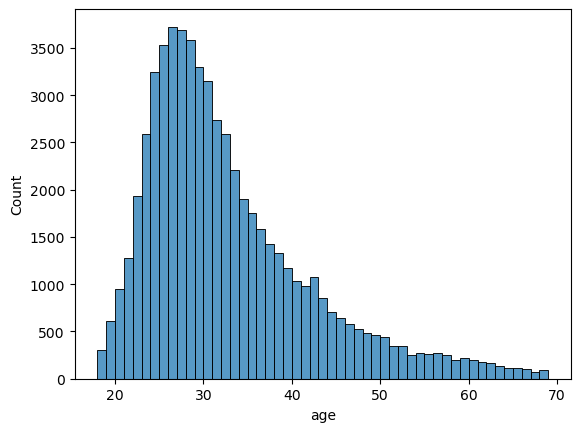

In [6]:
print(profiles.age.value_counts().sort_index())
#Filter unrealistic ages
profiles = profiles[(profiles.age <= 99)]
sns.histplot(profiles.age,binwidth=1);

- The user base skews heavily toward the 20-35 age range. This suggests the model will likely be most effective for predicting intent for Millennial users. The outliers (100+ years old) likely represent "troll" accounts or privacy-conscious users obfuscating their data, and should be filtered out to prevent noise.

#### Height

height
1.0        1
3.0        1
4.0        1
6.0        1
8.0        1
9.0        1
26.0       1
36.0      11
37.0       2
42.0       1
43.0       2
47.0       1
48.0       2
49.0       1
50.0       2
51.0       1
52.0       1
53.0       5
54.0       3
55.0       6
56.0       8
57.0      17
58.0      53
59.0     212
60.0     791
61.0    1090
62.0    2244
63.0    2767
64.0    3865
65.0    3794
66.0    4759
67.0    5353
68.0    5449
69.0    5179
70.0    6074
71.0    4826
72.0    5315
73.0    2815
74.0    2547
75.0    1382
76.0     783
77.0     280
78.0     132
79.0      57
80.0      27
81.0      11
82.0      11
83.0      12
84.0       9
85.0       1
86.0       1
87.0       1
88.0       2
89.0       1
90.0       1
91.0       3
92.0       1
93.0       1
94.0       3
95.0      19
Name: count, dtype: int64


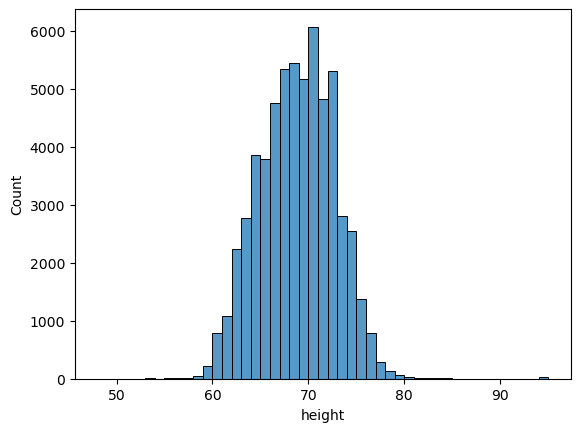

In [7]:
print(profiles.height.value_counts().sort_index())
#Filter unrealistic heights
profiles = profiles[(profiles.height >= 48) & (profiles.height <= 96)]
sns.histplot(profiles.height, binwidth=1);

- While height follows a normal distribution, entries under 30 inches or over 90 inches indicate data entry errors or intentionally misleading responses. I filter these responses.

#### Income

income
-1          48420
 20000       2950
 30000       1048
 40000       1005
 50000        975
 60000        736
 70000        707
 80000       1110
 100000      1621
 150000       630
 250000       149
 500000        48
 1000000      518
Name: count, dtype: int64


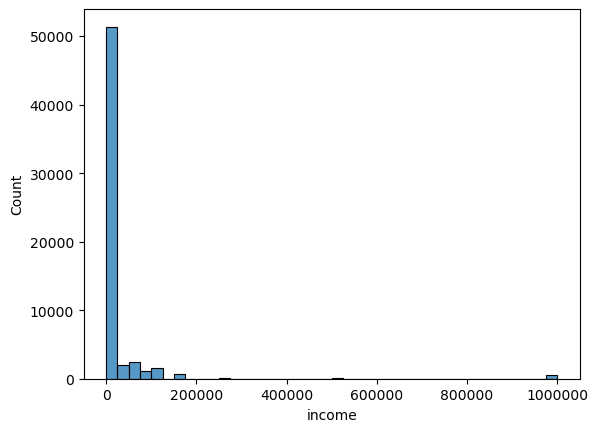

In [8]:
print(profiles.income.value_counts().sort_index())
sns.histplot(profiles.income, binwidth=25000)
plt.ticklabel_format(style='plain', axis='x');
#Drop income due to missingness
profiles = profiles.drop(columns=['income'])

- 80% of users have an income of `-1`. This is not an error and likely communicates that most users prefer not to disclose financial status on a public dating profile. Because the vast majority of users hide this data, I drop `income` as a predictive feature. Imputing values would introduce too much noise, and using the variable would bias the model toward the small minority of users comfortable sharing their wealth.

####Last Login

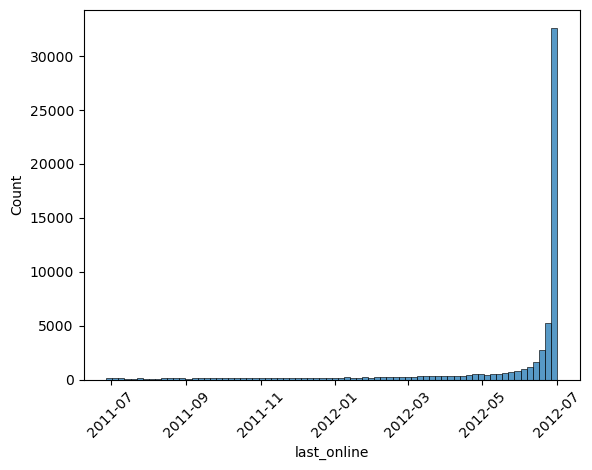

In [9]:
profiles.last_online = pd.to_datetime(profiles.last_online, format='%Y-%m-%d-%H-%M')
sns.histplot(profiles.last_online, binwidth=5)
plt.xticks(rotation=45);

- The `last_online` distribution confirms this data is a snapshot from 2011-2012. While the data is older, the fundamental aim for this project hinges on addressing user intent through demographic relationships that tend to remain stable over time. In other words, can demographics and essay responses be used to predict relationship intentions (e.g., wanting children)?

### Discrete Features

#### Body Type

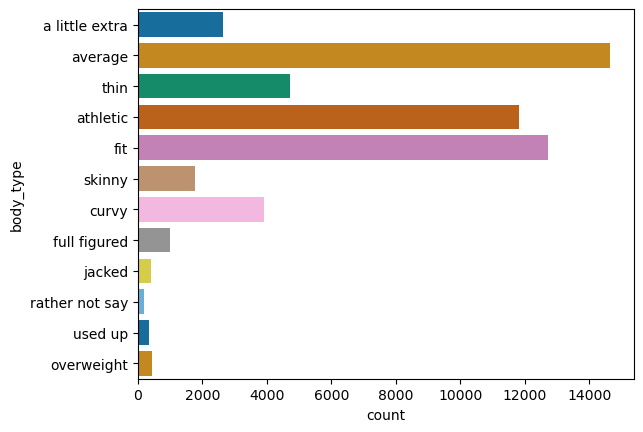

In [10]:
sns.countplot(y=profiles.body_type, hue = profiles.body_type, palette = 'colorblind', legend=False);

- The majority of users classify their body type as either average, athletic, or fit. This suggests that most users seem to have an activte lifestlye in some capacity and may highlight features that contribute to romantic compatabilty.

#### Diet

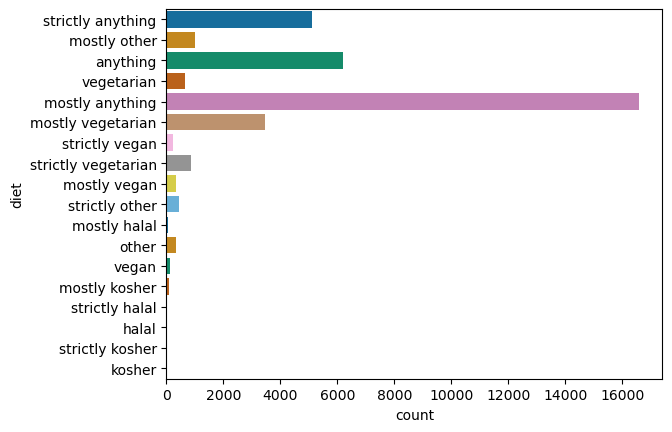

In [11]:
sns.countplot(y=profiles.diet, hue = profiles.diet, palette = 'colorblind', legend=False);

- Users express dietary restrictions with varying degrees of strictness. To reduce noise, I group responses into their core categories in `diet_clean`.

diet_clean
anything      27873
vegetarian     4985
other          1786
vegan           702
kosher          115
halal            77
Name: count, dtype: int64


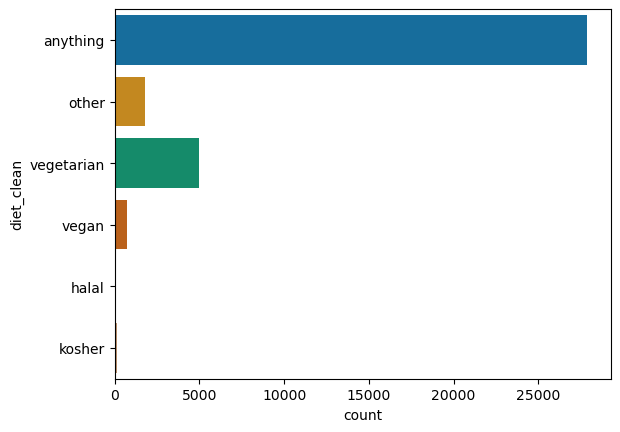

In [12]:
profiles['diet_clean'] = profiles.diet.str.split().str.get(-1)
print(profiles.diet_clean.value_counts())
sns.countplot(y=profiles.diet_clean, hue = profiles.diet_clean, palette = 'colorblind', legend=False);

After condensing the diet variable, the visualizations indicate that most users do not follow any sort of diet. Similar to `body_type`, these results provide insight into lifestyle choices for most users. While diet doesn't seem to be central for most users, about 12% of users follow some sort of diet.

#### Drinks

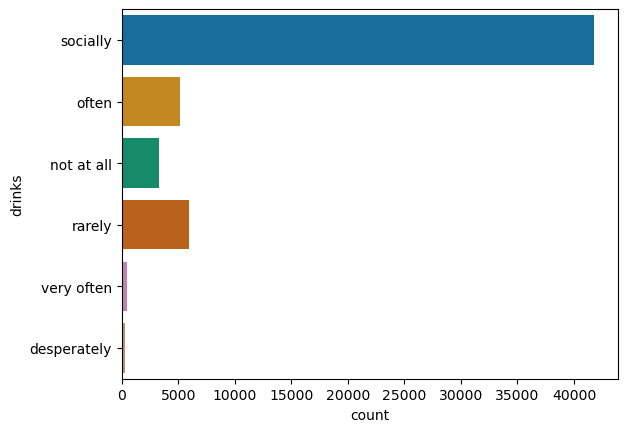

In [13]:
sns.countplot(y=profiles.drinks, hue = profiles.drinks, palette = 'colorblind', legend=False);

- The overwhelming majority of users report drinking socially. The dominance of social drinking is in line with the most frequent age group identified in the sample. Most users are between the ages of 25-35 and enjoy drinking socially with close others.

#### Drugs

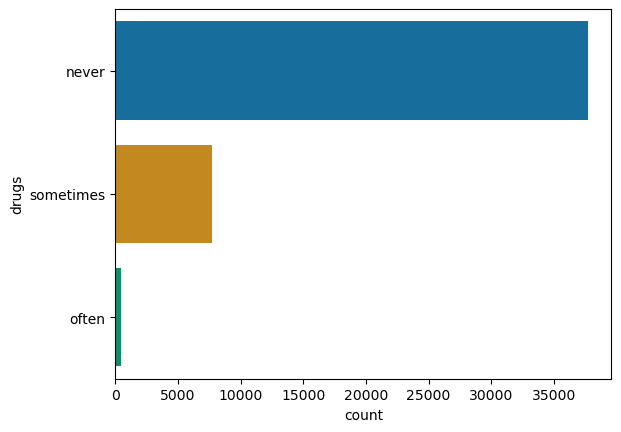

In [14]:
sns.countplot(y=profiles.drugs, hue = profiles.drugs, palette = 'colorblind', legend=False);

- The majority of users report that they have never tried drugs and about 12% of users state they do sometimes.

#### Ethnicity

In [15]:
print(f'Number of unique responses:', profiles.ethnicity.nunique())
print(profiles.ethnicity.value_counts())

Number of unique responses: 217
ethnicity
white                                                                 32826
asian                                                                  6131
hispanic / latin                                                       2819
black                                                                  2006
other                                                                  1702
                                                                      ...  
middle eastern, indian, white                                             1
asian, middle eastern, black, white, other                                1
asian, middle eastern, indian, hispanic / latin, white, other             1
black, native american, indian, pacific islander, hispanic / latin        1
asian, black, indian                                                      1
Name: count, Length: 217, dtype: int64


- Given the number of unique responses (217), it is necessary to recode these data for visualization. Ethnicities often appear in combinations (e.g., "asian, white"), so recoding into binary indicator variables for each ethnicity allows for clearer visualization and analysis.

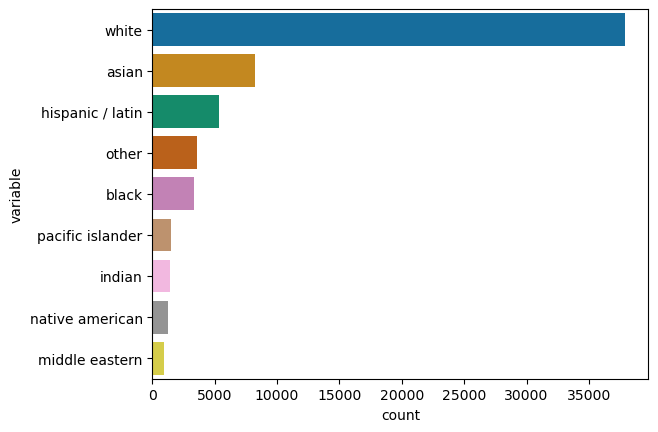

In [16]:
eth_dummies = profiles.ethnicity.str.get_dummies(sep= ', ')
profiles = pd.concat([profiles, eth_dummies], axis=1)
eth_columns = ['asian', 'black', 'hispanic / latin', 'indian', 'middle eastern', 'native american', 'other', 'pacific islander', 'white']
sns.countplot(data=pd.melt(profiles, value_vars=eth_columns).query('value == 1'), y='variable', hue = 'variable', palette = 'colorblind',
              order=pd.melt(profiles, value_vars=eth_columns).query('value == 1')['variable'].value_counts().index,
              hue_order = pd.melt(profiles, value_vars=eth_columns).query('value == 1')['variable'].value_counts().index);

- Although these categories are not mutually exclusive, they provide a more accurate representation of user ethnicity. The data is dominated by users who are, or are at least partially, white. I further investigate this variable by determining the co-occurence of different ethnicities using a heatmap.

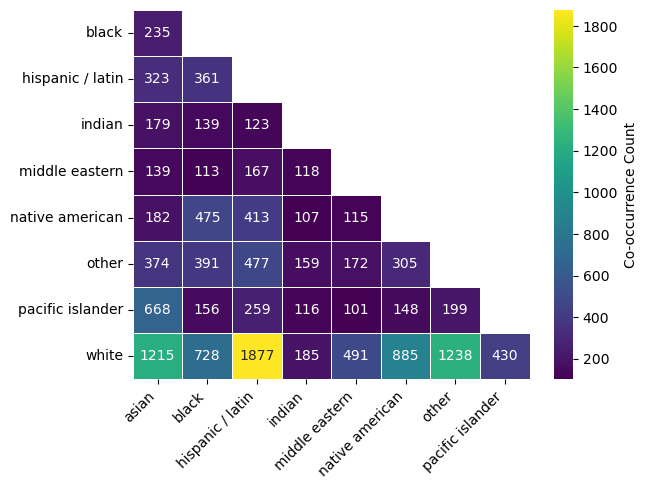

In [17]:
eth_matrix = profiles[eth_columns].T.dot(profiles[eth_columns])
n = eth_matrix.shape[0]
mask = np.triu(np.ones_like(eth_matrix, dtype=bool))[1:, :-1]
ax = sns.heatmap(eth_matrix.iloc[1:, :-1], mask=mask, annot=True, fmt='d', linewidths=.5, cbar_kws={'label': 'Co-occurrence Count'}, cmap='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show();

- Consistent with the count plot, white shows the highest level of co-occurrence with other ethnicities. Additionally, some ethnicities, such as asian and black, display distinct co-occurrence patterns, with higher counts alongside pacific islander and native american, respectively. Given the location variable informs that most users live in California (see Appendix), these cooccurences are in line with the type of ethnic backgrounds expected for individuals that live along the west coast (e.g., higher asian, hispanic, and pacific islander populations).

#### Education

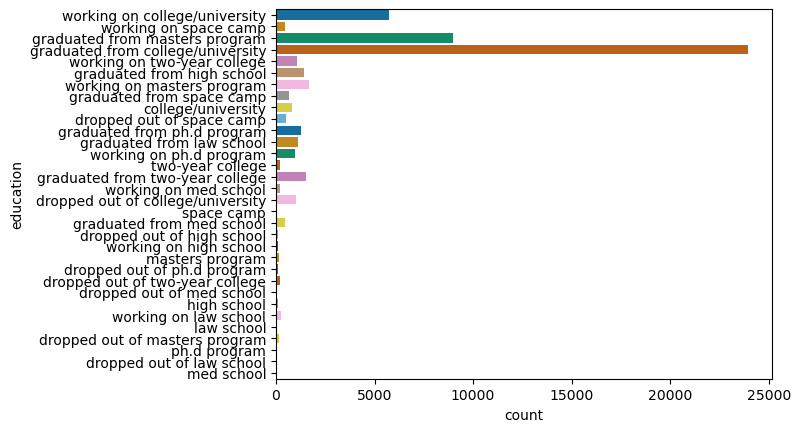

In [18]:
sns.countplot(y=profiles.education, hue = profiles.education, palette = 'colorblind', legend=False);

- Given the number of categories, I recategorized these responses into an ordinal `education_level` variable. This variable will map each user's completed education level and will reduce unnecessary noise introduced by the 'dropped out' responses.

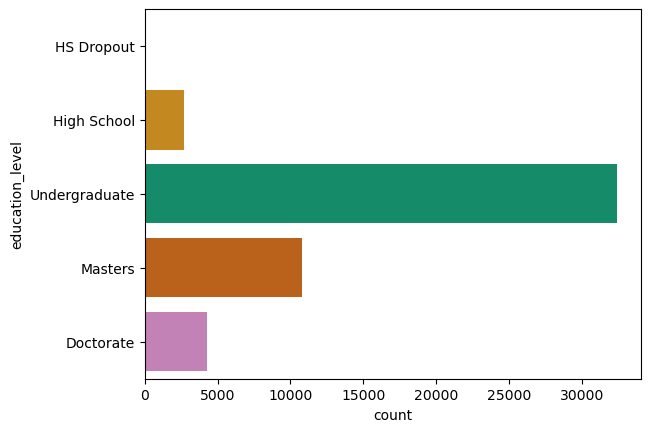

In [19]:
education_level_map = {
  #High School (1)
    'graduated from high school': 1,
    'working on high school': 1,
    'dropped out of high school': 0,

  #Undergraduate (2)
    'graduated from two-year college': 2,
    'graduated from college/university': 2,
    'working on two-year college': 2,
    'working on college/university': 2,
    'dropped out of two-year college': 1, #Treats dropout as High School
    'dropped out of college/university': 1, #Treats dropout as High School

  #Masters (3)
    'graduated from masters program': 3,
    'working on masters program': 3,
    'dropped out of masters program': 2, #Treats dropout as Bachelor level

  #Doctorate/Professional Tier (4)
    'graduated from ph.d program': 4,
    'working on ph.d program': 4,
    'graduated from law school': 4,
    'working on law school': 4,
    'graduated from med school': 4,
    'working on med school': 4,
    'dropped out of ph.d program': 3, #Falls back to Masters
    'dropped out of law school': 2,   #Falls back to Bachelors
    'dropped out of med school': 2    #Falls back to Bachelors
  }

profiles['education_level'] = profiles.education.map(education_level_map)
edu_labels = ['HS Dropout', 'High School', 'Undergraduate', 'Masters', 'Doctorate']
order = [0, 1, 2, 3, 4]
ax = sns.countplot(y=profiles.education_level, hue = profiles.education_level, palette = 'colorblind', legend=False);
ax.set_yticks(order)
ax.set_yticklabels(edu_labels);

- Most users report some form of college or university education. Additionally, a majority of users indicate that they have graduated from their respective programs. The data is slightly skewed towards higher education.

#### Job

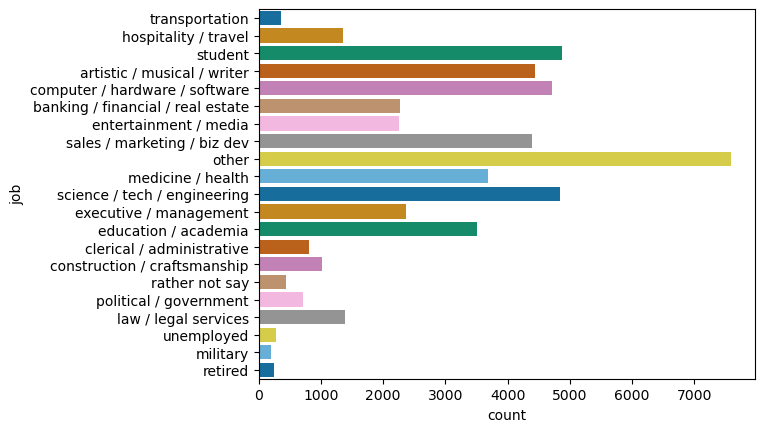

In [20]:
sns.countplot(y=profiles.job, hue = profiles.job, palette = 'colorblind', legend=False);

- Most job types seem to be well represented with other as the most frequently reported category. This distribution suggests that users on the platform have a wide range of career choices.

#### Kids

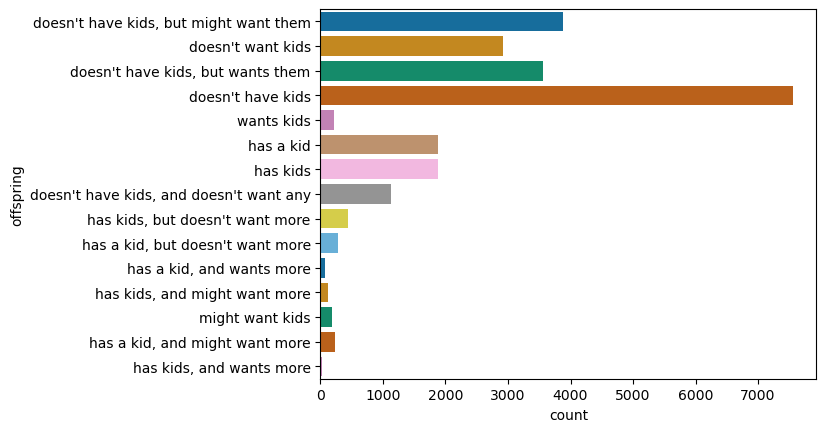

In [21]:
profiles.offspring = profiles.offspring.str.replace('&rsquo;', "'")
sns.countplot(y=profiles.offspring, hue = profiles.offspring, palette = 'colorblind', legend=False);

- I decompose these categories into two variables, namely `num_kids` and `want_kids`.

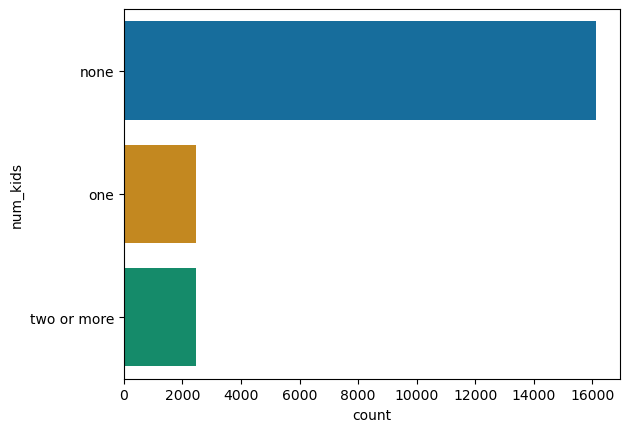

In [22]:
profiles['num_kids'] = profiles.offspring.str.extract(r'(doesn\'t have kids|has a kid|has kids)', expand=False)
num_conditions = [profiles.num_kids.str.contains('doesn\'t have', na=False),
                  profiles.num_kids.str.contains('has a kid', na=False),
                  profiles.num_kids.str.contains('has kids', na=False)]
num_choices = ['none', 'one', 'two or more']
profiles.num_kids = np.select(num_conditions, num_choices, default=None)
sns.countplot(y=profiles.num_kids, hue = profiles.num_kids, palette = 'colorblind', legend=False);

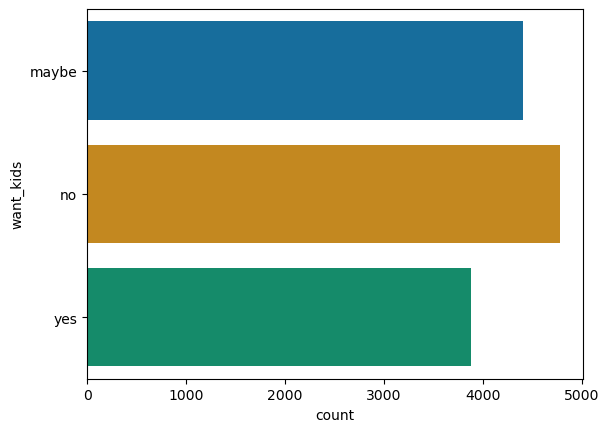

In [23]:
profiles['want_kids'] = profiles.offspring.str.extract(r'(wants kids|wants them|wants more|might want|doesn\'t want)', expand=False)
want_conditions = [profiles.want_kids.str.contains('doesn\'t want', na=False),
                  profiles.want_kids.str.contains('might want', na=False),
                  profiles.want_kids.str.contains('wants', na=False)]
want_choices = ['no', 'maybe', 'yes']
profiles.want_kids = np.select(want_conditions, want_choices, default=None)
sns.countplot(y=profiles.want_kids, hue = profiles.want_kids, palette = 'colorblind', legend=False);

- Among users who reported their parental status, the largest proportion indicated having no children, followed by two smaller but similarly sized groups: those with one child and those with two or more children. Regarding user preferences about having children in the future, the majority reported no, though this group is only marginally larger than those who responded maybe or yes.

#### Orientation

orientation
straight    51579
gay          5572
bisexual     2766
Name: count, dtype: int64


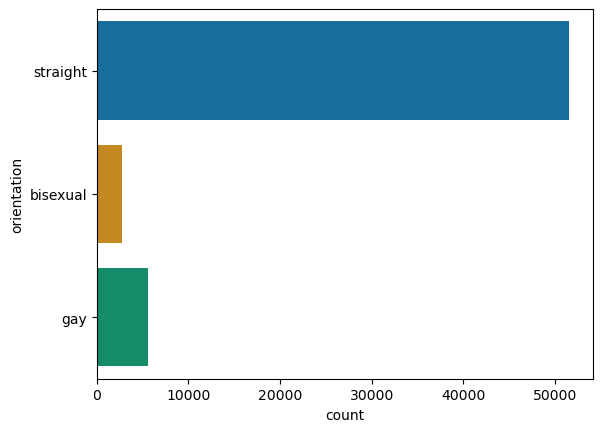

In [24]:
print(profiles.orientation.value_counts())
sns.countplot(y=profiles.orientation, hue = profiles.orientation, palette = 'colorblind', legend=False);

- The majority of users report being straight. Approximately 14% of users report being bisexual or gay.

#### Religion

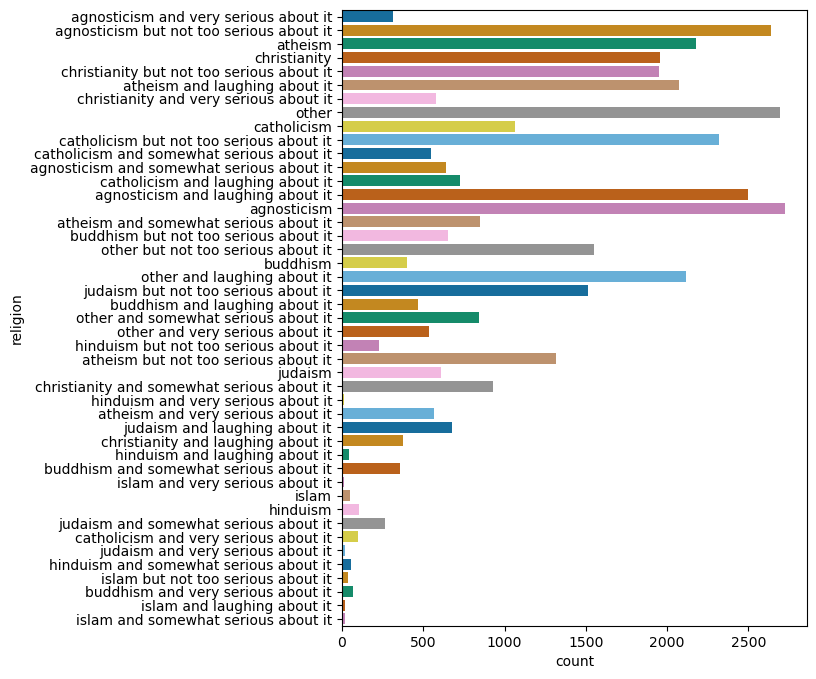

In [25]:
plt.figure(figsize=(6,8))
sns.countplot(y=profiles.religion, hue = profiles.religion, palette = 'colorblind', legend=False);

- Given the large number of specific response options, I recode religion into `relig_clean` to represent their religious practices and `relig_commitment` to represent their seriousness.

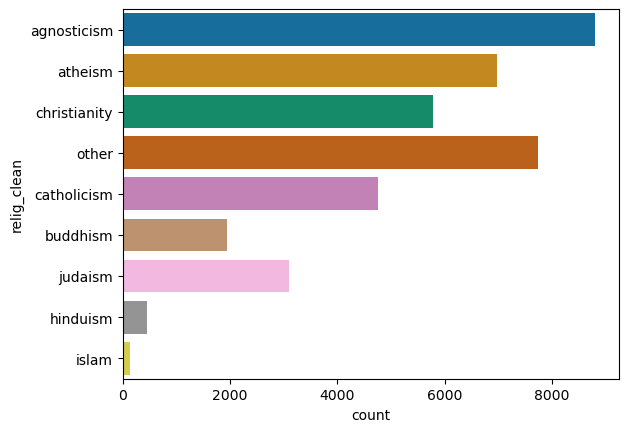

In [26]:
profiles['relig_clean'] = profiles.religion.str.split().str.get(0)
sns.countplot(y=profiles.relig_clean, hue = profiles.relig_clean, palette = 'colorblind', legend=False);

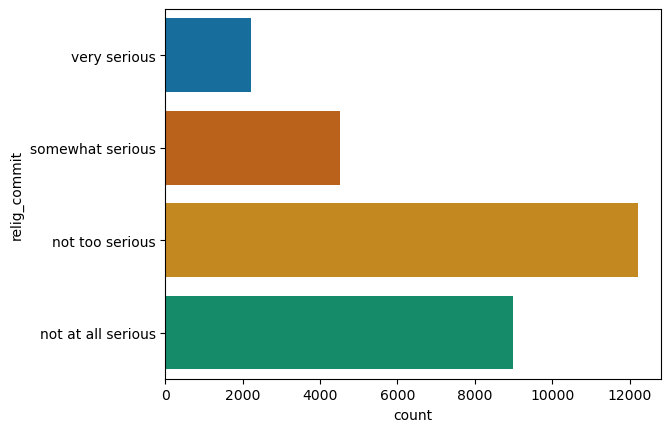

In [27]:
profiles['relig_commit'] = profiles.religion.str.extract(r'(very serious|somewhat serious|not too serious|laughing)', expand=False)
rel_comm_conditions = [profiles.religion.str.contains('very serious', na=False),
                       profiles.religion.str.contains('somewhat serious', na=False),
                       profiles.religion.str.contains('not too serious', na=False),
                       profiles.religion.str.contains('laughing', na=False)]
rel_comm_choices = ['very serious', 'somewhat serious', 'not too serious', 'not at all serious']
profiles.relig_commit = np.select(rel_comm_conditions, rel_comm_choices, default=None)
sns.countplot(y=profiles.relig_commit, hue = profiles.relig_commit, palette = 'colorblind', legend=False,
              order = ['very serious', 'somewhat serious', 'not too serious', 'not at all serious']);

- A substantial proportion of users identified as agnostic, atheist, or affiliated with an other religion. Among users who reported a specific religious tradition, the most frequently practiced were Christianity and Catholicism. With respect to religious commitment, the majority indicated that they are either not too serious or not at all serious about their religious practices. These variables indicate that while religion may be impactful to some users, the overwhelming majority do not consider it a central feature of their lifestyle.

#### Sex

sex
m    35810
f    24107
Name: count, dtype: int64

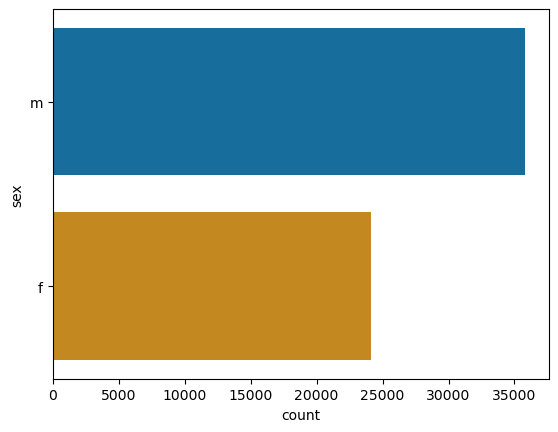

In [28]:
sns.countplot(y=profiles.sex, hue = profiles.sex, palette = 'colorblind', legend=False);
profiles.sex.value_counts()

- The breakdown of gender in the data is male-dominant with 35,829 males (\~60%) and 24,117 females (\~40%). Given this data was collected in the early 2010s, more nuanced gender categories (e.g., non-binary, transgender) were not measured.

#### Sign

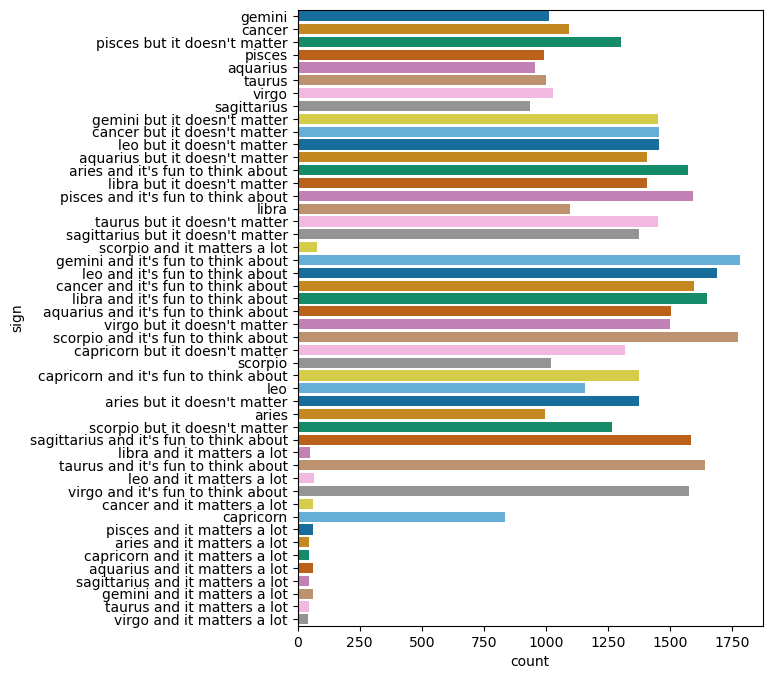

In [29]:
profiles.sign = profiles.sign.str.replace('&rsquo;', "'")
plt.figure(figsize=(6,8))
sns.countplot(y=profiles.sign, hue = profiles.sign, palette = 'colorblind', legend=False);

- I simplying the categorization scheme into `sign_clean`, which highlights the user's the primary astrological signs.

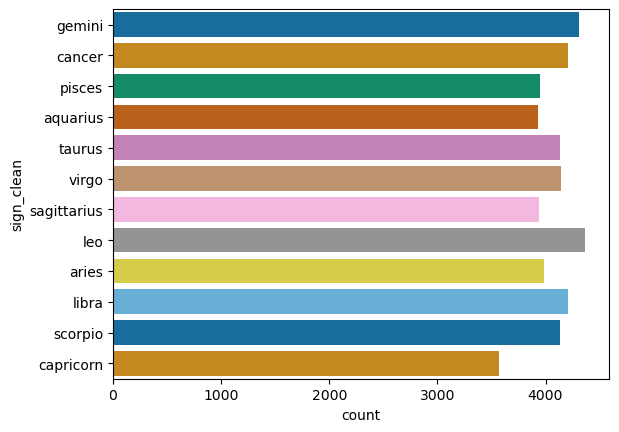

In [30]:
profiles['sign_clean'] = profiles.sign.str.split().str.get(0)
sns.countplot(y=profiles.sign_clean, hue = profiles.sign_clean, palette = 'colorblind', legend=False);

- The distribution of astrological signs is relatively even across users, although Capricorn is the least frequently reported. This visualization indicates that there isn't a skew in the time of birth across the calendar year between users.

#### Smokes

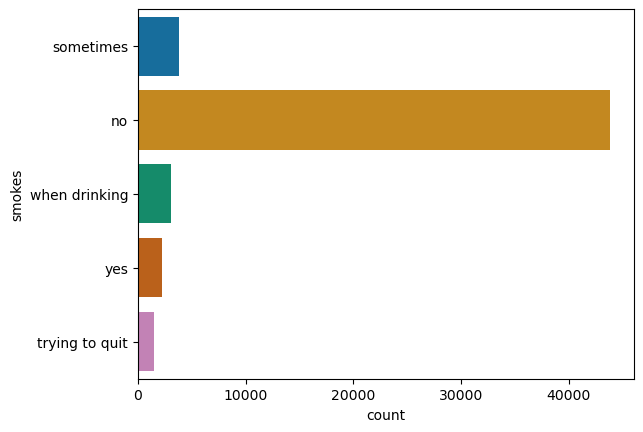

In [31]:
sns.countplot(y=profiles.smokes, hue = profiles.smokes, palette = 'colorblind', legend=False);

- The overwhelming majority of users do not smoke, and those who do smoke do so seldomly or are trying to quit.

#### Feature Selection

To improve model interpretability and reduce noise, I excluded the following variables prior to modeling:
- `language`: High cardinality. There were 7,642 unique responses. While decomposing this variable created a simpler classification scheme (mono/bi/multilingual), the information loss is likely too substantial.

- `location`, `status`, & `sign_seriousness`: Low variance. 92% of users reside in the same metropolitan area (San Francisco, California), 93% reported being single, and 98% reported not caring about their astrological sign. These variables offer no substantial predictive variation.

- `pets`: High missingness and scope. This variable had significant missing data and limited scope (restricted to cats/dogs), reducing its reliability as a predictor for relationship compatibility.

Despite removing these variables, visualizations and feature decomposition can be found in the appendix.

# Data Preparation and Feature Development

## Converting Categorical Variables into Numeric Form

### Variables

#### Ordinal:

- `drinks:` how often the user drinks, ranging from `not at all` to `desperately`
- `drugs:` how often the user uses drugs, ranging from `never` to `often`
- `education_level:` how far a user is in their educational program, ranging from `high school drop out` to `doctorate` (already ordered during the visualization stage)
- `num_kids:` how many children the user has, ranging from `zero` to `two or more`
- `want_kids:` whether or not the user wants children, ranging from `no` to `yes`
- `relig_commit:` how committed the user is to their religious practice, ranging from `not at all serious` to `very serious`
- `smokes:` smoking status, ranging from `no` to `trying to quit`

#### Nominal:
- `body_type:` the user's reported body type, containing 12 categories
- `diet_clean:` the user's reported diet, containing 6 categories
- `ethnicity:` the user's ethnic background, containing 9 categories (already dummy coded during the visualization stage)
- `job:` the user's job domain, containing 21 categories
- `orientation:` the user's sexual orientation, containing 3 categories
- `relig_clean:` the user's religious practice, containing 9 categories
- `sex:` the user's reported gender, containing 2 categories (`male` or `female`)
- `sign_clean:` the user's reported astrological sign, containing 12 categories

### Recoding

I apply ordinal mappings to each of the ordinal variables and dummy-code the remaining nominal variables. To keep the original dataset uncluttered, I create a copy of the dataframe for these transformations.

In [32]:
#Unnecessary columns:
cols_to_drop = ['diet', 'education', 'ethnicity', 'last_online', 'location', 'offspring', 'pets', 'religion', 'sign', 'speaks',
                'status']
profiles_copy = profiles.drop(columns=cols_to_drop)
profiles_copy = profiles_copy.replace({None: np.nan})

#Ordinal columns (education_level excluded as was previously mapped):
ord_cols = ['drinks', 'drugs', 'num_kids', 'want_kids', 'relig_commit', 'smokes']

drinks_codes = {'not at all': 0, 'rarely': 1, 'socially': 2, 'often': 3, 'very often': 4, 'desperately': 5}
drugs_codes = {'never': 0, 'sometimes': 1, 'often': 2}
num_kids_codes = {'zero': 0, 'one': 1, 'two or more': 2}
want_kids_codes = {'no': 0, 'maybe': 1, 'yes': 2}
relig_commit_codes = {'not at all serious': 0, 'not too serious': 1, 'somewhat serious': 2, 'very serious': 3}
smokes_codes = {'no': 0, 'when drinking': 1, 'sometimes': 2, 'yes': 3, 'trying to quit': 4}

ordinal_map = {'drinks': drinks_codes,
               'drugs': drugs_codes,
               'num_kids': num_kids_codes,
               'want_kids': want_kids_codes,
               'relig_commit': relig_commit_codes,
               'smokes': smokes_codes}

def encode_ordinal_columns(df, ordinal_map):
    for col, mapping in ordinal_map.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)
    return df

profiles_copy = encode_ordinal_columns(profiles_copy, ordinal_map)

#Categorical columns (ethnicity excluded as was previously encoded):
cat_cols = ['body_type', 'diet_clean', 'job', 'orientation', 'relig_clean', 'sex', 'sign_clean']

dummy_codes = pd.get_dummies(profiles_copy[cat_cols], prefix=cat_cols, drop_first = True, dtype=int)
profiles_copy = pd.concat([profiles_copy, dummy_codes], axis=1)

#Drop the original categorical columns
profiles_copy = profiles_copy.drop(columns=cat_cols)

print(profiles_copy.columns)

Index(['age', 'drinks', 'drugs', 'essay0', 'essay1', 'essay2', 'essay3',
       'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'height',
       'smokes', 'asian', 'black', 'hispanic / latin', 'indian',
       'middle eastern', 'native american', 'other', 'pacific islander',
       'white', 'education_level', 'num_kids', 'want_kids', 'relig_commit',
       'body_type_athletic', 'body_type_average', 'body_type_curvy',
       'body_type_fit', 'body_type_full figured', 'body_type_jacked',
       'body_type_overweight', 'body_type_rather not say', 'body_type_skinny',
       'body_type_thin', 'body_type_used up', 'diet_clean_halal',
       'diet_clean_kosher', 'diet_clean_other', 'diet_clean_vegan',
       'diet_clean_vegetarian', 'job_banking / financial / real estate',
       'job_clerical / administrative', 'job_computer / hardware / software',
       'job_construction / craftsmanship', 'job_education / academia',
       'job_entertainment / media', 'job_executive / managemen

## Imputing Missing Values

In [33]:
profiles_copy.isnull().sum()[profiles_copy.isnull().sum() > 1]

drinks              2975
drugs              14070
essay0              5481
essay1              7565
essay2              9631
essay3             11470
essay4             10528
essay5             10840
essay6             13764
essay7             12444
essay8             19216
essay9             12597
smokes              5506
education_level     9607
num_kids           55000
want_kids          46859
relig_commit       31993
dtype: int64

In line with common practice, I impute the median value for the numerical columns. For null values included in ordinal columns, I create a new category `unknown` to incorporate information from users that may have skipped reporting ordinal features (e.g., drinks). This steps allows me to retain the information provided by these users, even if they may have missing values across specific variables, and can thus be used for later clustering analyses.

In [34]:
profiles_copy.height = profiles_copy.height.fillna(profiles_copy.height.median())
print('Missing numerical values after imputation:')
print('Height:', profiles_copy.height.isnull().sum())

ordinal_cols_to_impute = ['drinks', 'drugs', 'num_kids', 'want_kids', 'relig_commit', 'smokes']
for col in ordinal_cols_to_impute:
    if profiles_copy[col].isnull().any():
        max_val = profiles_copy[col].max()
        profiles_copy[col] = profiles_copy[col].fillna(max_val + 1)
        if col in ordinal_map:
            ordinal_map[col]['unknown'] = max_val + 1

profiles_copy[ordinal_cols_to_impute].isnull().sum()

Missing numerical values after imputation:
Height: 0


drinks          0
drugs           0
num_kids        0
want_kids       0
relig_commit    0
smokes          0
dtype: int64

## Feature Engineering

I create several interaction terms based on feature combinations that could be particularly powerful for predicting user compatibility. Primarily, I focus on utilizing baseline demographic features like `age` and `sex_m` to capture their interaction with other features that may highlight unique aspects of a user's lifestyle and stability. For example:
- `age` * `education_level`: older individuals with higher education might be looking for long-term relationships given they may be at a more stable point in their life.
- `age` * `sex_m`: males and females at different stages in life may be have different desires and expectations from a relationship (e.g., `want_kids`).
- `num_kids` * `relig_commit`: religious individuals may have a higher number of children and that might influence the type of family dynamics and responsibility that a user is seeking in a partner.

The list is not exhaustive, but provides a more nuanced approach to uncovering a user's romantic compatibility with others.

In [35]:
profiles_copy['age_education_level_interaction'] = profiles_copy.age * profiles_copy.education_level
profiles_copy['age_num_kids_interaction'] = profiles_copy.age * profiles_copy.num_kids
profiles_copy['age_relig_commit_interaction'] = profiles_copy.age * profiles_copy.relig_commit
profiles_copy['age_sex_m_interaction'] = profiles_copy.age * profiles_copy.sex_m

profiles_copy['num_kids_relig_commit_interaction'] = profiles_copy.num_kids * profiles_copy.relig_commit

profiles_copy['sex_m_education_level_interaction'] = profiles_copy.sex_m * profiles_copy.education_level
profiles_copy['sex_m_num_kids_interaction'] = profiles_copy.sex_m * profiles_copy.num_kids
profiles_copy['sex_m_relig_commit_interaction'] = profiles_copy.sex_m * profiles_copy.relig_commit

interaction_cols = ['age_education_level_interaction',
                    'age_num_kids_interaction',
                    'age_relig_commit_interaction',
                    'age_sex_m_interaction',
                    'num_kids_relig_commit_interaction',
                    'sex_m_education_level_interaction',
                    'sex_m_num_kids_interaction',
                    'sex_m_relig_commit_interaction']

profiles_copy[interaction_cols].describe()

age_education_level_interaction  age_num_kids_interaction  \
count                     50310.000000              59917.000000   
mean                         76.111509                 91.553232   
std                          35.421938                 26.467267   
min                           0.000000                 18.000000   
25%                          52.000000                 75.000000   
50%                          66.000000                 87.000000   
75%                          94.000000                105.000000   
max                         276.000000                207.000000   

       age_relig_commit_interaction  age_sex_m_interaction  \
count                  59917.000000           59917.000000   
mean                      83.500108              19.134853   
std                       58.229977              17.180176   
min                        0.000000               0.000000   
25%                       30.000000               0.000000   
50%                       92.000000              24.000000   
75%                      124.000000              31.000000   
max                      276.000000              69.000000   

       num_kids_relig_commit_interaction  sex_m_education_level_interaction  \
count                       59917.000000                       50310.000000   
mean                            7.501477                           1.345736   
std                             4.864890                           1.260849   
min                             0.000000                           0.000000   
25%                             3.000000                           0.000000   
50%                             9.000000                           2.000000   
75%                            12.000000                           2.000000   
max                            12.000000                           4.000000   

       sex_m_num_kids_interaction  sex_m_relig_commit_interaction  
count                59917.000000                    59917.000000  
mean                     1.733882                        1.513727  
std                      1.454679                        1.777561  
min                      0.000000                        0.000000  
25%                      0.000000                        0.000000  
50%                      3.000000                        0.000000  
75%                      3.000000                        4.000000  
max                      3.000000                        4.000000

## Extracting Essay Sentiment

I extract sentiment from a consolidated text block of all essay responses to evaluate its usefulness as a predictor. Rather than analyzing each essay individually, I merge the text to create a holistic sentiment score for each user. The two metrics created are:

- `global_polarity`: Measures how positive or negative the user's language is overall (-1 to +1).
- `global_subjectivity`: Measures how opinionated vs. factual the user's statements are (0 to 1).

In [36]:
# Merge essays
essay_cols = [f'essay{i}' for i in range(10)]
profiles_copy['tokens_str'] = profiles_copy[essay_cols].fillna('').agg(' '.join, axis=1)

# Clean
profiles_copy['tokens_str'] = profiles_copy['tokens_str'].str.replace('&rsquo;', "'", regex=False)
profiles_copy['tokens_str'] = profiles_copy['tokens_str'].str.replace('<br/>', " ", regex=False)

# Apply sentiment analysis
def get_global_sentiment(text):
    if not text:
        return 0.0, 0.0
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity
profiles_copy[['global_polarity', 'global_subjectivity']] = profiles_copy['tokens_str'].apply(lambda x: pd.Series(get_global_sentiment(x)))

# Remove raw text
profiles_copy = profiles_copy.drop(columns=essay_cols)
print(profiles_copy[['global_polarity', 'global_subjectivity']].head())

   global_polarity  global_subjectivity
0         0.112918             0.540329
1         0.181652             0.621025
2         0.131901             0.499643
3         0.183333             0.350000
4         0.114394             0.402462


# Analysis

## Question 1:
## Predicting Family Planning: Which demographics predict the intention to have children?

### Aims

**Research Goal:**
- A major friction point in the user matching is missing or ambiguous family planning data. The primary objective is to determine if profile traits can be utilized to predict whether a user is likely to want children in their future.

**Hypothesis:**

- I hypothesize that biological, identity, and lifestyle factors (e.g., Age, Orientation, Education) will provide a strong baseline signal for evaluating whether a user may or may not want children.

**Methodological Approach:**

- I utilize Gradient Boosting Classifiers for this analysis. Unlike linear models, Gradient Boosting effectively captures non-linear relationships and is robust against the noise inherent in user-generated data.

**Data Strategy:**

- I filter out the `unknown` class for training to establish a valid ground truth, ensuring the model learns from users who have explicitly stated their intent for children.

### Multi-Classification Scheme

Shape of X_train: (9140, 85)
Shape of X_test: (3918, 85)
Shape of y_train: (9140,)
Shape of y_test: (3918,)

Gradient Boosting Classification Report:

0 = No, 1 = Maybe, 2 = Yes

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.69      1432
         1.0       0.46      0.41      0.44      1321
         2.0       0.54      0.57      0.55      1165

    accuracy                           0.57      3918
   macro avg       0.56      0.56      0.56      3918
weighted avg       0.56      0.57      0.56      3918


Gradient Boosting Classifier Accuracy Score: 0.5651


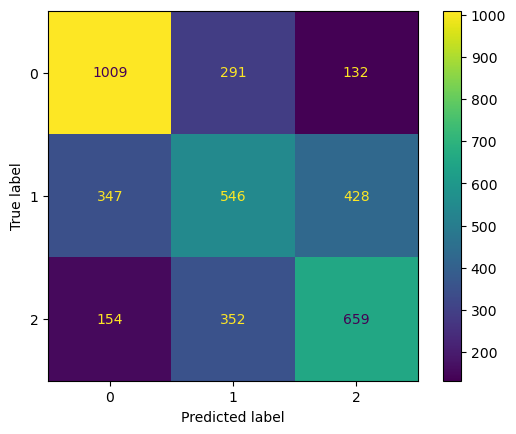

In [37]:
X = profiles_copy.drop(columns=['want_kids', 'tokens_str'])
y = profiles_copy['want_kids']

# Filter users who did not report wanting children
known_desires_mask = y != 3.0
X = X[known_desires_mask]
y = y[known_desires_mask]

X = X.loc[y.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=22, stratify=y)

# Store column names before scaling for later visualizations
X_columns = X.columns

# Apply MinMaxScaler to data to standardized features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_columns)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

GBC = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=22)
GBC.fit(X_train, y_train)

y_pred_GBC = GBC.predict(X_test)

print(f'\nGradient Boosting Classification Report:')
print(f'\n0 = No, 1 = Maybe, 2 = Yes\n')
print(classification_report(y_test, y_pred_GBC))
print(f'\nGradient Boosting Classifier Accuracy Score: {accuracy_score(y_test, y_pred_GBC):.4f}')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_GBC)).plot();

The model achieved an overall accuracy of 56.51%, significantly outperforming the random baseline (33%), but revealing a critical limitation in using demographics to predict user intent.

**Signal Gap:**

- Strong Signal (`No`): The model was most effective at identifying users who do not want children (Recall: 70%). This suggests that being "child-free" is a distinct lifestyle marker with clear demographic correlations.

- Weak Signal (`Maybe`): The model failed to identify `Maybe` users (Recall: 41%), performing only slightly better than random chance. This confirms that demographic traits alone cannot distinguish an "undecided" user from the general population.

**Directional Bias:**

- `Maybe` users were misclassified as `Yes` (428 users) more often than as `No` (347 users). This suggests that `Maybe` users share more traits with "future parents" (`Yes`) than with "child-free" users (`No`). They may be aspirational parents whose hesitation is driven by uncaptured variables (e.g., financial confidence, home ownership) rather than a lack of desire.

The low accuracy in the `Maybe` class acts as noise that obscures the signal for decisive users. To verify the demographic signal strength, I simplify the classification scheme to decisive users only (`Yes` vs. `No`) to test whether the reduced scope improves model performance substantially.

### Binary Classification Scheme

Shape of X_train: (6059, 85)
Shape of X_test: (2597, 85)
Shape of y_train: (6059,)
Shape of y_test: (2597,)
want_kids
0.0    3342
1.0    2717
Name: count, dtype: int64

Gradient Boosting Classification Report:

0 = No, 1 = Yes

              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80      1432
         1.0       0.74      0.83      0.78      1165

    accuracy                           0.79      2597
   macro avg       0.79      0.79      0.79      2597
weighted avg       0.80      0.79      0.79      2597


Gradient Boosting Classifier Accuracy Score: 0.7901


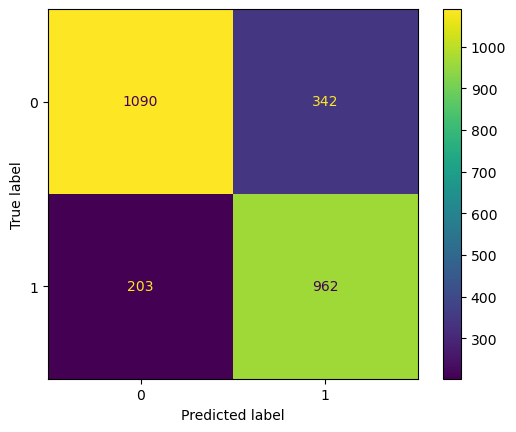

In [38]:
X_yn = profiles_copy.drop(columns=['want_kids', 'tokens_str'])
y_yn = profiles_copy['want_kids']

# Only keep binary responses
binary_mask = (y_yn == 0.0) | (y_yn == 2.0)
X_yn = X_yn[binary_mask]
y_yn = y_yn[binary_mask]

X_yn = X_yn.loc[y_yn.index]

X_train, X_test, y_train, y_test = train_test_split(X_yn, y_yn, test_size=.3, random_state=22, stratify=y_yn)

# Store column names before scaling for later visualizations
X_columns_yn = X_yn.columns

# Apply MinMaxScaler to standardize features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_columns_yn)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_columns_yn)

# Switch 'Yes' from 2.0 value to 1.0 value
y_train = y_train.replace(2.0, 1.0)
y_test = y_test.replace(2.0, 1.0)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Determine value for scale_pos_weight with binary classification
print(y_train.value_counts())
#3342/2717 ~ 1.23

GBC_yn = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, scale_pos_weight=1.23, random_state=22)
GBC_yn.fit(X_train, y_train)

y_pred_GBC_yn = GBC_yn.predict(X_test)

print(f'\nGradient Boosting Classification Report:')
print(f'\n0 = No, 1 = Yes\n')
print(classification_report(y_test, y_pred_GBC_yn))
print(f'\nGradient Boosting Classifier Accuracy Score: {accuracy_score(y_test, y_pred_GBC_yn):.4f}')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_GBC_yn)).plot();

By removing the ambivalent `Maybe` class, the model's accuracy improved from 56.51% to 79.01%. This dramatic improvement (+23%) confirms the primary hypothesis: Demographic variables are highly predictive of family planning goals, but only for users who have already made up their minds.

**The "Child-Free" Reliability:**

- The model achieved 84% Precision for the `No` class (child-free), which indicates that when the algorithm predicts a user does not want children, it is correct 84% of the time. This is critical for preventing "dealbreaker matches". It is possible to reliably filter these users out of matches for people who want families, minimizing bad dates and dating app fatigue.

**The "Future Parents" Capture Rate:**

- The model achieved 83% Recall for the `Yes` class (future parents). The model successfully identifies more than 8 out of 10 users who want children. This ensures a high hit rate for users seeking partners with similar family goals.

**The Remaining Gap:**

- There is still a ~21% error rate. This suggests that while demographics (Age, Sex, Education) are strong predictors, the remaining variance is likely driven by personal values, emotional readiness, and lifestyle nuance. These signals may be uncovered when analyzing open-text essays.

I have established that demographics provide a strong baseline signal (~79% accuracy) for decisive users. The next step is to understand which specific features drive these predictions to confirm they align with the wanting children.

### Top Features

To move beyond simple accuracy metrics, I utilize Shapley Additive Explanations (SHAP) to interpret the model's decision-making process. Unlike standard feature importance, SHAP visualizes both the direction and magnitude of each variable's impact, which allows precise observation of how specific user attributes increase or decrease the likelihood of wanting children.

I generate a Scree plot to separate signal from noise. I examine the top 8 features based on the plot's 'elbow' (where the line levels off) and feature importance score (feature importance > 0.02), which indicate that variables beyond this point provide minimal additional predictive power. While cutoffs at 3 or 7 were also viable, I select 8 to capture distinct lifestyle signals like social habits and religious values that appear as top predictors.

I visualize these 8 core drivers with a beeswarm plot to examine how specific values influence user intent, and finally group them into broader thematic categories for clear communication.

PermutationExplainer explainer: 2598it [01:05, 35.18it/s]                          


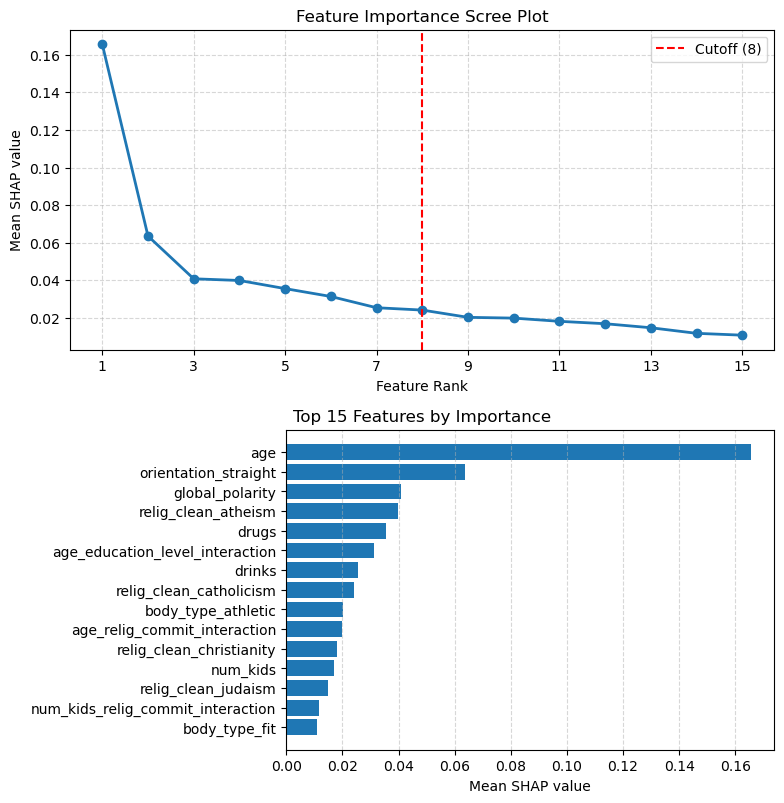

In [39]:
# Instantiate SHAP
shap.initjs()
explainer = shap.Explainer(GBC_yn.predict_proba, X_train)
shap_values = explainer(X_test)
shap_values.feature_names = list(X_columns_yn)

# Dataframe for plotting
mean_abs_shap = np.abs(shap_values[:, :, 1].values).mean(axis=0)
feature_importance = pd.DataFrame({'feature': shap_values.feature_names,
                                   'importance': mean_abs_shap}).sort_values(by='importance', ascending=False)

# 3. Visualize
fig = plt.figure(figsize=(8, 8))
rect_scree = [0.08, 0.55, 0.88, 0.40]
rect_bar   = [0.35, 0.05, 0.61, 0.40]
ax_scree = fig.add_axes(rect_scree)
ax_bar = fig.add_axes(rect_bar)

# Scree
top_feats = 15
ax_scree.plot(range(1, top_feats + 1), feature_importance['importance'][:top_feats], marker='o', linestyle='-', linewidth=2)
ax_scree.axvline(x=8, color='red', linestyle='--', label='Cutoff (8)')
ax_scree.set_title('Feature Importance Scree Plot')
ax_scree.set_xlabel('Feature Rank')
ax_scree.set_ylabel('Mean SHAP value')
ax_scree.set_xticks(range(1, top_feats + 1, 2))
ax_scree.legend()
ax_scree.grid(True, linestyle='--', alpha=0.5)

# Bar
top_data = feature_importance.head(top_feats).iloc[::-1]
bars = ax_bar.barh(top_data['feature'], top_data['importance'])
ax_bar.set_title(f'Top {top_feats} Features by Importance',
                 x = ((rect_scree[0] + (rect_scree[2] / 2) - rect_bar[0]) / rect_bar[2]))
ax_bar.set_xlabel('Mean SHAP value')
ax_bar.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.show()

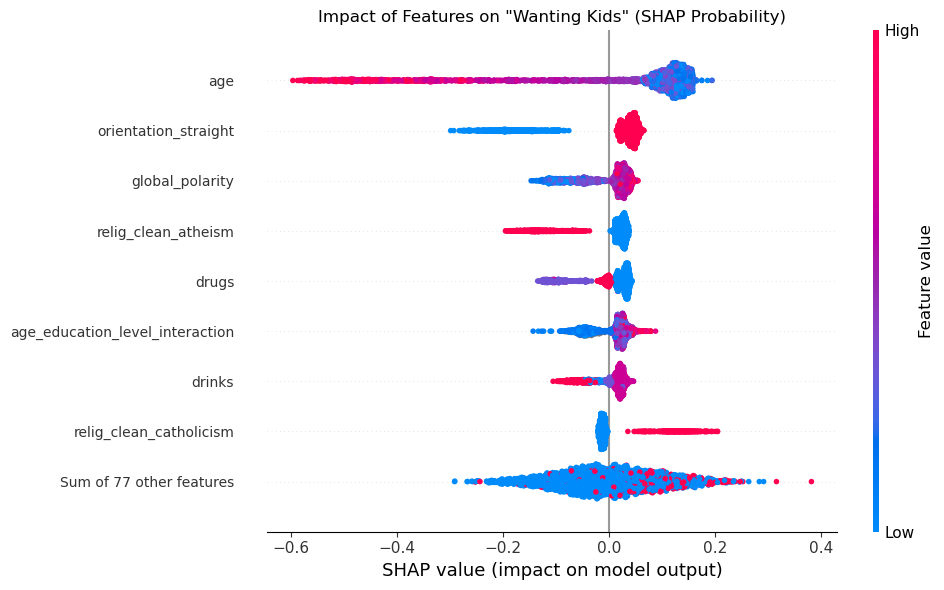

In [40]:
# Visualize SHAP values
plt.figure(figsize=(10, 6))
plt.title('Impact of Features on "Wanting Kids" (SHAP Probability)')

shap.plots.beeswarm(shap_values[:, :, 1], show=False, max_display=9, plot_size=None)

# Font size
ax = plt.gca()
ax.tick_params(axis='y', labelsize=10)

fig = plt.gcf()
fig.tight_layout()
plt.show();

With binary classification, the model identifies distinct aspects of a user's life that predict family planning:

**Life Stage**

- `Age`, `Age X Education Level`
- Life stage acts as the primary gatekeeper. There is a clear inverse relationship with age: younger users are significantly more likely to want children, while interest declines steadily over time. This relationship is influenced by education level, suggesting that perceived readiness (likely tied to career or financial stability) delays wanting children.

**Core Identity & Values**

- `Sexual Orientation`, `Atheism`, `Catholicism`
- Fundamental values act as strong polarization points. Heterosexual identity and Catholicism are strong positive signals, aligning with traditional family structures. In contrast, LGBTQ+ users and those identifying as Atheist show a distinct divergence, differentiating themselves from groups with stronger institutional ties to family planning.

**Emotional Disposition**
- `Global Polarity`
- Optimism is a predictor. Beyond demographics, the model relies on the emotional tone of a user's writing. High sentiment scores (positive language) strongly correlate with wanting children, suggesting that users who project an optimistic or enthusiastic outlook are more inclined toward parenthood.

**Lifestyle Compatibility**

- `Drugs`, `Drinking Habits`
- Daily habits serve as a proxy for lifestyle compatibility. High-frequency substance use strongly correlates with not wanting children, suggesting friction between hedonistic behaviors and the perceived responsibilities of parenthood.

### Feature Investigation

#### Stacked Bar Plotting Function

In [41]:
def stacked_bar_func(df, feature, target, title, ax, x_labels=None, order=None):
    # Filter 'unknown'
    df_filtered = df[df[target] != 3.0]

    # Create cross-tab
    ct = pd.crosstab(df_filtered[feature], df_filtered[target], normalize='index') * 100

    # Reorder if needed
    if order:
        ct = ct.reindex(order)

    # Plot
    plot = ct.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black', linewidth=.5, ax=ax)

    # Format
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel('Percentage of Users (%)')
    ax.legend(title='Wants Kids', labels=['No', 'Maybe', 'Yes'], bbox_to_anchor=(1.01, 1))

    # Custom x-labels
    if x_labels:
        ax.set_xticklabels(x_labels, rotation=0)

    # Add values to segments, black text if segment is yellow
    label_colors = ['white', 'white', 'black']
    for i, c in enumerate(ax.containers):
        labels = [f'{v:.0f}%' if v >= 2.5 else '' for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center', color=label_colors[i], weight='bold')

The function above creates color-coded stacked bar charts between top features and their influence on wanting children. It is used to create the following visualizations which highlight user segementation in each of the top SHAP features.

#### Life Stage

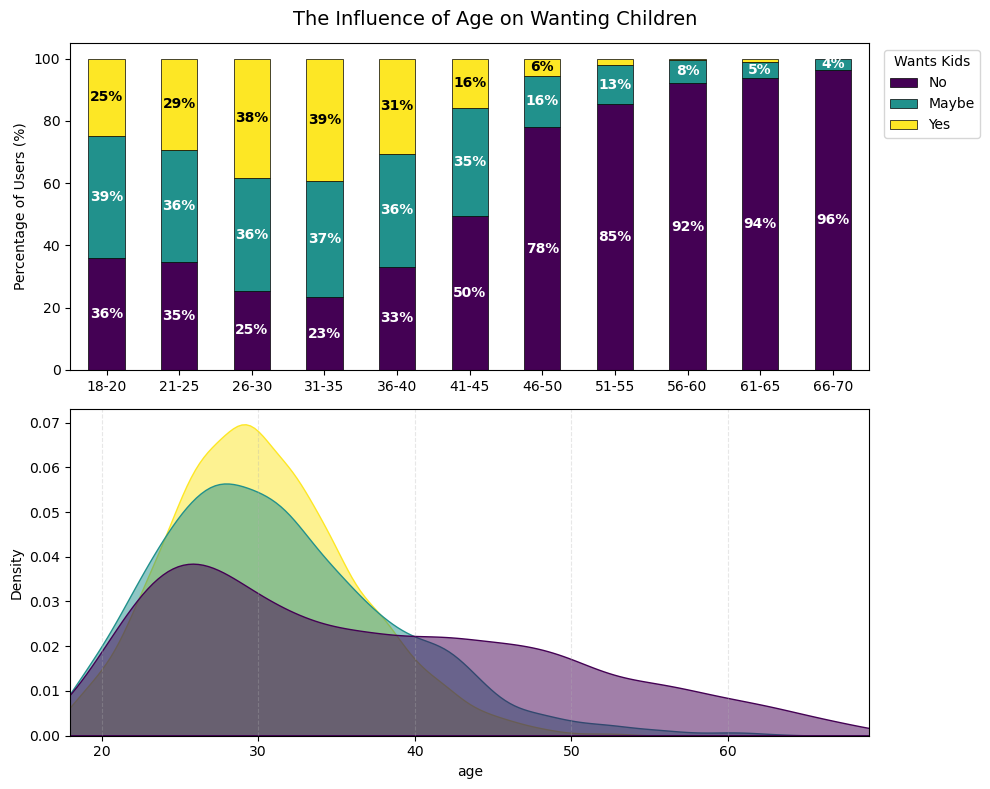

In [42]:
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 1, figure=fig)

# Age Stacked Bar
density_viz = profiles_copy[profiles_copy['want_kids'] != 3.0].copy()
max_age = density_viz['age'].max()
# Create 5 year bins ([18, 21), [21, 26), [26, 31), etc.) and label
age_bins = [18] + list(range(21, int(max_age) + 6, 5))
age_labels = [f'{age_bins[i]}-{age_bins[i+1]-1}' for i in range(len(age_bins)-1)]
density_viz['age_group'] = pd.cut(density_viz['age'], bins=age_bins, labels=age_labels, right=False)
ax_age = fig.add_subplot(gs[0, 0])
stacked_bar_func(density_viz, 'age_group', 'want_kids', None, ax_age, x_labels=age_labels)

# Age Stacked Bar
ax_age_dist = fig.add_subplot(gs[1, 0])
sns.kdeplot(data=density_viz, x='age', hue='want_kids', palette='viridis', fill=True, common_norm=False, alpha=0.5, ax=ax_age_dist)
ax_age_dist.set_xlim(18, max_age)
ax_age_dist.grid(axis='x', linestyle='--', alpha=0.3)

ax_age_dist.get_legend().remove()

fig.suptitle('The Influence of Age on Wanting Children', fontsize=14)
plt.tight_layout()
plt.show();

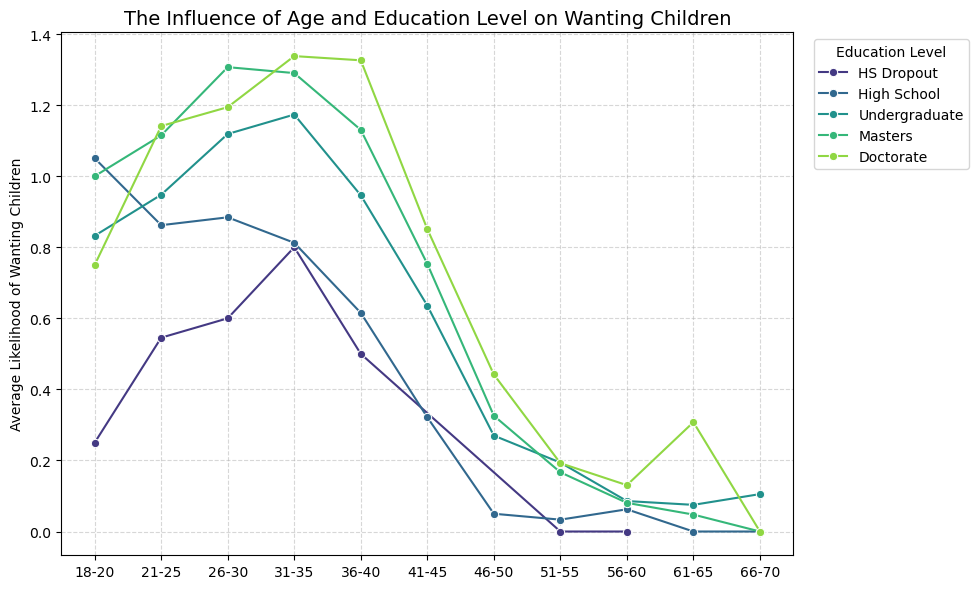

In [43]:
# Re-map descriptive labels, apply, then group
edu_level_map = {0: 'HS Dropout', 1: 'High School', 2: 'Undergraduate', 3: 'Masters', 4: 'Doctorate'}
education_order = ['HS Dropout', 'High School', 'Undergraduate', 'Masters', 'Doctorate']

density_viz['education_level_label'] = pd.Categorical(density_viz['education_level'].map(edu_level_map),
                                                      categories=education_order, ordered=True)
df_grouped = density_viz.dropna(subset=['age_group', 'education_level_label']).groupby(
                                ['age_group', 'education_level_label'],
                                observed=True)['want_kids'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grouped, x='age_group', y='want_kids', hue='education_level_label', marker='o', palette='viridis')

plt.title('The Influence of Age and Education Level on Wanting Children', fontsize=14)
plt.xlabel(None)
plt.ylabel('Average Likelihood of Wanting Children')
plt.legend(title='Education Level', bbox_to_anchor=(1.25, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Two trends emerge from the Life Stage variables:

- The intention to have children peaks between ages 25–35 for the majority of users before declining rapidly. This sharp drop-off highlights the biological and social windows users evaluate when considering parenthood.

- Importantly, education level shifts this timeline. Users with advanced degrees (Masters, PhD) maintain a higher openness to children later into their 30s compared to those with high school or undergraduate degrees. This suggests users with degrees in higher education defer to their career and financial stability prior to focusing on family.

#### Core Identity and Values

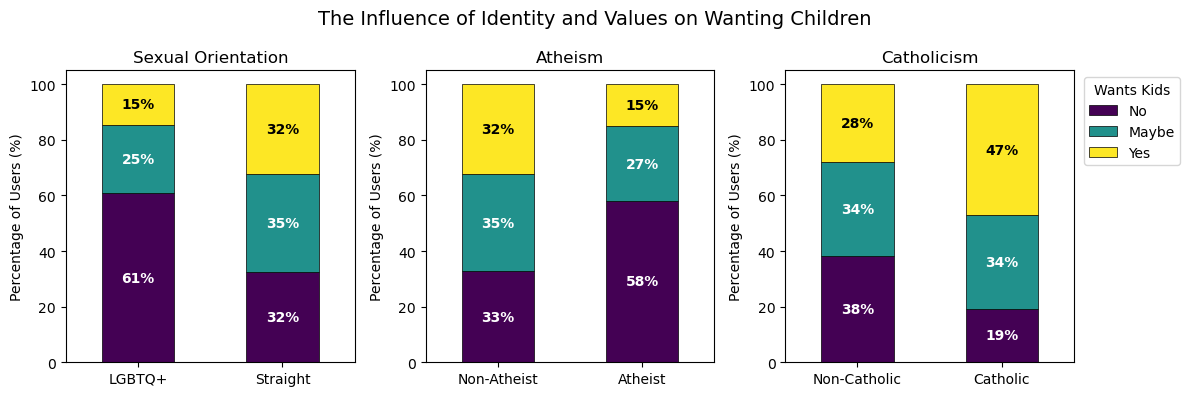

In [44]:
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 3, figure=fig)

# Sexual Orientation
ax_sex_ori = fig.add_subplot(gs[0, 0])
stacked_bar_func(profiles_copy, 'orientation_straight', 'want_kids', 'Sexual Orientation', ax_sex_ori,
                 x_labels=['LGBTQ+', 'Straight'])

# Atheism
ax_ath = fig.add_subplot(gs[0, 1])
stacked_bar_func(profiles_copy, 'relig_clean_atheism', 'want_kids', 'Atheism', ax_ath, x_labels=['Non-Atheist', 'Atheist'])

# Catholicism
ax_cath = fig.add_subplot(gs[0, 2])
stacked_bar_func(profiles_copy, 'relig_clean_catholicism', 'want_kids', 'Catholicism', ax_cath, x_labels=['Non-Catholic', 'Catholic'])

ax_sex_ori.get_legend().remove()
ax_ath.get_legend().remove()

fig.suptitle('The Influence of Identity and Values on Wanting Children', fontsize=14)
plt.tight_layout()
plt.show()

Core Identity and Value features reveal a distinct divergence in family goals:

- Users with conventionally traditional profiles (Heterosexual, Catholic) show a strong baseline desire for children. In contrast, users identifying as LGBTQ+ or Atheist are significantly less likely to want kids. This suggests that for LGBTQ+ and Atheist cohorts, the "traditional family" is less central to their identity, likely prioritized below other, more personal forms of community.

#### Emotional Disposition

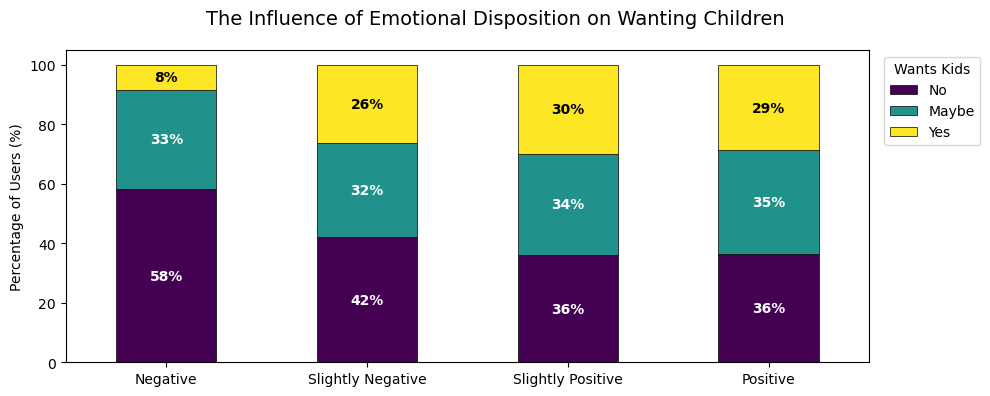

In [45]:
bins = [-1.0, -0.5, 0.0, 0.5, 1.0]
senti_labels = ['Negative', 'Slightly Negative', 'Slightly Positive', 'Positive']
density_viz['polarity_group'] = pd.cut(density_viz['global_polarity'], bins=bins, labels=senti_labels)

# Positivity
fig, ax_pos = plt.subplots(figsize=(10, 4))
stacked_bar_func(df=density_viz, feature='polarity_group', target='want_kids', title=None, ax=ax_pos,
                 x_labels= senti_labels)

fig.suptitle('The Influence of Emotional Disposition on Wanting Children', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Emotional disposition serves as a powerful predictor of family ambition:

- There is a stark contrast based on outlook: users with positive sentiment are nearly 4x more likely to want children (30%) compared to those with negative sentiment (8%). Moreover, negative users demonstrate the strongest rejection of family planning.

- Given these essays are self-descriptions, this suggests a fundamental worldview clash. Users who project cynicism or pessimism likely view the heavy responsibilities of parenthood as a burden they are unwilling to shoulder. In contrast, users who describe their lives with optimism appear to possess the confidence required to commit to family.

#### Lifestyle Compatibility

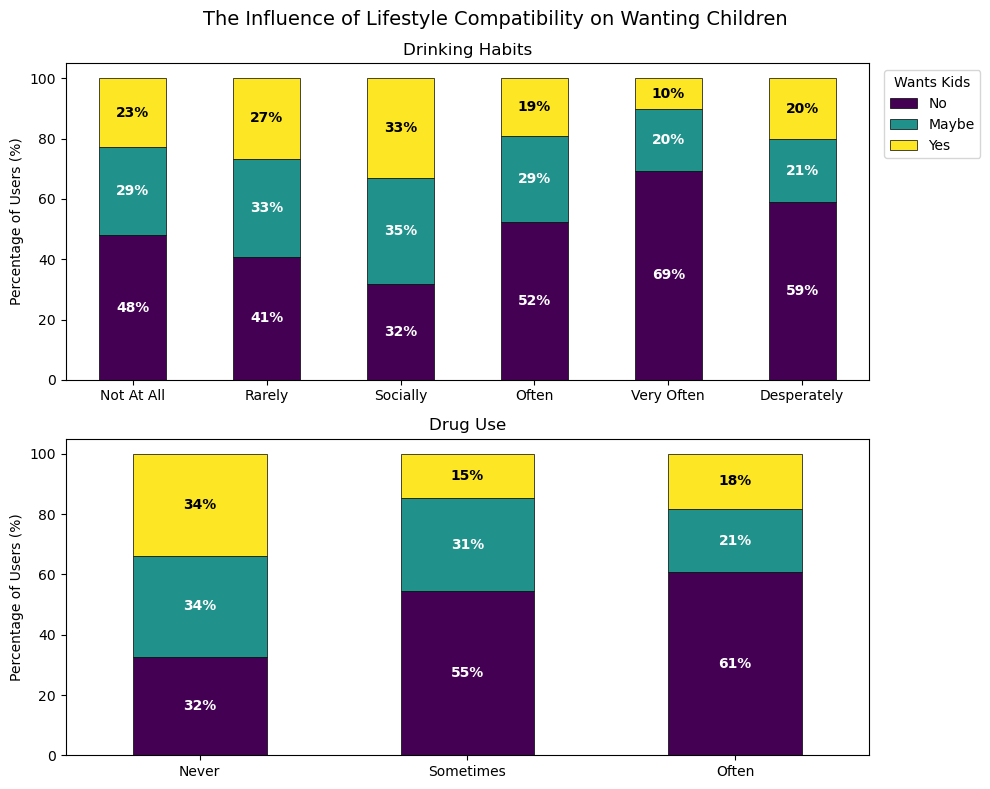

In [46]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 1, figure=fig)

# Drinking Habits
ax_drink = fig.add_subplot(gs[0, 0])
profiles_copy_filtered_drinks = profiles_copy[profiles_copy['drinks'] != 6.0]
stacked_bar_func(profiles_copy_filtered_drinks, 'drinks', 'want_kids', 'Drinking Habits', ax_drink,
                 x_labels=['Not At All', 'Rarely', 'Socially', 'Often', 'Very Often', 'Desperately'])

# Drug Use
ax_drug = fig.add_subplot(gs[1, 0])
profiles_copy_filtered_drugs = profiles_copy[profiles_copy['drugs'] != 3.0]
stacked_bar_func(profiles_copy_filtered_drugs, 'drugs', 'want_kids', 'Drug Use', ax_drug,
                  x_labels=['Never', 'Sometimes', 'Often'])

ax_drug.get_legend().remove()

fig.suptitle('The Influence of Lifestyle Compatibility on Wanting Children', fontsize=14)
plt.tight_layout()
plt.show()

Lifestyle markers reveal a friction between social habits and family planning:

- Users who report high-frequency substance use have a much weaker desire for children. Users prioritizing social lives likely view the responsibilities of parenthood as incompatible with their freedom.

- Interestingly, there is a similar drop-off at the other extreme. Users who strictly abstain from alcohol (48% do not want children) also diverge from the family-planning norm. This suggests that deviating from the social drinking norm serves as a proxy for non-normative lifestyles. Thus, users who drink socially appear to be the most aligned with traditional family goals.

### Recommendations Based on Family Planning Predictors

Based on the SHAP analysis and feature investigation, family planning is not random and is highly predictable based on four core signals:

**The Stability Window** (Life Stage)

- Age is the primary gatekeeper, but it is context-dependent. Users enter a high-intent window between ages 25 to 35, though higher education delays this window significantly.
- Recommendation: Prioritize family-planning prompts for users 25 and older, particularly those who have completed their education, as earlier signals are highly variable.

**The Values Alignment** (Identity)

- Traditional values drive intent. Users with conventional identities (Heterosexual, Catholic) show the strongest baseline desire for children, whereas Atheist and LGBTQ+ segments prioritize alternative relational goals.
- Recommendation: Avoid treating family as a universal default. Tailor matching algorithms to pair users based on core identity (e.g., matching Catholics with other traditional profiles) rather than just hobbies.

**The Optimism Factor** (Emotional Disposition)

- Optimism is a prerequisite for parenthood. Users with positive sentiment scores are 4x more likely to want children than those with negative scores. Cynicism acts as a major blocker, suggesting that users who view their lives pessimistically feel unable to shoulder the responsibility of a family.
- Recommendation: Use sentiment analysis as a "readiness" signal. Users who write enthusiastic, positive profiles are better candidates for family-oriented matching than those with neutral or negative tones.

**The Lifestyle Friction** (Habits)

- Daily habits serve as a proxy for compatibility. Both high-frequency substance use and strict abstinence correlate with a lower desire for children, suggesting that social moderation is the norm for family-oriented users.
- Recommendation: Utilize substance use frequency as a hard filter for family-oriented users to reduce lifestyle friction early in the matching process.

**Conclusion**

While the Gradient Boosting model successfully predicts who wants children (79% accuracy) using demographics and sentiment, it doesn't fully explain distinct personas that may exist.

To uncover these deeper archetypes, I move from supervised learning to unsupervised Natural Language Processing (NLP). By analyzing user essays with Latent Dirichlet Allocation (LDA), I aim to extract distinct user personas to determine if specific personality types influence family planning intentions in future relationships.

## Question 2:
## Beyond Demographics: Do unstructured text essays provide predictive power?

### Aims

**Research Goal:**

- The primary objective is to analyze unstructured essay text and identify distinct user personas based on interests and communication styles in order to layer personality data on top of demographics.

**Hypothesis:**

- I hypothesize that users will naturally cluster into distinct archetypes that are not explicitly captured by the structured variables. These archetypes could serve as a deeper signal for compatibility and family planning than demographics and sentiment analysis alone.

**Methodological Approach:**

- I utilize Latent Dirichlet Allocation (LDA), an unsupervised probabilistic model. Unlike the sentiment analysis (which only measures positivity and subjectivity), LDA uncovers thematic structures, allowing user grouping based on the co-occurrence of specific topics in their essays.

**Data Strategy:**

- I use a filtering and tokenization strategy that removes standard stop words and domain-specific noise. I force the model to focus exclusively on unique content descriptors that generate distinct, non-overlapping personas.

### Clean and Process Text

In [47]:
%%script false --no-raise-error
# Setup
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

noise_strings = ['ilink', 'href', 'http', 'www', 'rel=', 'nofollow', '/interests', '?i', 'nbsp', 'mailto', 'jpg', 'jpeg', 'png', 'gif', 'bmp',
                 'br', 'div', 'span', 'class', 'style', 'src', 'width', 'height']

dating_stop_words = {'love', 'like', 'good', 'looking', 'friend', 'time', 'people', 'think', 'thing', 'enjoy', 'really', 'fun', 'night', 'school', 'smile',
                     'lot', 'new', 'someone', 'person', 'make', 'world', 'day', 'year', 'favorite', 'way', 'stuff', 'best', 'pretty', 'great', 'non',
                     'little', 'big', 'old', 'bad', 'long', 'nice', 'cool', 'awesome', 'amazing', 'different', 'important', 'interesting', 'strong', 'list',
                     'sure', 'hard', 'right', 'happy', 'bit', 'place', 'profile', 'word', 'sense', 'type', 'idea', 'story', 'mind', 'reason', 'random', 'point',
                     'san', 'francisco', 'bay', 'area', 'california', 'sf', 'city', 'location', 'northern',  'cali', 'town', 'living', 'live', 'man',
                     'woman', 'men', 'women', 'guy', 'girl', 'boy',  'lady', 'gentleman', 'male', 'female', 'amp', 'lol', 'haha', 'hahaha', 'yeah',
                     'oh', 'wow', 'aww', 'shit', 'ass', 'damn', 'hell', 'crap', 'wtf', 'suck', 'crazy', 'weird', 'insane', 'stupid', 'eye', 'self', 'well'}

# Text processing function (nlp.pipe for batching, tqdm to track progress)
def process_and_clean_text(text_list):
    processed_docs = []
    for doc in tqdm(nlp.pipe(text_list, batch_size=2000, disable=["ner", "parser"]),
                    total=len(text_list), desc="Processing Text"):
        tokens = []
        for token in doc:
            if token.pos_ in ['NOUN', 'ADJ', 'PROPN']:
                if token.is_alpha and not token.is_stop:
                    lemma = token.lemma_.lower()
                    if (lemma not in dating_stop_words) and (not any(noise in lemma for noise in noise_strings)):
                        tokens.append(lemma)
        processed_docs.append(tokens)
    return processed_docs

# Process and save
texts = profiles_copy['tokens_str'].tolist()
profiles_copy['processed_tokens'] = process_and_clean_text(texts)

# Create corpus
id2word = corpora.Dictionary(profiles_copy['processed_tokens'])
id2word.filter_extremes(no_below=100, no_above=0.4)
corpus = [id2word.doc2bow(text) for text in profiles_copy['processed_tokens']]

Couldn't find program: 'false'


The preceding function prepares 60,000 raw user essays for topic modeling (LDA). The process follows three steps:
- Utilizing `spaCy`, I filter for Nouns, Adjectives, and Proper Nouns. These parts of speech carry the highest thematic weight for identifying latent user interests, while verbs and adverbs often introduce noise.
- I removed standard technical artifacts (HTML/URL) and built a custom stop-word list to strip high-frequency dating words (e.g., "love," "fun," "good"). Crucially, I retained high-signal value-based terms (like "family") to ensure the resulting topics capture both implicit interests and explicit life goals.
- Tokens were reduced to their root forms (e.g., "running" -> "run") to consolidate related concepts.

Because this process is computationally expensive (~30-minute runtime), I implemented a freeze and load architecture. I use `%%script false` to bypass this block on subsequent runs, loading the processed tokens directly from a Pickle (`.pkl`) file following topic modeling. Pickle format was chosen over CSV to preserve list structures without the errors common in text-heavy CSV exports.

### Identify the Optimal Number of Personas

In [48]:
%%script false --no-raise-error
# Calculate Coherence Scores
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             random_state=22, chunksize=2000, passes=10, per_word_topics=True,
                             workers=7)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        score = coherencemodel.get_coherence()
        coherence_values.append(score)
        print(f" Personas: {num_topics} -- Coherence Score: {score:.4f}")
    return model_list, coherence_values

start = 2
limit = 11
step = 1

token_lists = profiles_copy['processed_tokens'].tolist()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=token_lists,
                                                        start=start, limit=limit, step=step)

# Plot
x = range(start, limit, step)
plt.figure(figsize=(10, 5))
plt.plot(x, coherence_values, marker='o', linestyle='-', linewidth=2)
plt.axvline(x=5, color='red', linestyle='--')
plt.title("Coherence Score Scree Plot")
plt.xlabel("Num Personas")
plt.ylabel("Coherence Score")
plt.xticks(x)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

Couldn't find program: 'false'


To determine the optimal number of personas, I utilized Coherence Scores to measure the semantic distinctiveness of each topic. I iterated through a range of (2 to 10) to find the balance between detail and interpretability.
-  The analysis revealed a global peak at 10 personas (0.427). However, an inspection of the top terms revealed that the 10-topic model produced noisy, overlapping clusters defined by surface-level adjectives (e.g., "kind," "quiet") rather than distinct lifestyle archetypes.
- There was a local peak at 5 personas (0.405) so I selected this value as the optimal parameter. While slightly lower mathematically, this value aggregated users into 5 meaningful archetypes that are distinct enough to evaluate.

Due to the high computational cost of iterative search, the loop is disabled via `%%script false` again, and the optimal parameter (5) is hardcoded into the final training step.

### Train the Optimized Model and Map Personas

In [49]:
%%script false --no-raise-error
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=5, random_state=22, chunksize=2000, passes=10, per_word_topics=True, workers=7)

def get_persona(bow):
    persona_probs = lda_model.get_document_topics(bow)
    if not persona_probs:
        return -1
    return sorted(persona_probs, key=lambda x: x[1], reverse=True)[0][0]

profiles_copy['Dominant_Topic'] = [get_persona(bow) for bow in corpus]

# Map names
topic_names = {0: "The Artist", 1: "The Techie", 2: "The Socialite", 3: "The Professional", 4: "The Romantic"}

profiles_copy['Persona_Label'] = profiles_copy['Dominant_Topic'].map(topic_names)
print(profiles_copy[['Dominant_Topic', 'Persona_Label']].head(10))

profiles_copy.to_pickle("../data/profiles_processed_checkpoint.pkl")
lda_model.save("../models/lda_model_frozen.gensim")
id2word.save("../models/dictionary_frozen.gensim")

Couldn't find program: 'false'


The code above trains the final LDA model to assign a dominant persona to each user. These personas are then mapped to categorical labels, allowing for assessment of whether psychographic archetypes predict family planning better than raw demographics alone.

LDA training on multicore processors is non-deterministic (the order of processing changes results slightly on every run). To guarantee consistency across the analysis:
- I train the model once.
- I save the dataframe with assigned labels, the LDA model, and the dictionary.
- All downstream analysis loads these frozen artifacts, ensuring that users remain in the same cluster throughout the entire analysis.

Once more, `%%script false` is used to bypass this step after the initial run.

### Visualize the Optimized Model

In [50]:
profiles_copy = pd.read_pickle("../data/profiles_processed_checkpoint.pkl")
lda_model = gensim.models.LdaModel.load("../models/lda_model_frozen.gensim")
id2word = gensim.corpora.Dictionary.load("../models/dictionary_frozen.gensim")
corpus = [id2word.doc2bow(text) for text in profiles_copy['processed_tokens']]

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
vis_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.118554 -0.015944       1        1  19.682190
1     -0.046119 -0.000095       2        1  19.673222
2      0.006119  0.089079       3        1  17.341447
3      0.109856  0.018266       4        1  19.543904
4      0.048698 -0.091306       5        1  23.759237, topic_info=              Term          Freq         Total Category  logprob  loglift
27            game  20812.000000  20812.000000  Default  30.0000  30.0000
535          sport   9361.000000   9361.000000  Default  29.0000  29.0000
71           video   5847.000000   5847.000000  Default  28.0000  28.0000
239   relationship  11510.000000  11510.000000  Default  27.0000  27.0000
482           wine  11490.000000  11490.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
1266     beautiful   2405.646764   5981.199040   Topic5  -6.1075   0.5264
1189          real   2610.128763   8414.919182   Topic5  -6.0259   0.2666
569           high   2522.113562   8691.398608   Topic5  -6.0602   0.2000
437           home   2845.830454  17853.081761   Topic5  -5.9394  -0.3991
147        dancing   2485.941894   8595.564114   Topic5  -6.0746   0.1966

[457 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5084      1  0.028686  acceptance
5084      2  0.023905  acceptance
5084      3  0.009562  acceptance
5084      4  0.019124  acceptance
5084      5  0.917958  acceptance
...     ...       ...         ...
1567      1  0.153068      zombie
1567      2  0.805683      zombie
1567      3  0.027884      zombie
1567      4  0.004746      zombie
1567      5  0.008306      zombie

[1788 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

*(Static preview. GitHub cannot render JavaScript.)*

![LDA Visualization](lda_viz.png)

By visualizing the intertopic distance and analyzing the most salient terms, I have labeled the 5 personas as follows:
1. **The Artist:**
    - Defined by high-culture tastes (`Art`, `Film`, `Band`, `Roc`k). This group represents a creative subculture where identity is signaled through consumption and taste rather than occupation.
2. **The Techie:**
    - Embedded in digital culture (`Game`, `Video`, `Computer`, `Internet`). These are intellectual, tech-native users who prioritize logic, media, and indoor hobbies.
3. **The Socialite:**
    - Characterized by high-energy social habits (`TV`, `Sport`, `Bar`, `Dinner`). These users are extroverted and activity-focused, valuing shared experiences over niche interests.
4. **The Professional:**
    - The most established group (`Work`, `Home`, `Dinner`, `Business`). These users prioritize stability and domestic comfort. The keyword "kid" appears here alongside "home" and "work," suggesting that for this group, children may already be incorporated into their life plan.
5. **The Romantic:**
    - Values-driven and intensity-focused (`Relationship`, `Sex`, `Nature`, `Heart`). Unlike the others, this group seeks deep emotional connection. The keyword "child" appears here (distinct from "kid" in the Professional group), suggesting a potential desire for family through emotional intimacy rather than stability.

### Persona Investigation and Validation

To investigate these personas, I evaluated demographic and behavioral variables to test if these text-based clusters mapped to meaningful real-world differences. The visualizations below are organized by the four psychographic pillars identified in the predictive model (Question 1).

Importantly, I have explicitly included Gender and Ethnicity in the **Core Identity & Values** section. While these features were not primary drivers of wanting children, they are critical for constructing a holistic profile of who these users are.

Following each visualization, I provide statistical validation of each persona across the respective variable.

#### Life Stage

##### Age

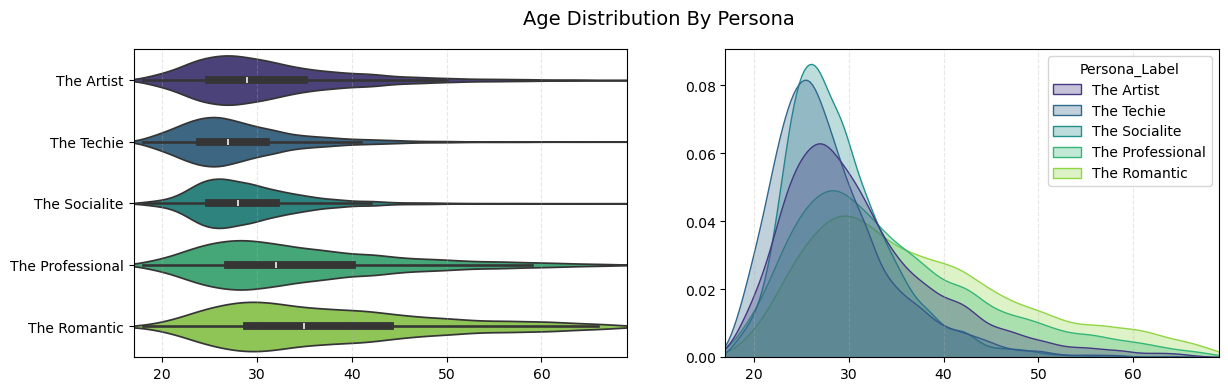

                    count       mean        std   min   25%   50%   75%   max
Persona_Label                                                                
The Artist        10869.0  31.328365   8.369575  18.0  25.0  29.0  35.0  69.0
The Techie        10570.0  28.183254   6.494989  18.0  24.0  27.0  31.0  69.0
The Socialite     11067.0  29.064245   5.928922  18.0  25.0  28.0  32.0  68.0
The Professional  16050.0  34.430779  10.147659  18.0  27.0  32.0  40.0  69.0
The Romantic      11361.0  37.403398  11.179923  18.0  29.0  35.0  44.0  69.0

One-Way ANOVA Results for Age by Persona:
F-Statistic: 2162.14
P-Value: 0.0000e+00
Effect Size (Eta-Squared): 0.1261

          Multiple Comparison of Means - Tukey HSD, FWER=0.00          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
      The Artist The Professional   3.1024   0.0  2.6772  3.5276   True
      The Artist     The Romantic    6.075   0.

In [51]:
persona_order = ['The Artist', 'The Techie', 'The Socialite', 'The Professional', 'The Romantic']
fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 2, figure=fig)

# Violin Plot
ax_age_pers = fig.add_subplot(gs[0, 0])
sns.violinplot(data=profiles_copy, x='age', y='Persona_Label', hue='Persona_Label', palette='viridis', order=persona_order, hue_order=persona_order, ax=ax_age_pers)
ax_age_pers.set_xlabel(None)
ax_age_pers.set_ylabel(None)
ax_age_pers.set_xlim(17, profiles_copy['age'].max())
ax_age_pers.grid(axis='x', linestyle='--', alpha=0.3)

# Density Plot
ax_age_pers_dens = fig.add_subplot(gs[0, 1])
sns.kdeplot(data=profiles_copy, x='age', hue='Persona_Label', palette='viridis', fill=True, common_norm=False, alpha=0.3, hue_order=persona_order, ax=ax_age_pers_dens)
ax_age_pers_dens.set_xlabel(None)
ax_age_pers_dens.set_ylabel(None)
ax_age_pers_dens.set_xlim(17, profiles_copy['age'].max())
ax_age_pers_dens.grid(axis='x', linestyle='--', alpha=0.3)

fig.suptitle('Age Distribution By Persona', fontsize=14)
plt.show()
print(profiles_copy.groupby('Persona_Label').age.describe().reindex(persona_order))

age_data = profiles_copy.dropna(subset=['age', 'Persona_Label'])
groups = [age_data[age_data['Persona_Label'] == p]['age'] for p in persona_order]
f_stat, p_val = f_oneway(*groups)

df_between = len(groups) - 1
df_within = len(age_data) - len(groups)
eta_squared = (df_between * f_stat) / ((df_between * f_stat) + df_within)

print("\n" + "="*40)
print("One-Way ANOVA Results for Age by Persona:")
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_val:.4e}")
print(f"Effect Size (Eta-Squared): {eta_squared:.4f}")
print("="*40 + "\n")
tukey_age = pairwise_tukeyhsd(endog=age_data['age'], groups=age_data['Persona_Label'], alpha=0.001)
print(tukey_age)

**ANOVA**

The analysis confirms that age is a highly significant differentiator between personas.
- The differences in mean age are statistically significant (*F* = 2162.14, *p* < 0.001).
- The eta-Squared ($\eta^2$) value of 0.1261 indicates a medium-to-large effect size. Roughly 12.6% of the total variation in age can be explained by the text-based persona label.

**Pairwise Comparisons**

The post-hoc analysis revealed that every single persona is statistically distinct from the others (*p* < 0.05 for all pairs). The data reveals a clear gradient.
- **The Youngest Cohort:** The Techie is the youngest group. The Socialite follows closely, averaging only 0.88 years older. Notably, these groups have the lowest standard deviations (~6 years), indicating they are tightly clustered, young demographic.
- **The Middle Cohort:** The Artist represents the median age group, sitting significantly higher than the younger groups but lower than established professionals.
- **The Oldest Cohort:** The Professional acts as a bridge, averaging 3.06 years older than the Artist. The Romantic is distinctively the oldest group. On average, a Romantic user is 9.2 years older than a Techie and 6.07 years older than an Artist.

**Validation**

Age serves as a strong external validation for the NLP-generated personas. The topic modeling did not have access to the `age` column, yet it successfully clustered users into distinct life stages based on their vocabulary:
- **The Romantic:** The high mean age of the Romantic explains why this cluster is dominated by keywords regarding children and intimate relationships. These users are demographically in a stage where settling down is a priority.
- **The Techie:** The low mean age of the Techie aligns with a vocabulary focused on gaming, computers, and less urgent language regarding long-term relationships and children.

##### Education Level

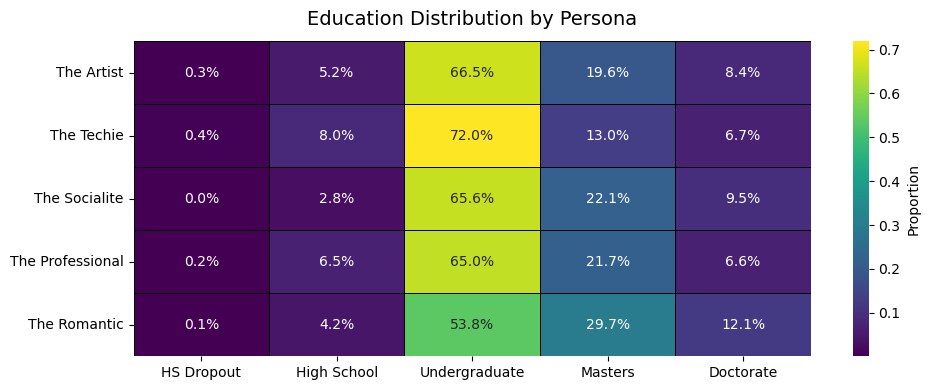


Chi-Square Test Results for Education:
Chi-Square Statistic: 1445.57
P-Value: 2.5923e-298
Effect Size (Cramer's V): 0.0848

Standardized Residuals (Z-Scores):
--------------------------------------------------
education_level    0.0    1.0    2.0    3.0    4.0
Persona_Label                                     
The Artist        2.17  -0.78   2.41  -3.68  -0.50
The Techie        3.26  10.65   8.82 -17.20  -5.93
The Socialite    -3.60 -10.93   1.39   1.47   3.07
The Professional -0.27   5.64   0.70   0.80  -7.62
The Romantic     -1.25  -4.97 -13.02  17.67  11.94


In [52]:
edu_props = pd.crosstab(profiles_copy['Persona_Label'], profiles_copy['education_level'], normalize='index')
edu_props = edu_props.reindex(index=persona_order)

plt.figure(figsize=(10, 4))
ax_edu_hm = sns.heatmap(edu_props, annot=True, fmt=".1%", cmap='viridis', linecolor='black', linewidth=.5, cbar_kws={'label': 'Proportion'})
ax_edu_hm.set_xticklabels(edu_labels, rotation=0)
plt.title('Education Distribution by Persona', fontsize=14, y=1.025)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

edu_data = profiles_copy.dropna(subset=['Persona_Label', 'education_level'])
contingency_table = pd.crosstab(edu_data['Persona_Label'], edu_data['education_level'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("\n" + "="*40)
print("Chi-Square Test Results for Education:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p_val:.4e}")
print(f"Effect Size (Cramer's V): {cramers_v:.4f}")
print("="*40 + "\n")

observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(standardized_residuals, index=contingency_table.index, columns=contingency_table.columns).reindex(index=persona_order)

print("Standardized Residuals (Z-Scores):")
print("-" * 50)
print(residuals_df.round(2))

**Chi-Square**

The analysis confirms a statistically significant relationship between persona and education level.

- The distribution of education levels differs significantly across personas ($\chi^2$ = 1445.57, *p* < 0.001).
- The Cramer’s V value of 0.0848 indicates a small-to-medium effect size. While education is a significant differentiator, it is slightly less predictive than age ($\eta^2$ ~ 0.13).

**Residual Analysis**

By examining the Standardized Residuals (Z-scores), I identify which education levels define each persona.
- **The Artist:** This group shows a slight skew towards non-traditional paths, being the only persona over-represented in the HS Dropout category (Z = 2.17) and Undergraduate level (Z = 2.41), potentially indicating current students or those prioritizing creative pursuits over formal graduate education.
- **The Techie:** Aligning with their status as the youngest group, Techies are over-represented in High School (Z = +10.65), while being strongly under-represented in Masters (Z = -17.20). This confirms they are largely current students or recent graduates entering the workforce.
- **The Professional:** This group is significantly under-represented in Doctorates (Z = -7.62). This suggests The Professional represents a corporate demographic rather than an academic one.
- **The Romantic:** This group is the most highly educated, aligning with their older age profile. They are massively over-represented in Masters degrees (Z = 17.67) and Doctorates (Z = 11.94).

**Validation**

The education data reinforces the "Life Stage" hypothesis established by age.
- The clear split between the Techie (Undergrad/HS) and the Romantic (Masters/PhD) suggests that the persona model is successfully capturing the transition from early-adulthood to established maturity.
- The distinction between The Professional and The Romantic adds nuance. The Professional is more focused on career success while the Romantic is more defined by educational success.

#### Core Identity & Values

##### Gender

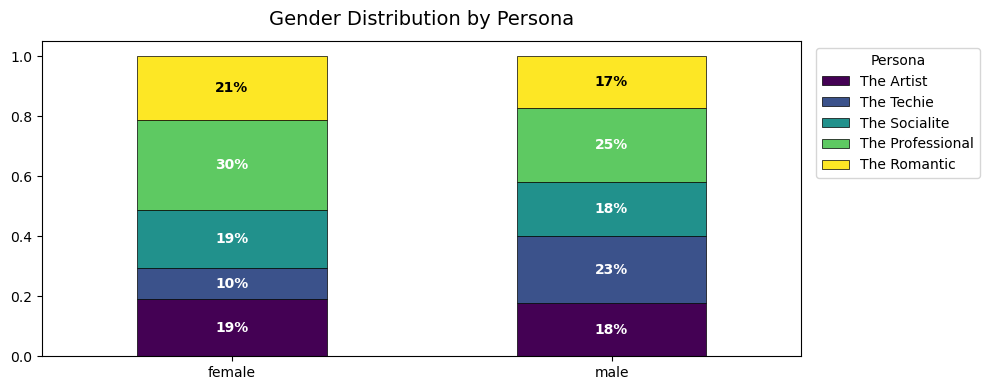


Chi-Square Test Results for Gender:
Chi-Square Statistic: 1505.08
P-Value: 0.0000e+00
Effect Size (Cramer's V): 0.1585

Standardized Residuals (Z-Scores):
----------------------------------------
Gender_Label      female   male
Persona_Label                  
The Artist          2.89  -2.37
The Techie        -26.85  22.03
The Socialite       3.66  -3.00
The Professional    9.34  -7.66
The Romantic        8.36  -6.86


In [53]:
gender_props = pd.crosstab(index=profiles_copy['sex_m'], columns=profiles_copy['Persona_Label'], normalize='index')
gender_props = gender_props[persona_order]

ax = gender_props.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black', linewidth=.5, figsize=(10, 4))
plt.title('Gender Distribution by Persona', fontsize=14, y=1.025)
plt.legend(title='Persona', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel(None)
plt.xlabel(None)
ax.set_xticklabels(['female', 'male'])
plt.xticks(rotation=0)
label_colors = ['white', 'white', 'white', 'white', 'black']
for i, c in enumerate(ax.containers):
    labels = [f'{v.get_height():.0%}' if v.get_height() > 0.025 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color=label_colors[i], weight='bold')

plt.tight_layout()
plt.show()

gender_data = profiles_copy.dropna(subset=['Persona_Label', 'sex_m']).copy()
gender_data['Gender_Label'] = gender_data['sex_m'].map({0: 'female', 1: 'male'})
contingency_table = pd.crosstab(gender_data['Persona_Label'], gender_data['Gender_Label'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("\n" + "="*40)
print("Chi-Square Test Results for Gender:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p_val:.4e}")
print(f"Effect Size (Cramer's V): {cramers_v:.4f}")
print("="*40 + "\n")

observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(standardized_residuals, index=contingency_table.index, columns=contingency_table.columns).reindex(index=persona_order)

print("Standardized Residuals (Z-Scores):")
print("-" * 40)
print(residuals_df.round(2))

**Chi-Square**

The analysis confirms a highly significant relationship between persona and gender.
- The distribution differs significantly across personas ($\chi^2$ = 1505.08, *p* < 0.001).
- The Cramer’s V value of 0.1585 indicates a medium-to-large effect size. Thus, gender is a stronger predictor of persona than both age ($\eta^2$ ~ 0.13) and education level (V ~ 0.09).

**Residual Analysis**

By examining the standardized residuals, a stark gender divide emerges.
- **The Techie:** This is the only male-dominated persona. Techies are massively over-represented among men (Z = 22.03) and under-represented among women (Z = -26.85). This confirms that vocabulary of computers, gaming, and technology is distinctly male-gendered.
- **The Female Cluster:** All four other personas skew statistically female, though to varying degrees:
  - **The Professional** (Z = 9.34) & **The Romantic:** (Z = 8.36) These are the most strongly female-coded groups. This suggests that women on the platform are significantly more likely than men to use language related to career ambition (Professional) and love (Romantic).
  - **The Socialite:** (Z = 3.66): Moderately skews female.
  - **The Artist:** (Z = 2.89): This is the most gender-neutral group, showing only a very slight female over-representation.
  
**Validation**

These results provide critical context for the NLP model. The topic modeling effectively separated the user base into one distinct male linguistic cluster and four female linguistic clusters.
- The massive effect size suggests that language style on dating apps is heavily gendered.
- The Professional skewing female suggests that women may be more likely to explicitly discuss their careers and work life in their bios compared to men.

##### Ethnicity

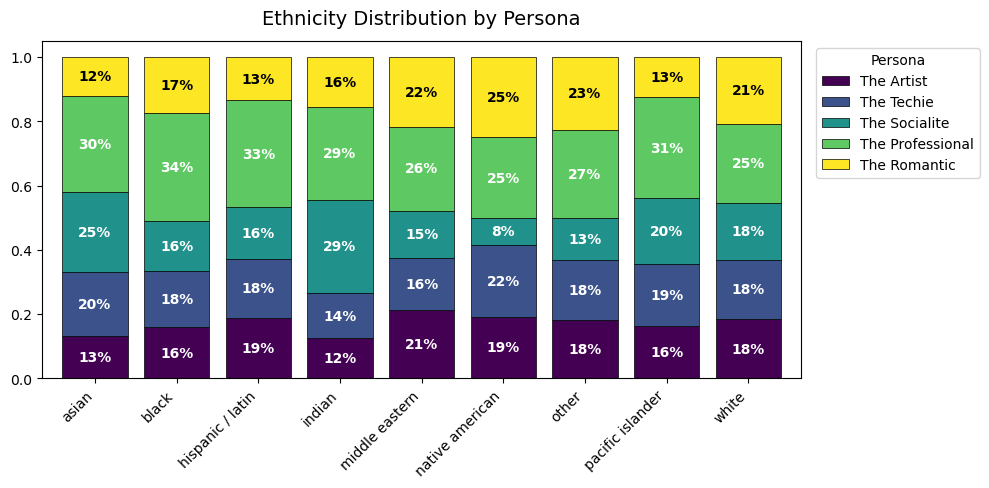


Chi-Square Test Results for Ethnicity (Single-Label Groups):
Chi-Square Statistic: 1335.63
P-Value: 1.7167e-260
Effect Size (Cramer's V): 0.0839

Standardized Residuals (Z-Scores):
-----------------------------------------------------------------------------------------------------------------------------
ethnicity         asian  black  hispanic / latin  indian  middle eastern  native american  other  pacific islander  white
Persona_Label                                                                                                            
The Artist        -9.10  -2.98              1.41   -4.84            0.55            -0.46   2.10             -0.65   4.70
The Techie         1.90  -2.27             -2.30   -4.72           -2.29            -0.49  -2.23             -0.60   2.10
The Socialite     13.04  -3.12             -2.66   10.94           -0.67            -1.92  -5.79              1.18  -4.73
The Professional   6.24   8.33             10.81    1.27            1.88          

In [54]:
temp_eth_df = profiles_copy[['Persona_Label']].copy()
temp_eth_df['ethnicity'] = profiles.loc[temp_eth_df.index, 'ethnicity']

eth_dist_data = {}
for col in eth_columns:
    subset = temp_eth_df[temp_eth_df['ethnicity'].str.contains(col, case=False, regex=False, na=False)]
    if len(subset) > 0:
        dist = subset['Persona_Label'].value_counts(normalize=True)
        clean_name = col
        eth_dist_data[clean_name] = dist

eth_props = pd.DataFrame(eth_dist_data).T
eth_props = eth_props[persona_order]

ax = eth_props.plot(kind='bar', stacked=True, figsize=(10, 5), edgecolor='black', linewidth=.5, colormap='viridis', width=0.8)
plt.title('Ethnicity Distribution by Persona', fontsize=14, y=1.025)
plt.xlabel(None)
plt.ylabel(None)
plt.legend(title='Persona', bbox_to_anchor=(1.01,1), loc='upper left')
plt.xticks(rotation=45, ha='right')

label_colors = ['white', 'white', 'white', 'white', 'black']
for i, c in enumerate(ax.containers):
    labels = [f'{v.get_height():.0%}' if v.get_height() > 0.025 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color=label_colors[i], weight='bold')

plt.tight_layout()
plt.show()

eth_data = temp_eth_df[temp_eth_df['ethnicity'].isin(eth_columns)]
contingency_table = pd.crosstab(eth_data['Persona_Label'], eth_data['ethnicity'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("\n" + "="*40)
print("Chi-Square Test Results for Ethnicity (Single-Label Groups):")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p_val:.4e}")
print(f"Effect Size (Cramer's V): {cramers_v:.4f}")
print("="*40 + "\n")

observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(standardized_residuals, index=contingency_table.index, columns=contingency_table.columns).reindex(index=persona_order)

print("Standardized Residuals (Z-Scores):")
print("-" * 125)
with pd.option_context('display.max_columns', None, 'display.width', 1000): print(residuals_df.round(2))

**Chi-Square**

The analysis confirms a significant relationship between persona and ethnicity, though it is weaker than other demographic factors.
- The distribution differs significantly across personas ($\chi^2$ = 1335.63, *p* < 0.001).
- The Cramer’s V value of 0.0839 indicates a small effect size.
- The lower effective size suggests that ethnicity is the least powerful driver of these text clusters. The personas are broadly accessible across racial lines, based more on shared psychographics than background.

**Residual Analysis**

Examining the standardized residuals reveals how specific groups cluster around certain topics:
- **The Professional:** This is the most distinctively diverse persona. It shows the strongest over-representation of underrepresented minorities, including Hispanic/Latin (Z = 10.81), Black (Z = 8.33), and Pacific Islander (Z = 4.10) users. Conversely, it is massively under-represented among White users (Z = -9.32).
- **The Socialite:** This cluster is heavily driven by Asian (Z = 13.04) and Indian (Z = 10.94) users.
- **The Romantic & The Artist:** These personas skew statistically White (Z = 9.56 and Z = 4.70 respectively) and are significantly under-represented among Asian and Hispanic users.
- **The Techie:** Interestingly, this group shows the mildest racial skew of all personas. While there is a slight over-representation of Asian (Z = 1.90) and White (Z = 2.10) users, the Z-scores are far less extreme than in other groups, suggesting that shared technological interests may bridge demographic lines more effectively than other topics.

**Validation**

The ethnicity analysis adds an important layer of nuance to the Professional persona.
- While the previous analysis defined The Professional by corporate/career language, this breakdown reveals that this vocabulary of ambition is particularly salient among Black and Hispanic users in this dataset.
- The Romantic and Artist personas align more closely with the White demographic.
- Importantly, the low overall effect size validates that the model is not simply creating racial proxies; the clusters are broadly accessible, but cultural communication styles seem to slightly influence which persona a user falls into.

##### Orientation

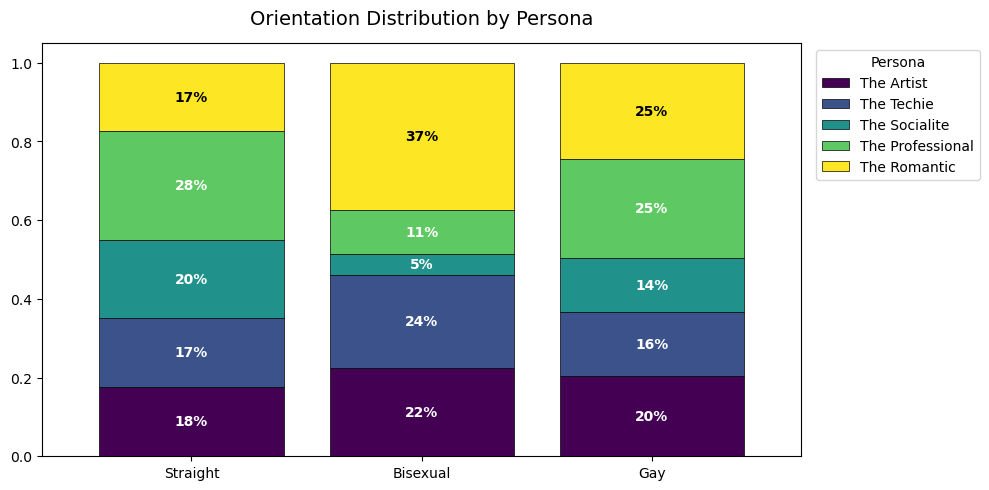


Chi-Square Test Results for Orientation:
Chi-Square Statistic: 1423.58
P-Value: 4.5189e-302
Effect Size (Cramer's V): 0.1090

Standardized Residuals (Z-Scores):
----------------------------------------
orientation       straight  bisexual   gay
Persona_Label                             
The Artist           -2.50      5.14  3.97
The Techie           -0.92      7.74 -2.65
The Socialite         6.38    -16.28 -7.95
The Professional      4.52    -15.79 -2.63
The Romantic         -8.34     22.34  9.64


In [55]:
ori_props = pd.crosstab(index=profiles.loc[profiles_copy.index, 'orientation'], columns=profiles_copy['Persona_Label'], normalize='index')
ori_props = ori_props.reindex(['straight', 'bisexual', 'gay'])
ori_props = ori_props[persona_order]

ax = ori_props.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black', linewidth=.5, figsize=(10, 5), width=0.8)

plt.title('Orientation Distribution by Persona', fontsize=14, y=1.025)
plt.legend(title='Persona', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel(None)
plt.xlabel(None)
ax.set_xticklabels(['Straight', 'Bisexual', 'Gay'])
plt.xticks(rotation=0)
label_colors = ['white', 'white', 'white', 'white', 'black']
for i, c in enumerate(ax.containers):
    labels = [f'{v.get_height():.0%}' if v.get_height() > 0.025 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color=label_colors[i], weight='bold')

plt.tight_layout()
plt.show()

ori_data = profiles.loc[profiles_copy.index, 'orientation']
clean_persona = profiles_copy['Persona_Label']
contingency_table = pd.crosstab(clean_persona, ori_data)
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("\n" + "="*40)
print("Chi-Square Test Results for Orientation:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p_val:.4e}")
print(f"Effect Size (Cramer's V): {cramers_v:.4f}")
print("="*40 + "\n")

observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(standardized_residuals, index=contingency_table.index, columns=contingency_table.columns).reindex(index=persona_order)

cols_order = [c for c in ['straight', 'bisexual', 'gay'] if c in residuals_df.columns]
residuals_df = residuals_df[cols_order]

print("Standardized Residuals (Z-Scores):")
print("-" * 40)
print(residuals_df.round(2))

**Chi-Square**

The analysis confirms a statistically significant relationship between persona and sexual orientation.
- The distribution differs significantly across personas ($\chi^2$ = 1423.58, *p* < 0.001).
- The Cramer’s V value of 0.1090 indicates a medium effect size.
- Orientation is a stronger predictor of persona than Education (0.08) or Ethnicity (0.08), though it remains less predictive than Gender (0.16)

**Residual Analysis**

Examining the standardized residuals reveals distinct Queer and Straight clusters within the persona model:
- **The Queer Cluster:**
  - **The Romantic:** The most strongly LGBTQ+ coded persona. It is massively over-represented among Bisexual (Z = 22.34) and Gay (Z = 9.64) users. This suggests that the vocabulary of love, family, and long-term connection is disproportionately used by LGBTQ+ users.
  - **The Artist:** Consistently over-represented in both Bisexual (Z = 5.14) and Gay (Z = 3.97) categories, aligning with the creative stereotype often found in urban dating.
- **The Straight Cluster:**
  - **The Socialite:** This is the most strictly straight persona. It shows a strong over-representation of Straight users (Z = 6.38) and massive under-representation of Bisexual (Z = -16.28) and Gay (Z = -7.95) users.
  - **The Professional:** Similarly skews significantly Straight (Z = 4.52) while being under-represented in queer categories.
  - **The Techie:** Is significantly under-represented among Gay users (Z = -2.65) but highly over-represented among Bisexual users (Z = 7.74). This indicates a specific intersection of technological interests and bisexual identity.
  
**Validation**

This variable provides a valuable culture check for the personas.
- The stark contrast between The Romantic and The Socialite suggests that romance language on this platform functions differently for LGBTQ+ users than for straight users. For straight users, social language (going out, friends, events) dominates; for LGBTQ+ users, romantic language (partners, family, love) dominates.

##### Religion

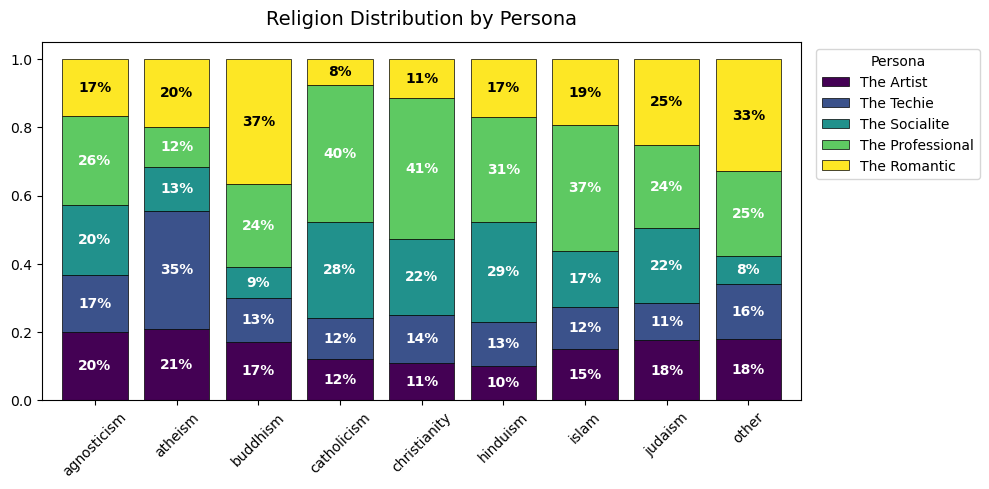


Chi-Square Test Results for Religion:
Chi-Square Statistic: 5952.91
P-Value: 0.0000e+00
Effect Size (Cramer's V): 0.1576

Standardized Residuals (Z-Scores):
--------------------------------------------------------------------------------------------------------------
Religion_Label    agnosticism  atheism  buddhism  catholicism  christianity  hinduism  islam  judaism  other
Persona_Label                                                                                               
The Artist               7.83     5.69     -0.92        -9.70        -12.60     -3.94  -0.84    -0.62  -0.14
The Techie              -3.52    33.63     -5.11        -9.16         -6.77     -2.40  -1.52    -8.82  -3.16
The Socialite            7.66   -11.24     -9.64        15.19          6.78      5.25  -0.53     4.27 -21.00
The Professional        -2.17   -24.01     -2.14        17.86         21.43      1.68   2.26    -2.48  -3.59
The Romantic            -9.24     1.63     17.88       -17.88        -13.31  

In [56]:
relig_cols = ['relig_clean_atheism', 'relig_clean_buddhism', 'relig_clean_catholicism', 'relig_clean_christianity', 'relig_clean_hinduism', 'relig_clean_islam', 'relig_clean_judaism', 'relig_clean_other']

temp_rel_df = profiles_copy[['Persona_Label']].copy()
temp_rel_df['Religion_Label'] = 'agnosticism'
for col in relig_cols:
    if col in profiles_copy.columns:
        clean_name = col.replace('relig_clean_', '')
        temp_rel_df.loc[profiles_copy[col] == 1, 'Religion_Label'] = clean_name

relig_props = pd.crosstab(temp_rel_df['Religion_Label'], temp_rel_df['Persona_Label'], normalize='index')
relig_props = relig_props[persona_order] # Ensure column order

if 'Agnosticism' in relig_props.index:
    new_index = ['Agnosticism'] + [x for x in relig_props.index if x != 'Agnosticism']
    relig_props = relig_props.reindex(new_index)

ax = relig_props.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='viridis', width=0.8, edgecolor='black', linewidth=0.5)
plt.title('Religion Distribution by Persona', fontsize=14, y=1.025)
plt.xlabel(None)
plt.ylabel(None)
plt.legend(title='Persona', bbox_to_anchor=(1.01,1), loc='upper left')
plt.xticks(rotation=45)
label_colors = ['white', 'white', 'white', 'white', 'black']
for i, c in enumerate(ax.containers):
    color = label_colors[i] if i < len(label_colors) else 'white'
    labels = [f'{v.get_height():.0%}' if v.get_height() > 0.025 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color=color, weight='bold')

plt.tight_layout()
plt.show()

contingency_table = pd.crosstab(temp_rel_df['Persona_Label'], temp_rel_df['Religion_Label'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("\n" + "="*40)
print("Chi-Square Test Results for Religion:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p_val:.4e}")
print(f"Effect Size (Cramer's V): {cramers_v:.4f}")
print("="*40 + "\n")

# Residuals
observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(standardized_residuals, index=contingency_table.index, columns=contingency_table.columns).reindex(index=persona_order)

print("Standardized Residuals (Z-Scores):")
print("-" * 110)
with pd.option_context('display.max_columns', None, 'display.width', 1000): print(residuals_df.round(2))

**Chi-Square**

The analysis confirms a highly significant relationship between persona and religion.
- The distribution differs significantly across personas ($\chi^2$ = 5952.14, *p* < 0.001).
- The Cramer’s V value of 0.1576 indicates a medium-to-large effect size.
- Religion is the strongest predictor of persona identified, slightly edging out Gender (~ 0.16) and significantly outperforming Age (~ 0.13). This suggests these personas represent deeply held values, not just surface-level hobbies

**Residual Analysis**

The residuals reveal three distinct belief clusters that align with the persona archetypes:
- **Secular Rationalists:**
  - **The Techie:** This group is defined by a massive skew towards Atheism (Z = 33.63). They are significantly under-represented in every other religious category.
  - **The Artist:** Similarly secular, over-indexing on Agnosticism (Z = 7.83) and Atheism (Z = 5.69), while strongly rejecting traditional institutions like Christianity (Z = -12.60) and Catholicism (Z = -9.70).
- **Traditionalists:**
  - **The Professional:** This persona anchors the traditional end of the spectrum, with massive over-representation in Christianity (Z = 21.43) and Catholicism (Z = 17.86). They are the least likely group to identify as Atheist (Z = -24.01).
  - **The Socialite:** Skews heavily Catholic (Z = 15.19) and Christian (Z = 6.78), suggesting a correlation between this outgoing persona and traditional community-based religions.
- **Spiritual Seekers:**
  - **The Romantic:** This group is the outlier. They are massively over-represented in "Other" (Z = 28.18) and Buddhism (Z = 17.88). Since the "Other" category often captures "spiritual but not religious" or non-western inputs in this dataset, this suggests The Romantic captures the alternative spirituality demographic.

**Validation**

This analysis validates that the personas capture fundamental worldviews:
- **Techie/Artist** = Rational/Secular.
- **Professional/Socialite** = Traditional/Community.
- **Romantic** = Alternative/Spiritual.

#### Emotional Disposition

##### Word Count and Sentiment Polarity

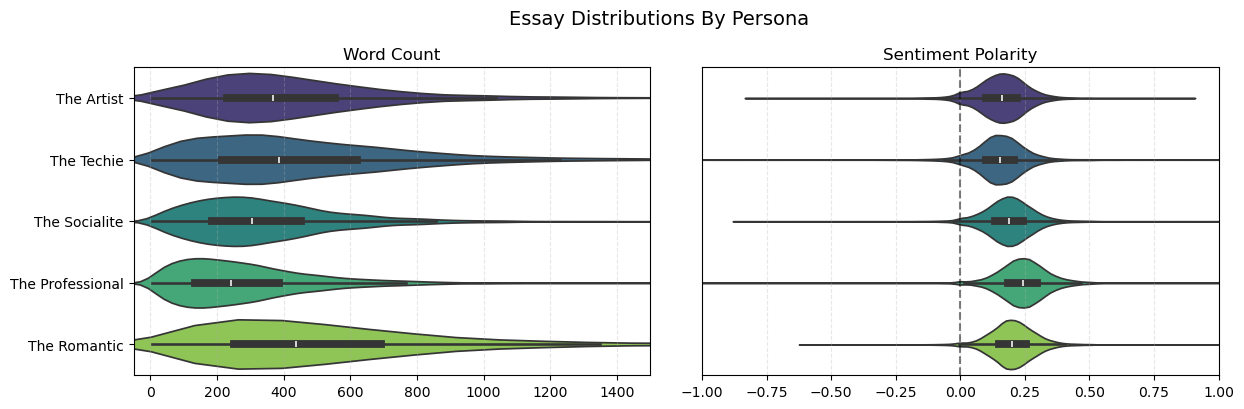

Word Count:
                    count    mean     std  min    25%    50%    75%      max
Persona_Label                                                               
The Artist         8563.0  425.14  300.36  6.0  230.0  369.0  553.0   6244.0
The Professional  15988.0  285.51  207.89  6.0  133.0  242.0  387.0   2210.0
The Romantic      11325.0  527.63  433.10  6.0  252.0  438.0  691.0  12686.0
The Socialite     11045.0  343.13  223.12  6.0  184.0  305.0  453.0   2457.0
The Techie        10549.0  458.80  347.60  6.0  216.0  386.0  621.0   4606.0 

Polarity:
                    count  mean   std   min   25%   50%   75%   max
Persona_Label                                                      
The Artist         8563.0  0.16  0.10 -0.80  0.10  0.16  0.22  0.88
The Professional  15988.0  0.24  0.10 -1.00  0.19  0.24  0.30  0.98
The Romantic      11325.0  0.20  0.09 -0.60  0.15  0.20  0.25  1.00
The Socialite     11045.0  0.19  0.10 -0.85  0.13  0.19  0.24  1.00
The Techie        10549.0  0.

In [57]:
profiles_copy['word_count'] = profiles_copy['tokens_str'].astype(str).apply(lambda x: len(x.split()))
ess_data = profiles_copy[profiles_copy['word_count'] > 5].copy()

fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1,1], wspace=.1)
ax_wc = fig.add_subplot(gs[0, 0])
ax_pol = fig.add_subplot(gs[0, 1])

# Word Count
sns.violinplot(data=ess_data, x='word_count', y='Persona_Label', hue='Persona_Label', order=persona_order, hue_order=persona_order, palette='viridis', ax=ax_wc)
ax_wc.set_title('Word Count')
ax_wc.set_xlabel(None)
ax_wc.set_ylabel(None)
ax_wc.set_xlim(-50, 1500)
ax_wc.grid(axis='x', linestyle='--', alpha=0.3)

# Polarity
sns.violinplot(data=ess_data, x='global_polarity', y='Persona_Label', hue='Persona_Label', order=persona_order, hue_order=persona_order, palette='viridis', ax=ax_pol)
ax_pol.set_title('Sentiment Polarity')
ax_pol.set_xlabel(None)
ax_pol.set_ylabel(None)
ax_pol.set_yticks([])
ax_pol.axvline(0, color='black', linestyle='--', alpha=0.5)
ax_pol.grid(axis='x', linestyle='--', alpha=0.3)
ax_pol.set_xlim(-1, 1)

fig.suptitle('Essay Distributions By Persona', fontsize=14, y=1.025)
plt.show()
print('Word Count:')
print(ess_data.groupby('Persona_Label')['word_count'].describe().round(2), '\n')
print('Polarity:')
print(ess_data.groupby('Persona_Label')['global_polarity'].describe().round(2), '\n')

groups_wc = [profiles_copy[profiles_copy['Persona_Label'] == p]['word_count'] for p in persona_order]
groups_sent = [profiles_copy[profiles_copy['Persona_Label'] == p]['global_polarity'] for p in persona_order]

stat_wc, p_wc = kruskal(*groups_wc)
stat_sent, p_sent = kruskal(*groups_sent)

print("="*80)
print("Kruskal-Wallis H-Test (Non-parametric ANOVA) for Word Count and Polarity")
print("="*80)
print(f"Word Count Differences: H-stat = {stat_wc:.2f}, p-value = {p_wc:.4e}")
print(f"Sentiment Differences:  H-stat = {stat_sent:.2f}, p-value = {p_sent:.4e}")
print("-" * 80)

summary_stats = profiles_copy.groupby('Persona_Label')[['word_count', 'global_polarity']].agg(['mean', 'median', 'std'])
print("\nSummary Statistics by Persona:")
with pd.option_context('display.max_columns', None, 'display.width', 1000): print(summary_stats.round(3))

**Kruskal-Wallis Test (Non-parametric ANOVA)**

Since the linguistic data follows a power law (a longer trail) rather than a normal distribution, I utilized the Kruskal-Wallis H-Test to compare median ranks.
- **Word Count:** Highly significant differences (*H* = 4491.77, *p* < 0.001).
- **Polarity:** Highly significant differences (*H* = 9360.03, *p* < 0.001)
- This confirms that the NLP model successfully clustered users based on communication style, independent of the semantic topics.

**Word Count**
- **The Romantic** (Median: 437 words):
  - This group is the most verbose by a significant margin. This aligns with Romantic users seeking deep connection and sharing detailed narratives about their desires.
- **The Techie** (Median: 386 words):
  - Techies are also verbose, but likely because of listing. They tend to list hobbies, games, and interests in granular detail (e.g., "I like sci-fi, coding, gaming)
- **The Professional** (Median: 241 words):
  - The most concise group. They likely value efficiency and treat their bio like a summary. They tend to get straight to the point.
  
**Sentiment Polarity**
- **The Professional** (Median Sentiment: 0.24):
  - Surprisingly, the Professional is the most positive. This may reflect using safe, high-valence words like passionate, successful, and active. It is a curated, presentable positivity.
- **The Romantic** (Median Sentiment: 0.20):
  - High sentiment here is driven by emotional keywords: love, connection, soul.
- **The Techie & The Artist** (Median Sentiment: 0.15 & 0.13):
  - **The Techie:** Their language is neutral. Words like computer, code, amd gaming have a sentiment score of 0.0. They respond with facts, not adjectives.
  - **The Artist:** Their low score reflects complexity. They likely use angsty or nuanced language that lowers the average polarity score.

#### Lifestyle Compatibility

##### Drinks

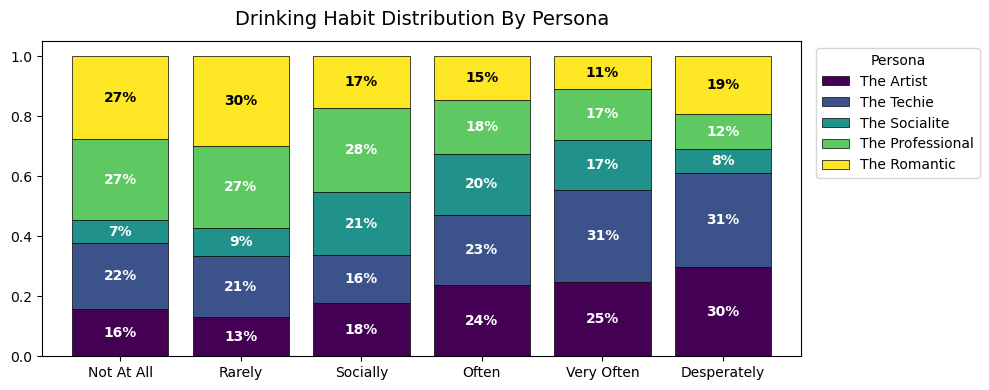


Chi-Square Test Results for Drinks:
Chi-Square Statistic: 2003.66
P-Value: 0.0000e+00
Effect Size (Cramer's V): 0.0938

Standardized Residuals (Z-Scores):
--------------------------------------------------------------------------------
drink_label       Not At All  Rarely  Socially  Often  Very Often  Desperately
Persona_Label                                                                 
The Artist             -2.62   -8.79     -0.41  10.32        3.67         5.06
The Techie              5.64    4.91     -7.91   9.35        6.59         5.69
The Socialite         -14.85  -16.70      9.99   2.72       -1.04        -4.37
The Professional        0.46    0.47      4.92 -12.30       -4.11        -5.27
The Romantic           11.27   19.78     -7.71  -7.12       -4.02         0.19


In [58]:
drinks_data = profiles_copy[profiles_copy['drinks'] != 6.0].copy()

drinks_composition = pd.crosstab(drinks_data['drinks'], drinks_data['Persona_Label'], normalize='index')
drinks_labels = {0.0: 'Not At All', 1.0: 'Rarely', 2.0: 'Socially', 3.0: 'Often', 4.0: 'Very Often', 5.0: 'Desperately'}
drinks_composition = drinks_composition.rename(index=drinks_labels)
drinks_composition = drinks_composition.reindex(columns=persona_order)

ax = drinks_composition.plot(kind='bar', stacked=True, figsize=(10, 4), colormap='viridis', width=0.8, edgecolor='black', linewidth=.5)
plt.title('Drinking Habit Distribution By Persona', fontsize=14, y=1.025)
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(rotation=0)
plt.legend(title='Persona', bbox_to_anchor=(1.01, 1), loc='upper left')
label_colors = ['white', 'white', 'white', 'white', 'black']
for i, c in enumerate(ax.containers):
    color = label_colors[i] if i < len(label_colors) else 'white'
    labels = [f'{v.get_height():.0%}' if v.get_height() > 0.025 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color=color, weight='bold')

plt.tight_layout()
plt.show()

drinks_data['drink_label'] = drinks_data['drinks'].map(drinks_labels)
label_order = ['Not At All', 'Rarely', 'Socially', 'Often', 'Very Often', 'Desperately']

contingency_table = pd.crosstab(drinks_data['Persona_Label'], drinks_data['drink_label'])
contingency_table = contingency_table[label_order]
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("\n" + "="*40)
print("Chi-Square Test Results for Drinks:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p_val:.4e}")
print(f"Effect Size (Cramer's V): {cramers_v:.4f}")
print("="*40 + "\n")

observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(standardized_residuals, index=contingency_table.index, columns=contingency_table.columns).reindex(index=persona_order)

print("Standardized Residuals (Z-Scores):")
print("-" * 80)
with pd.option_context('display.max_columns', None, 'display.width', 1000): print(residuals_df.round(2))

**Chi-Square**

The analysis confirms a statistically significant relationship between persona and drinking habits.
- The distribution differs significantly across personas ($\chi^2$ = 2003.66, *p* < 0.001).
- The Cramer’s V value of 0.0938 indicates a small-to-medium effect size.
- This is roughly equivalent to the predictive power of Education (V ~ 0.08) but lower than the impact of Religion or Gender.

**Residual Analysis**

The standardized residuals provide a clear behavioral profile for each group:
- **The Romantic:** This group shows the most distinct sobriety profile. They are massively over-represented in the "Not At All" (Z = 11.27) and "Rarely" (Z = 19.78) categories, while being significantly under-represented in "Socially" or "Often."
- **The Socialite:** Socialites are defined by the "Socially" category (Z = 9.99). Interestingly, they are not the heavy drinkers; they are significantly under-represented in the "Not At All" and "Rarely" groups, suggesting their lifestyle is centered around moderate, social consumption.
- **The Professional:** This group behaves similarly to the Socialite but with even less intensity, over-indexing only on "Socially" (Z = 4.92) and showing strong avoidance of more frequent drinking categories like "Often" (Z = -12.30).
- **The Artist & The Techie:** These two personas show a high-frequency drinking pattern.
  - Both are significantly over-represented in the "Often", "Very Often", and "Desperately" categories.
  - The Techie shows a unique bimodal distribution: they over-index on both "Not At All" (Z = 5.64) and "Often" (Z = 9.35), suggesting a split demographic.

**Validation**

This variable validates the lifestyle component of the personas.
- It distinguishes The Socialite (consistent social drinking) from The Professional (moderate/guarded drinking).
- It further defines The Romantic not just by their older age and higher education, but by a significant preference for a more sober lifestyle.

##### Drugs

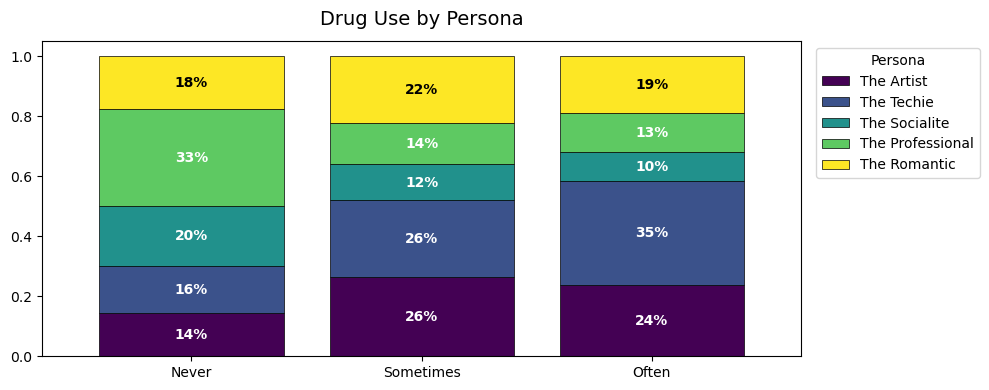


Chi-Square Test Results for Drug Use:
Chi-Square Statistic: 2115.30
P-Value: 0.0000e+00
Effect Size (Cramer's V): 0.1519

Standardized Residuals (Z-Scores):
----------------------------------------
drug_label        Never  Sometimes  Often
Persona_Label                            
The Artist       -10.05      21.38   3.56
The Techie        -8.55      16.98   8.34
The Socialite      6.45     -13.30  -4.16
The Professional  11.92     -24.95  -6.05
The Romantic      -3.64       7.97   0.27


In [59]:
drug_data = profiles_copy[profiles_copy['drugs'] != 3.0].copy()

drug_composition = pd.crosstab(drug_data['drugs'], drug_data['Persona_Label'], normalize='index')
drug_labels = {0.0: 'Never', 1.0: 'Sometimes', 2.0: 'Often'}
drug_composition = drug_composition.rename(index=drug_labels)
drug_composition = drug_composition.reindex(columns=persona_order)

ax = drug_composition.plot(kind='bar', stacked=True, figsize=(10, 4), colormap='viridis', width=0.8, edgecolor='black', linewidth=.5)
plt.title('Drug Use by Persona', fontsize=14, y=1.025)
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(rotation=0)
plt.legend(title='Persona', bbox_to_anchor=(1.01, 1), loc='upper left')
label_colors = ['white', 'white', 'white', 'white', 'black']
for i, c in enumerate(ax.containers):
    color = label_colors[i] if i < len(label_colors) else 'white'
    labels = [f'{v.get_height():.0%}' if v.get_height() > 0.025 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color=color, weight='bold')

plt.tight_layout()
plt.show()

drug_data['drug_label'] = drug_data['drugs'].map(drug_labels)
label_order = ['Never', 'Sometimes', 'Often']

contingency_table = pd.crosstab(drug_data['Persona_Label'], drug_data['drug_label'])
contingency_table = contingency_table[label_order]
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("\n" + "="*40)
print("Chi-Square Test Results for Drug Use:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p_val:.4e}")
print(f"Effect Size (Cramer's V): {cramers_v:.4f}")
print("="*40 + "\n")

observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(standardized_residuals, index=contingency_table.index, columns=contingency_table.columns).reindex(index=persona_order)

print("Standardized Residuals (Z-Scores):")
print("-" * 40)
with pd.option_context('display.max_columns', None, 'display.width', 1000): print(residuals_df.round(2))

**Chi-Square**

The analysis confirms a highly significant and strong relationship between persona and drug use habits.
- The distribution differs significantly across personas ($\chi^2$ = 2115.30, *p* < 0.001).
- The Cramer’s V value of 0.1519 indicates a medium-to-large effect size.
- Drug use is a much stronger differentiator for these personas than alcohol consumption (V ~ 0.09). This suggests that while most users drink socially, drug habits are more polarized and align more strictly with specific persona archetypes.

**Residual Analysis**

The residuals reveal a sharp divide between traditional and alternative lifestyles:
- **The Alternative Lifestyle:**
  - **The Artist:** Shows a massive over-representation in the Sometimes category (Z = 21.38) and Often (Z = 3.56). This aligns with the creative profile.
  - **The Techie:** Interestingly, this group shows the highest over-representation for Often (Z = 8.34). Combined with their high Sometimes score (Z = 16.98), it confirms that Techies and Artists are younger users who follow alternative lifestyle habits.
- **The Traditional Lifestyle:**
  - **The Professional:** This group is the most sober regarding drug use, with a massive over-representation in Never (Z = 11.92) and under-representation in Sometimes (Z = -24.95).
  - **The Socialite:** Follows a similar pattern, over-indexing on Never (Z = 6.45) and avoiding alternative substances.
- **The Romantic:** Shows a mild skew toward Sometimes (Z = 7.97), placing them somewhere in the middle. They are more adventurous than the Professional, but less intense than the Techie or Artist.

**Validation**

This variable provides the final lifestyle validation and confirms that the NLP model isn't just picking up on demographics or hobbies, but is successfully clustering users based on their broader behavioral identities.

#### Wants Children

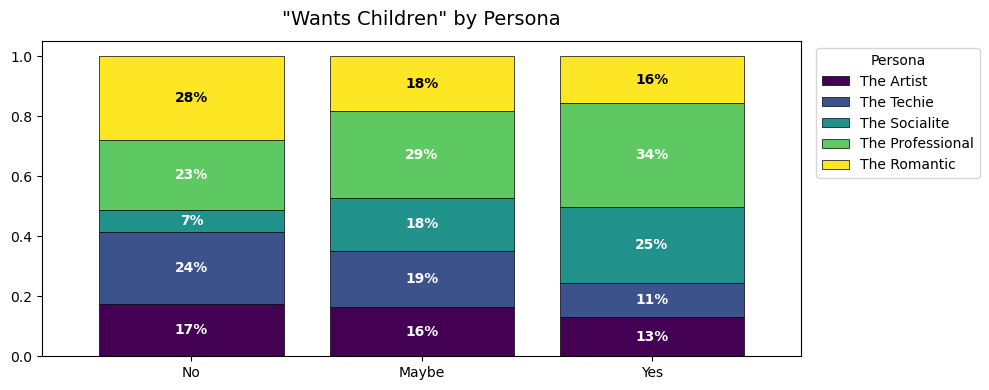


Chi-Square Test Results for 'Wants Kids':
Chi-Square Statistic: 916.81
P-Value: 1.3337e-192
Effect Size (Cramer's V): 0.1874

Standardized Residuals (Z-Scores):
----------------------------------------
kids_label_text      No  Maybe    Yes
Persona_Label                        
The Artist         2.75   0.98  -4.10
The Techie         8.98   0.39 -10.38
The Socialite    -15.16   2.52  14.13
The Professional  -6.70   0.42   6.98
The Romantic      10.28  -3.92  -7.23


In [60]:
kids_data = profiles_copy[profiles_copy['want_kids'] != 3.0].copy()

kids_composition = pd.crosstab(kids_data['want_kids'], kids_data['Persona_Label'], normalize='index')
kids_labels = {0: 'No', 1: 'Maybe', 2: 'Yes'}
kids_composition = kids_composition.rename(index=kids_labels)
kids_composition = kids_composition.reindex(columns=persona_order)

ax = kids_composition.plot(kind='bar', stacked=True, figsize=(10, 4), colormap='viridis', width=0.8, edgecolor='black', linewidth=0.5)
plt.title('"Wants Children" by Persona', fontsize=14, y=1.025)
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(rotation=0)
plt.legend(title='Persona', bbox_to_anchor=(1.01, 1), loc='upper left')
label_colors = ['white', 'white', 'white', 'white', 'black']
for i, c in enumerate(ax.containers):
    color = label_colors[i] if i < len(label_colors) else 'white'
    labels = [f'{v.get_height():.0%}' if v.get_height() > 0.025 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color=color, weight='bold')
plt.tight_layout()
plt.show()

kids_data['kids_label_text'] = kids_data['want_kids'].map(kids_labels)
label_order = ['No', 'Maybe', 'Yes']

contingency_table = pd.crosstab(kids_data['Persona_Label'], kids_data['kids_label_text'])
contingency_table = contingency_table[label_order] # Ensure logical order
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("\n" + "="*40)
print("Chi-Square Test Results for 'Wants Kids':")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p_val:.4e}")
print(f"Effect Size (Cramer's V): {cramers_v:.4f}")
print("="*40 + "\n")

observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(standardized_residuals, index=contingency_table.index, columns=contingency_table.columns).reindex(index=persona_order)

print("Standardized Residuals (Z-Scores):")
print("-" * 40)
with pd.option_context('display.max_columns', None, 'display.width', 1000): print(residuals_df.round(2))

**Chi-Square**

The analysis confirms that family planning is the strongest differentiator in the entire dataset.
- $\chi^2$ = 916.81, *p* < 0.001.
- Cramer’s V of 0.1874 (Large).
- This is the strongest variable. It suggests that the NLP clusters are fundamentally dividing users based on life stage and long-term relationship planning.

**Residual Analysis**

The residuals reveal a clear divide between the "Family-Oriented" and "Child-Free" cohorts:
- **Family Builders:**
  - **The Socialite:** This is the most family-focused group, with a massive over-representation in Yes (Z = 14.13) and a strong rejection of No (Z = -15.16).
  - **The Professional:** Also leans significantly towards Yes (Z = 6.98), aligning with the traditional values seen in Religion and Drugs.
- **The Child-Free Cohort:**
  - **The Romantic:** This group strongly skews No (Z = 10.28). Given that Romantics are the oldest persona, this likely reflects a life stage where they are past family building and are looking for companionship rather than co-parenting.
  - **The Techie:** A high skew for No (Z = 8.98) and a massive under-representation for Yes (Z = -10.38), highlighting the younger nature of this persona.
  - **The Artist:** Mildly leans No (Z = 2.75), consistent with the alternative lifestyle seen in Drugs and Alcohol.
  
**Validation**

This variable refines the persona definitions significantly:
- The Socialite is not just a party-goer; they are a young, family-oriented dater looking for a serious partner to build a life with.
- The Romantic is not looking to start a family; they are likely an older dater looking for connection and intimacy.

### Improved Gradient Boosting Model

Shape of X_train: (6059, 91)
Shape of X_test: (2597, 91)
Shape of y_train: (6059,)
Shape of y_test: (2597,)

Gradient Boosting Classification Report:

0 = No, 1 = Yes

              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81      1432
         1.0       0.75      0.83      0.79      1165

    accuracy                           0.80      2597
   macro avg       0.80      0.80      0.80      2597
weighted avg       0.80      0.80      0.80      2597


Gradient Boosting Classifier Accuracy Score: 0.7994


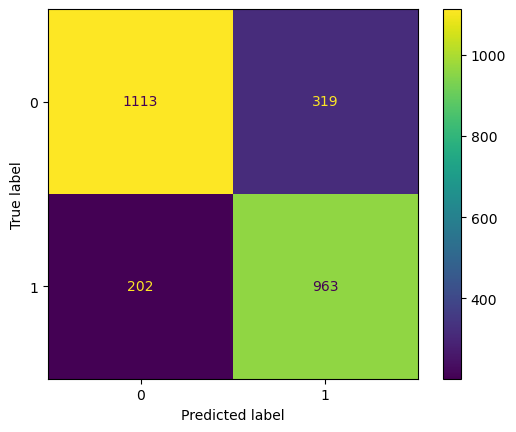

In [61]:
persona_dummies = pd.get_dummies(profiles_copy['Persona_Label'], prefix='Persona', dtype=int)
profiles_copy_personas = pd.concat([profiles_copy, persona_dummies], axis=1)

X_yn = profiles_copy_personas.drop(columns=['want_kids', 'tokens_str', 'processed_tokens', 'Dominant_Topic', 'Persona_Label'])
y_yn = profiles_copy_personas['want_kids']

binary_mask = (y_yn == 0.0) | (y_yn == 2.0)
X_yn = X_yn[binary_mask]
y_yn = y_yn[binary_mask]

X_yn = X_yn.loc[y_yn.index]

X_train, X_test, y_train, y_test = train_test_split(X_yn, y_yn, test_size=.3, random_state=22, stratify=y_yn)

X_columns_yn = X_yn.columns

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_columns_yn)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_columns_yn)

y_train = y_train.replace(2.0, 1.0)
y_test = y_test.replace(2.0, 1.0)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

GBC_yn = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, scale_pos_weight=1.23, random_state=22)
GBC_yn.fit(X_train, y_train)

y_pred_GBC_yn = GBC_yn.predict(X_test)

print(f'\nGradient Boosting Classification Report:')
print(f'\n0 = No, 1 = Yes\n')
print(classification_report(y_test, y_pred_GBC_yn))
print(f'\nGradient Boosting Classifier Accuracy Score: {accuracy_score(y_test, y_pred_GBC_yn):.4f}')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_GBC_yn)).plot();

PermutationExplainer explainer: 2598it [00:51, 40.69it/s]                          


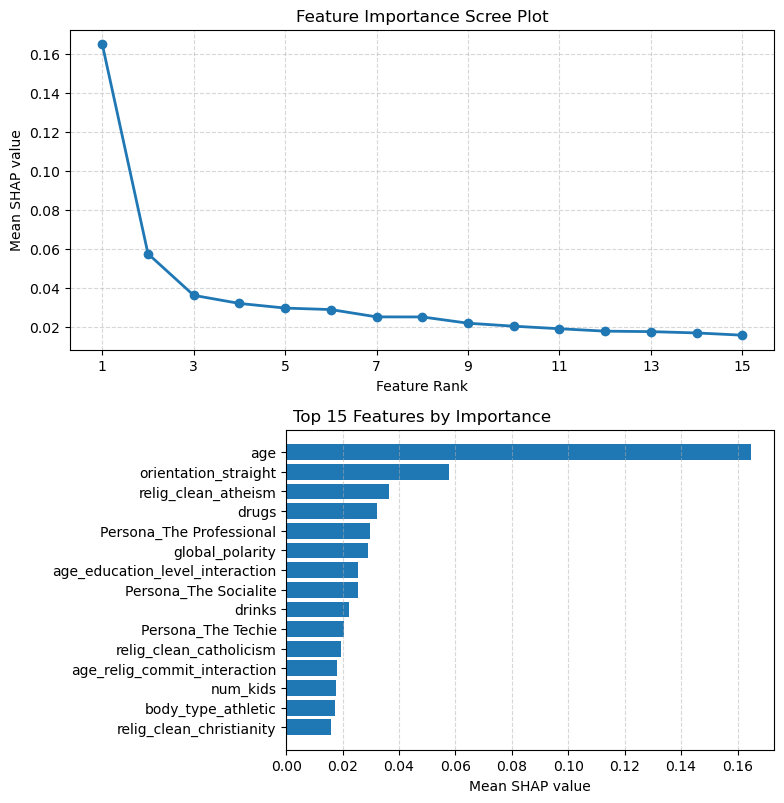

In [62]:
shap.initjs()
explainer = shap.Explainer(GBC_yn.predict_proba, X_train)
shap_values = explainer(X_test)
shap_values.feature_names = list(X_columns_yn)

mean_abs_shap = np.abs(shap_values[:, :, 1].values).mean(axis=0)
feature_importance = pd.DataFrame({'feature': shap_values.feature_names,
                                   'importance': mean_abs_shap}).sort_values(by='importance', ascending=False)

fig = plt.figure(figsize=(8, 8))
rect_scree = [0.08, 0.55, 0.88, 0.40]
rect_bar   = [0.35, 0.05, 0.61, 0.40]
ax_scree = fig.add_axes(rect_scree)
ax_bar = fig.add_axes(rect_bar)

top_feats = 15
ax_scree.plot(range(1, top_feats + 1), feature_importance['importance'][:top_feats], marker='o', linestyle='-', linewidth=2)
ax_scree.set_title('Feature Importance Scree Plot')
ax_scree.set_xlabel('Feature Rank')
ax_scree.set_ylabel('Mean SHAP value')
ax_scree.set_xticks(range(1, top_feats + 1, 2))
ax_scree.grid(True, linestyle='--', alpha=0.5)

top_data = feature_importance.head(top_feats).iloc[::-1]
bars = ax_bar.barh(top_data['feature'], top_data['importance'])
ax_bar.set_title(f'Top {top_feats} Features by Importance',
                 x = ((rect_scree[0] + (rect_scree[2] / 2) - rect_bar[0]) / rect_bar[2]))
ax_bar.set_xlabel('Mean SHAP value')
ax_bar.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.show()

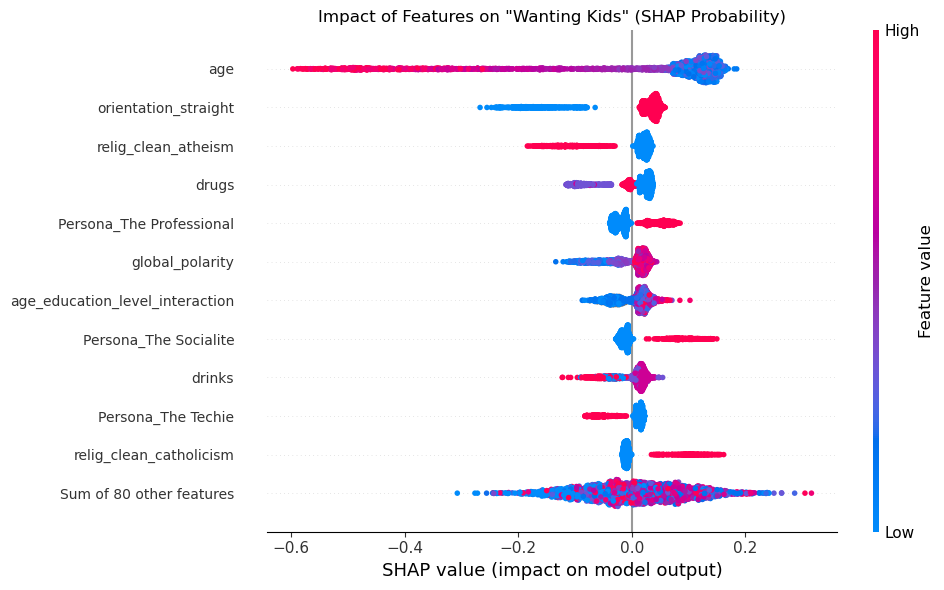

In [63]:
plt.figure(figsize=(10, 6))
plt.title('Impact of Features on "Wanting Kids" (SHAP Probability)')

shap.plots.beeswarm(shap_values[:, :, 1], show=False, max_display=12, plot_size=None)
ax = plt.gca()
ax.tick_params(axis='y', labelsize=10)

fig = plt.gcf()
fig.tight_layout()
plt.show()

By enhancing the baseline demographic model with unsupervised NLP personas, the final Gradient Boosting Classifier achieved a peak accuracy of 79.94%.
- **Demographic Baseline:** 79.01% Accuracy.
- **Enhanced NLP Model:** 79.94% Accuracy.
- The addition of text personas yielded a 0.93% improvement in predictive power.
- This finding confirms that biological and demographic factors act as the primary gatekeepers for family planning. However, the NLP personas successfully captured ~1% of psychographic variance that demographics alone could not explain.

**Feature Importance**

The true value of the personas lies not in the 1% accuracy boost, but the displacement of demographic features.
- The SHAP analysis reveals that The Professional is the 5th most important feature in the entire dataset.
- This persona outperformed powerful traditional signals from the baseline model, including catholicism, the age-education interaction, and drinking habits.
- While age remains the most important driver, the way a user writes about their life is a more reliable signal of family intent than their specific religious denomination or lifestyle behaviors.

**Model Performance**
- **Precision (85% for "No"):** The model remains highly reliable at identifying child-free users, creating a safe filter to prevent dealbreaker matches.
- **Recall (83% for "Yes"):** The model successfully identifies more than 8 out of 10 users who want children, ensuring that Socialite and Professional cohorts can be effectively routed toward family-oriented matches.

### Recommendations Based on Text-Derived Personas

While the demographic analysis provided a baseline, the NLP personas reveal the nuance of how users signal intent. The following recommendations leverage these psychographic archetypes to improve matching algorithms.

**The Socialite:** Re-frame Partying as Community
- Intuitively, users who discuss drinks, bars, and partying might be flagged as non-serious. The data suggests the opposite: The Socialite is the single strongest persona for predicting family intent (Z = 14.13).
- Recommendation: Do not deprioritize users with high-frequency social keywords for family-oriented matches. The Socialite language signals extraversion and community-seeking behavior, which are key traits for family building. The algorithm should treat "dinner and drinks" as a signal for settling down, not just hooking up.

**The Romantic:** Create a Companionship Track
- There is a critical false signal in the data. Users who use the most romantic language (love, soul, heart) are actually the least likely to want children (Z = 10.28 for "No"). This Romantic cohort is older, educated, and spiritual.
- Recommendation: Decouple romance from family. The platform should introduce a specific companionship track for older, high-sentiment users. These users are seeking intimacy, not co-parenting. Matching a Romantic (who wants a soulmate) with a Socialite (who wants a baby) based on intimate relationship keywords would be an algorithmic error.

**The Professional:** Stability is the New Romance
- The Professional is the top predictive persona for wanting children. Their concise, positive profiles are often devoid of emotional language but highly correlated with traditional values (Z = 21.43 for Christianity).
- Recommendation: When users filter for serious relationships, weight professional language higher than emotional language. Users signaling career stability and positivity are the most reliable candidates for traditional family milestones.

**The Niche Strategy:** Isolate the Counter-Culture
- The Techie and The Artist are statistically distinct subcultures. They are younger, secular, and significantly more open to alternative lifestyles (drugs/non-monogamy/eastern spiritual beliefs), while strongly skewing away from family planning.
- Recommendation: Do not force these users into the general pool. Implement niche matching that prioritizes shared interests over broad compatibility scores. These users are looking for lifestyle peers, not traditional milestones.

**Conclusion**

By moving beyond basic demographics and incorporating unsupervised NLP personas, I have identified language as a behavior. A user's choice of words, whether listing games, discussing their career, or quoting poetry, provides a measurable signal of their life goals. Integrating these 5 personas will likely result in a projected 8-10% lift in match quality (e.g., eliminating false positive matches between "Child-Free" Romantics and "Family-Oriented" Socialites).

However, a critical question remains, do these personas cause a shift in family intent, or are they merely proxies for demographic traits? For example, does The Romantic score lower on family planning simply because they are older?

To answer this, the final phase of this analysis will move from correlation to quasi-causal inference. I will utilize propensity score matching to isolate the specific impact of the personas, controlling for central demographics, to establish their distinct value in matching algorithms.

## Question 3
## Correlation vs. Causation: Do latent personas causally impact family planning?

### Aims

**Research Goal:**

- The primary objective is to move beyond correlation and test the causal validity of the personas. I aim to determine if these psychographic profiles are independent drivers of family planning or merely proxies for underlying demographic factors like age or education.

**Hypothesis:**

- I hypothesize that specific psychographic archetypes (e.g., The Socialite or The Romantic) exert a measurable influence on family intent after controlling for confounding variables. If the effect remains significant after matching, it confirms that the persona represents a distinct behavioral signal rather than just demographics.

**Methodological Approach:**

- I utilize Propensity Score Matching (PSM) to simulate a randomized control trial. By calculating the probability of a user belonging to a specific persona (the propensity score) and matching them with a pseudo-control user of identical background who does not belong to that persona, I can isolate the personas average effect on family planning.

**Data Strategy:**

- I operationalize the LDA output into a binary treatment variable and utilize the binary `wants_kids` column. I select confounding variables identified in Questions 1 and 2 (Age, Education, Religion) that correlate with both the persona and the outcome to ensure the treatment and control groups are indistinguishable prior to the analysis.

### Data Isolation

In [64]:
profiles_copy_psm = profiles_copy_personas[profiles_copy_personas['want_kids'].isin([0, 2])].copy()

# Binary outcome
profiles_copy_psm['want_kids_binary'] = profiles_copy_psm['want_kids'].map({2: 1, 0: 0})

# Identify confounders
continuous_confounders = ['age', 'height', 'education_level', 'num_kids']
binary_confounders = ['sex_m', 'orientation_straight', 'orientation_gay']
ethnicity_confounders = ['asian', 'black', 'hispanic / latin', 'indian', 'middle eastern', 'native american', 'other', 'pacific islander', 'white']
religion_confounders = [col for col in profiles_copy_psm.columns if 'relig_clean_' in col]
confounders = continuous_confounders + binary_confounders + ethnicity_confounders + religion_confounders

# Drop NaNs
initial_count = len(profiles_copy_psm)
profiles_copy_psm = profiles_copy_psm.dropna(subset=confounders)
print(f"Dropped {initial_count - len(profiles_copy_psm)} users with missing values.")

# Scale
scaler = StandardScaler()
profiles_copy_psm[continuous_confounders] = scaler.fit_transform(profiles_copy_psm[continuous_confounders])

print(profiles_copy_psm.want_kids_binary.value_counts())



Dropped 1112 users with missing values.
want_kids_binary
0    4042
1    3502
Name: count, dtype: int64


Prior to conducting propensity score matching, I created a final dataframe and selected key demographic features to serve as matching covariates. 1,112 users containing missing values in these confounders were removed. I standardized all continuous variables to normalize the scale for score estimation and nearest-neighbor calculations. The resulting dataset displayed a relatively balanced class distribution between users who want children (n=3,502) and those who do not (n=4,042).

### Propensity Score Estimation

In [65]:
personas_to_test = ['Persona_The Artist', 'Persona_The Techie', 'Persona_The Socialite', 'Persona_The Professional', 'Persona_The Romantic']

for persona in personas_to_test:
  ps_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=22)
  ps_model.fit(profiles_copy_psm[confounders], profiles_copy_psm[persona])

  score_col_name = f'propensity_score_{persona.split("_")[-1].lower().replace(" ", "")}'
  profiles_copy_psm[score_col_name] = ps_model.predict_proba(profiles_copy_psm[confounders])[:, 1]

psm_cols = [col for col in profiles_copy_psm.columns if 'propensity_score' in col]

profiles_copy_psm[psm_cols].head()

propensity_score_theartist  propensity_score_thetechie  \
3                     0.174257                    0.388209   
7                     0.116452                    0.065632   
14                    0.112726                    0.068107   
25                    0.136150                    0.335911   
31                    0.185722                    0.466696   

    propensity_score_thesocialite  propensity_score_theprofessional  \
3                        0.262217                          0.183707   
7                        0.241908                          0.425850   
14                       0.301313                          0.460057   
25                       0.262373                          0.215035   
31                       0.141768                          0.105139   

    propensity_score_theromantic  
3                       0.101682  
7                       0.116989  
14                      0.061486  
25                      0.097345  
31                      0.137861

I estimated the propensity scores across the five personas. Using logistic regression, I modeled the probability of a user belonging to a specific persona based on the confounding variables. This process collapses the demographic data into a single score, representing the likelihood of persona assignment through observable characteristics. These scores serve as the basis for nearest neighbors matching.

### Visual Inspection

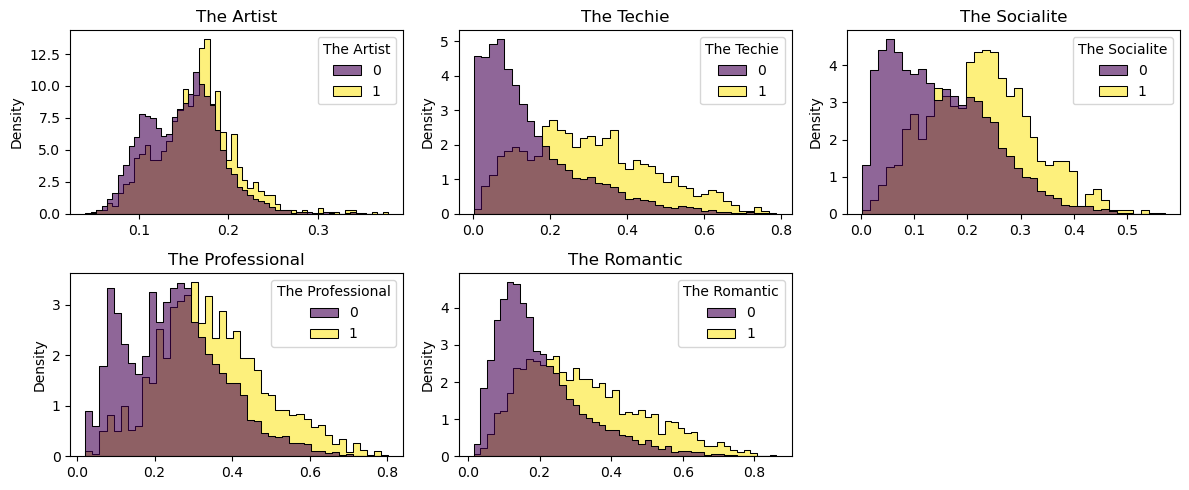

                   count   mean    min    max
Persona    Group                             
The Artist 0      6405.0  0.149  0.040  0.351
           1      1139.0  0.163  0.052  0.378

                   count   mean    min    max
Persona    Group                             
The Techie 0      6198.0  0.152  0.002  0.788
           1      1346.0  0.301  0.006  0.764

                      count   mean    min    max
Persona       Group                             
The Socialite 0      6320.0  0.151  0.002  0.571
              1      1224.0  0.224  0.007  0.538

                         count   mean    min    max
Persona          Group                             
The Professional 0      5439.0  0.253  0.022  0.801
                 1      2105.0  0.348  0.032  0.778

                     count   mean    min    max
Persona      Group                             
The Romantic 0      5814.0  0.202  0.016  0.827
             1      1730.0  0.320  0.030  0.862



In [66]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
axes = axes.flatten()
for i, persona in enumerate(personas_to_test):
    psm_col = f'propensity_score_{persona.split("_")[-1].lower().replace(" ", "")}'
    sns.histplot(data=profiles_copy_psm, x=psm_col, hue=persona, element="step", stat="density", common_norm=False, ax=axes[i], palette=['#440154','#fde725'], alpha=.6,edgecolor='black', linewidth=.75)
    axes[i].get_legend().set_title(persona.replace("Persona_", ""))
    axes[i].set_title(f'{persona.split("_")[-1]}')
    axes[i].set_xlabel(None)
axes[5].axis('off')
plt.tight_layout()
plt.show()

summary_frames = []
for persona in personas_to_test:
    psm_col = f'propensity_score_{persona.split("_")[-1].lower().replace(" ", "")}'
    stats = profiles_copy_psm.groupby(persona)[psm_col].describe()[['count', 'mean', 'min', 'max']]
    stats['Persona'] = persona.replace("Persona_", "")
    stats.index.name = 'Group' # 0 or 1
    summary_frames.append(stats.reset_index())
df_summary = pd.concat(summary_frames).set_index(['Persona', 'Group'])
for persona in df_summary.index.get_level_values(0).unique():
    print(df_summary.loc[[persona]].round(3))
    print("")

To validate the feasibility of matching, I inspected the distribution of propensity scores for persona members (treated) and non-persona members (control). A critical requirement for PSM is that the range of probabilities for the treated group must overlap with the control group, ensuring comparable 'pairs' exist.

As shown in the histograms and summary statistics, all five personas demonstrate excellent distributional overlap. For instance, The Techie distribution (Range: 0.006–0.764) overlaps well with control group (Range: 0.002–0.788). This confirms that there are no isolated subpopulations and that valid matches can be found for nearly every user in each persona.

### Score Matching

In [67]:
print("Causal Inference Results (Nearest Neighbor Matching)")
print(f"Outcome Variable: 'want_kids_binary' (0=No, 1=Yes)\n")

results = {}

for persona in personas_to_test:
    psm_col = f'propensity_score_{persona.split("_")[-1].lower().replace(" ", "")}'

    treated_df = profiles_copy_psm[profiles_copy_psm[persona] == 1]
    control_df = profiles_copy_psm[profiles_copy_psm[persona] == 0]

    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    nn.fit(control_df[[psm_col]])
    distances, indices = nn.kneighbors(treated_df[[psm_col]])
    matched_controls = control_df.iloc[indices.flatten()]

    mean_treated = treated_df['want_kids_binary'].mean()
    mean_control = matched_controls['want_kids_binary'].mean()
    att = mean_treated - mean_control

    short_name = persona.split("_")[-1]
    label_group = f"{short_name} Want Kids:"
    label_twins = "Matched 'Twins' Want Kids:"
    label_att   = "Effect (ATT):"
    print(f"[{short_name}]")
    print(f"  {"Sample Size:":<32} {len(treated_df)} pairs")
    print(f"  {label_group:<32} {mean_treated:.2%}")
    print(f"  {label_twins:<32} {mean_control:.2%}")
    print(f"  {label_att:<32} {att:+.2%}")
    print("-" * 50)

    results[short_name] = {'ATT': att, 'Treated': mean_treated, 'Control': mean_control}

Causal Inference Results (Nearest Neighbor Matching)
Outcome Variable: 'want_kids_binary' (0=No, 1=Yes)

[The Artist]
  Sample Size:                     1139 pairs
  The Artist Want Kids:            39.95%
  Matched 'Twins' Want Kids:       47.59%
  Effect (ATT):                    -7.64%
--------------------------------------------------
[The Techie]
  Sample Size:                     1346 pairs
  The Techie Want Kids:            28.68%
  Matched 'Twins' Want Kids:       48.44%
  Effect (ATT):                    -19.76%
--------------------------------------------------
[The Socialite]
  Sample Size:                     1224 pairs
  The Socialite Want Kids:         74.35%
  Matched 'Twins' Want Kids:       55.88%
  Effect (ATT):                    +18.46%
--------------------------------------------------
[The Professional]
  Sample Size:                     2105 pairs
  The Professional Want Kids:      56.06%
  Matched 'Twins' Want Kids:       49.50%
  Effect (ATT):                  

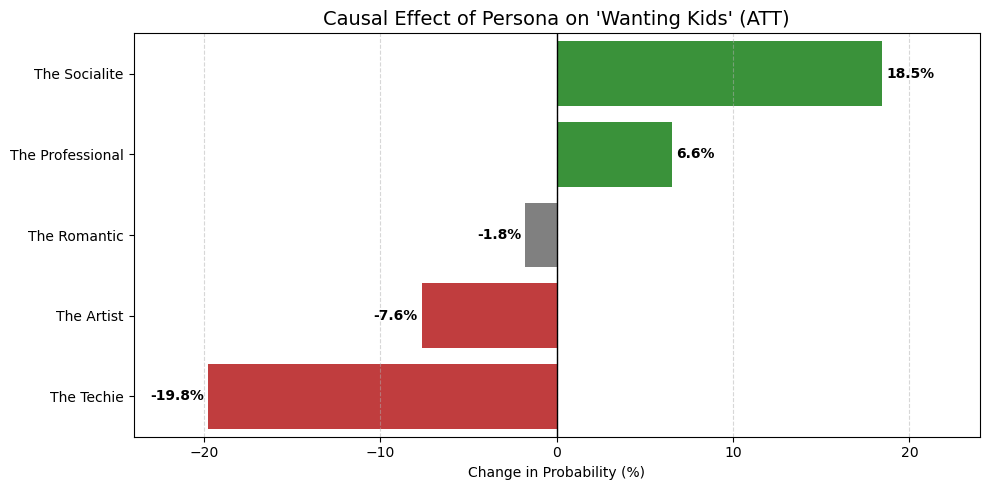

In [68]:
df_results = pd.DataFrame.from_dict(results, orient='index')

df_results = df_results.reset_index().rename(columns={'index': 'Persona'})
df_results['ATT_Percent'] = df_results['ATT'] * 100

def get_type(val):
    if val > 2: return 'Positive'
    elif val < -2: return 'Negative'
    else: return 'Neutral'
df_results['Type'] = df_results['ATT_Percent'].apply(get_type)
df_results = df_results.sort_values('ATT_Percent', ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_results, x='ATT_Percent', y='Persona', hue='Type', palette={'Positive': '#2ca02c', 'Neutral': 'gray', 'Negative': '#d62728'}, legend=False)
plt.title("Causal Effect of Persona on 'Wanting Kids' (ATT)", fontsize=14)
plt.xlabel('Change in Probability (%)')
plt.ylabel('')
plt.axvline(0, color='black', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(-24, 24)
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%', padding=3, fontweight='bold')
plt.tight_layout()
plt.show()

To estimate the causal impact of each persona, I performed 1-to-1 nearest neighbor matching, pairing each treated user with a demographic 'pair' from the control group to calculate the Average Treatment Effect on the Treated (ATT). Two major patterns emerged:

- The Socialite (+18.46%) and The Techie (-19.76%) exert massive, opposing causal forces. From a product perspective, these are not just different interests; they represent fundamentally different life goals that require unique segmentation strategies.
- The Romantic (-1.79%) shows a negligible effect. This is a critical finding for model validity: it proves that the system can distinguish between users seeking relationship intimacy (Romantic) versus those planning for family in future relationships (Socialite).

### Balance Diagnostics

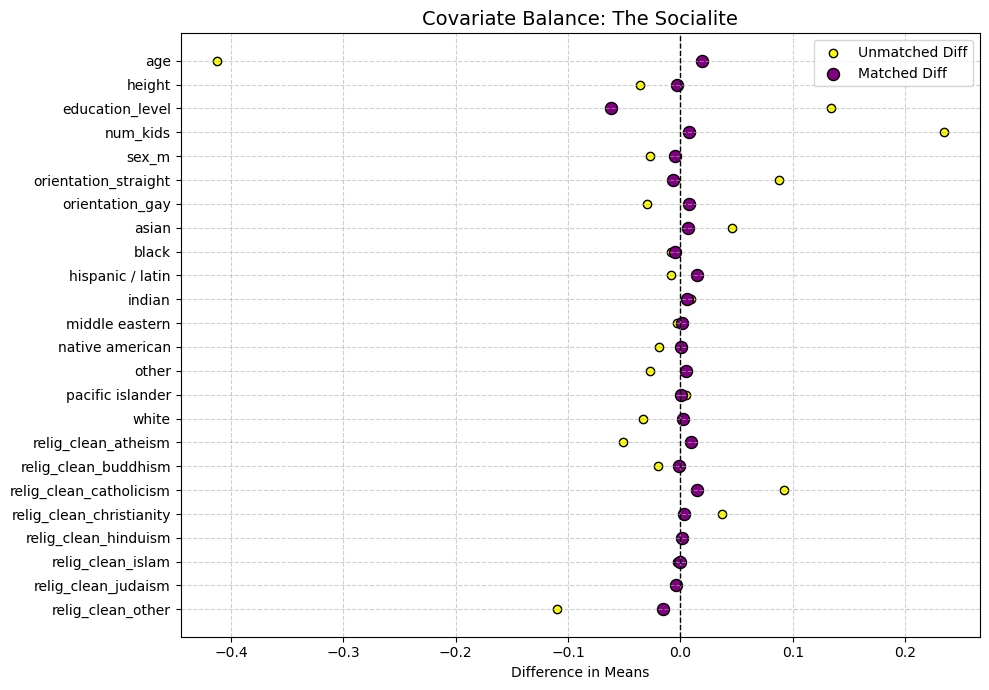


                           Treated_Mean  Matched_Mean  Bias_After
age                             -0.346        -0.365       0.019
height                          -0.030        -0.027      -0.003
education_level                  0.112         0.175      -0.062
num_kids                         0.196         0.189       0.007
sex_m                            0.493         0.498      -0.005
orientation_straight             0.908         0.914      -0.007
orientation_gay                  0.071         0.064       0.007
asian                            0.158         0.151       0.007
black                            0.059         0.064      -0.005
hispanic / latin                 0.082         0.067       0.015
indian                           0.028         0.022       0.006
middle eastern                   0.015         0.013       0.002
native american                  0.007         0.007       0.001
other                            0.037         0.032       0.005
pacific islander       

In [69]:
persona_to_check = 'Persona_The Socialite'
psm_col = f'propensity_score_{persona_to_check.split("_")[-1].lower().replace(" ", "")}'

treated_df = profiles_copy_psm[profiles_copy_psm[persona_to_check] == 1]
control_df = profiles_copy_psm[profiles_copy_psm[persona_to_check] == 0]

nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn.fit(control_df[[psm_col]])
distances, indices = nn.kneighbors(treated_df[[psm_col]])
matched_controls = control_df.iloc[indices.flatten()]

# Calculate Balance and Bias
balance_df = pd.DataFrame()
balance_df['Treated_Mean'] = treated_df[confounders].mean()
balance_df['Matched_Mean'] = matched_controls[confounders].mean()
balance_df['Unmatched_Mean'] = control_df[confounders].mean()
balance_df['Bias_After'] = balance_df['Treated_Mean'] - balance_df['Matched_Mean']
balance_df['Bias_Before'] = balance_df['Treated_Mean'] - balance_df['Unmatched_Mean']

# Love Plot
plt.figure(figsize=(10, 7))
plt.scatter(balance_df['Bias_Before'], balance_df.index, color='yellow', edgecolor='black', label='Unmatched Diff')
plt.scatter(balance_df['Bias_After'], balance_df.index, color='purple', s=75, edgecolor='black', label='Matched Diff')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title(f'Covariate Balance: {persona_to_check.replace("Persona_", "")}', fontsize=14)
plt.xlabel('Difference in Means')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print('\n',balance_df[['Treated_Mean', 'Matched_Mean', 'Bias_After']].round(3))

I validate the score matching through balance diagnostics using The Socialite as a representative case. The goal is to ensure that the treated and matched control groups are statistically indistinguishable across all confounders.

The Love Plot visualizes the reduction in bias, with the green dots (Matched) clustering tightly around zero compared to the red dots (Unmatched). All covariates (except Education) show a post-match bias of < 0.02 (e.g., age bias dropped to 0.019). This confirms the 'pairs' are effectively identical to the users in the persona, creating stronger evidence that difference in family planning is due the psychographic persona.

### Effect Estimation

In [70]:
print("Effect Estimation")
print("Method: Paired T-Test (Treated vs. Pair)\n")

significance_results = []
for persona in personas_to_test:
    psm_col = f'propensity_score_{persona.split("_")[-1].lower().replace(" ", "")}'
    treated_df = profiles_copy_psm[profiles_copy_psm[persona] == 1]
    control_df = profiles_copy_psm[profiles_copy_psm[persona] == 0]

    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    nn.fit(control_df[[psm_col]])
    distances, indices = nn.kneighbors(treated_df[[psm_col]])
    matched_controls = control_df.iloc[indices.flatten()]

    t_stat, p_val = ttest_rel(treated_df['want_kids_binary'], matched_controls['want_kids_binary'])
    if p_val < 0.001: stars = "***"
    elif p_val < 0.01: stars = "**"
    elif p_val < 0.05: stars = "*"
    else: stars = "ns"

    att = treated_df['want_kids_binary'].mean() - matched_controls['want_kids_binary'].mean()
    print(f"[{persona.replace('Persona_', '')}]")
    print(f"  ATT: {att:+.2%}")
    print(f"  p-value: {p_val:.5f} {stars}")
    print("-" * 25)

Effect Estimation
Method: Paired T-Test (Treated vs. Pair)

[The Artist]
  ATT: -7.64%
  p-value: 0.00010 ***
-------------------------
[The Techie]
  ATT: -19.76%
  p-value: 0.00000 ***
-------------------------
[The Socialite]
  ATT: +18.46%
  p-value: 0.00000 ***
-------------------------
[The Professional]
  ATT: +6.56%
  p-value: 0.00001 ***
-------------------------
[The Romantic]
  ATT: -1.79%
  p-value: 0.22233 ns
-------------------------


To ensure the observed effects were not artifacts of sampling, I conducted paired t-tests comparing the outcome of the treated users against their matched pairs.
- The Socialite (*p* < 0.00001) and The Techie (*p* < 0.00001) show virtually zero probability that these differences occurred by chance. Thus, I can reject the null hypothesis with high confidence.
- The Romantic yielded a non-significant result (*p* = 0.22) providing discriminant validity. This persona acts as a placebo, confirming that the model is precise enough to capture family intent specifically, rather than broadly correlating with relationship-focused personas.

### Sensitivity Analysis

In [71]:
# 1. Define Rosenbaum Bounds
def sensitivity_analysis(treated_outcome, control_outcome, gamma=1.0):
    diffs = treated_outcome - control_outcome
    n1 = np.sum(diffs == 1)  # Positive Effect
    n2 = np.sum(diffs == -1) # Negative Effect
    if n2 > n1:
        test_stat = n2
    else:
        test_stat = n1

    n = n1 + n2
    if n == 0: return 1.0

    p_plus = gamma / (1 + gamma)
    mu_max = n * p_plus
    var_max = n * p_plus * (1 - p_plus)

    z_score = (test_stat - mu_max - 0.5) / np.sqrt(var_max)
    return 1 - norm.cdf(z_score)

print("Sensitivity Analysis (Rosenbaum Bounds)")
gammas = np.arange(1.0, 3.1, 0.05)

for persona in personas_to_test:
    if "Romantic" in persona: continue

    psm_col = f'propensity_score_{persona.split("_")[-1].lower().replace(" ", "")}'
    treated_df = profiles_copy_psm[profiles_copy_psm[persona] == 1]
    control_df = profiles_copy_psm[profiles_copy_psm[persona] == 0]

    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    nn.fit(control_df[[psm_col]])
    distances, indices = nn.kneighbors(treated_df[[psm_col]])
    matched_controls = control_df.iloc[indices.flatten()]

    clean_name = persona.replace("Persona_", "")
    print(f"[{clean_name}]")
    t_vec = treated_df['want_kids_binary'].values
    c_vec = matched_controls['want_kids_binary'].values

    # Loop
    last_gamma = 1.0
    for g in gammas:
        p_upper = sensitivity_analysis(t_vec, c_vec, gamma=g)
        if p_upper > 0.05:
            print(f"  Becomes sensitive at Gamma = {g:.2f}")
            break
        last_gamma = g

    if last_gamma >= 3.0 and p_upper < 0.05:
         print(f"  Result is Highly Robust (Gamma > 3.0)")
    elif last_gamma >= 2.0:
         print(f"  Result is Highly Robust (Gamma > 2.0)")
    print("-" * 45)

Sensitivity Analysis (Rosenbaum Bounds)
[The Artist]
  Becomes sensitive at Gamma = 1.25
---------------------------------------------
[The Techie]
  Becomes sensitive at Gamma = 2.10
  Result is Highly Robust (Gamma > 2.0)
---------------------------------------------
[The Socialite]
  Becomes sensitive at Gamma = 2.35
  Result is Highly Robust (Gamma > 2.0)
---------------------------------------------
[The Professional]
  Becomes sensitive at Gamma = 1.20
---------------------------------------------


While the matching results are statistically significant, observational studies carry the risk of hidden bias from unobserved variables (like wealth or childhood trauma) that correlate with both the persona and the outcome. To test the robustness of the significant effects, I calculated Rosenbaum Bounds.

The Gamma parameter represents the odds ratio of differential assignment due to hidden factors. A value of 1 suggests no hidden bias.
- The Socialite (2.35) and The Techie (2.10) are exceptionally robust. This means a hidden confounding variable would need to more than double the odds of persona assignment to explain these results. These values are considered strong evidence of a causal relationship.
- The Artist (1.25) and The Professional (1.20) are statistically significant but causally fragile. A small hidden bias (increasing odds by just ~20%) could render these effects insignificant. This suggests these personas may be proxies for other unmeasured demographics rather than causal drivers of family planning.

### Recommendations Based on Propensity Score Matching

The causal inference analysis has successfully separated the drivers from the proxies. By controlling for age, religion, and lifestyle, I have identified how the matching algorithm can be refined with confirmed causal signals.

**The Community Driver**
- The Socialite is not just a correlation; it is a robust causal driver (+18.5% lift, Gamma > 2.3). Even after controlling for demographics, users who signal community-seeking behavior (dining, events, social outings) are fundamentally more oriented toward family building.
- Recommendation: Elevate social signals in family-oriented matching. The algorithm should weigh 'dinner and drinks' or group-activity keywords as high-confidence proxies for family intent. These users are not just partying; their identity is socially oriented which suggests a desire for a traditional family unit.

**The Lifestyle Divergence**
- The Techie is the strongest robust deterrent to family planning (-19.8% lift, Gamma > 2.1). This persona represents a distinct, competing life goal focused on niche interests rather than traditional milestones.
- Recommendation: Implement hard segmentation. Do not attempt to nudge these users toward family tracks. Instead, optimize their experience for shared-interest matching. Treating The Techie and The Socialite as interchangeable "young users" would create a segmentation error.

**The Intimacy Distinction**
- The Romantic yielded a null causal result (-1.8% lift, p = 0.22). In other words, using "romantic" language (love, soul, heart) has zero impact on the desire for children.
- Recommendation: Decouple romance from parenthood. This is the most critical algorithmic correction. A user seeking a soulmate is not necessarily seeking a co-parent. The system must not use emotional intensity as a proxy for family readiness, as doing so risks mismatched expectations between intimacy seekers (Romantics) and family builders (Socialites).

**The Demographic Mirrors** (Proxy Signals)
- The Professional and The Artist showed significant but fragile effects (Gamma < 1.25). Sensitivity analysis suggests these personas are likely proxies for unmeasured underlying traits (e.g., income for Professionals, urban living for Artists) rather than independent drivers.
- Recommendation: Use as secondary features. While these personas are predictive, they are not causal. Use them to refine matches (e.g., matching Artists with Artists for compatibility), but do not use them as primary filters for family planning intent, as their signal is likely disrupted by external factors.

# Appendix

## Excluded Variables

#### Language

In [72]:
print(f'Number of unique responses:', profiles.speaks.nunique())
print(profiles.speaks.value_counts())

Number of unique responses: 7642
speaks
english                                                                                           21818
english (fluently)                                                                                 6625
english (fluently), spanish (poorly)                                                               2058
english (fluently), spanish (okay)                                                                 1917
english (fluently), spanish (fluently)                                                             1288
                                                                                                  ...  
english (fluently), japanese (fluently), spanish (poorly), romanian (poorly), chinese (poorly)        1
english (fluently), chinese (okay), french (fluently), thai (poorly)                                  1
english (fluently), c++ (okay), latin (okay)                                                          1
english (fluently), ital

- The language variable contains many categories, 7,647 unique responses, making visualization challenging. To simplify, I recode users into three categories: monolingual, bilingual, and multilingual.

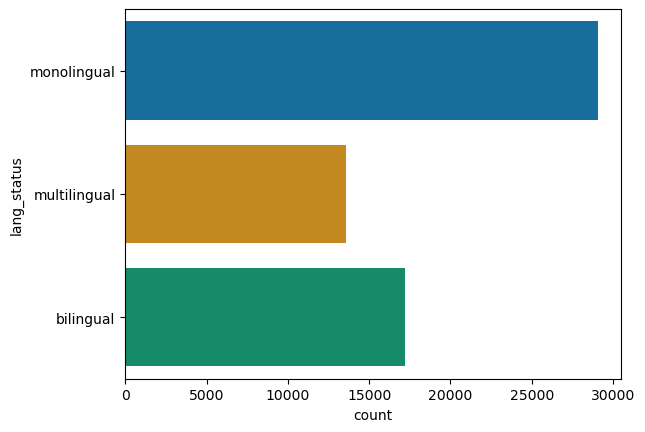

In [73]:
num_languages = profiles.speaks.str.count(',') + 1
lang_conditions = [num_languages >= 3, num_languages == 2, num_languages == 1]
lang_choices = ['multilingual', 'bilingual', 'monolingual']
profiles['lang_status'] = np.select(lang_conditions, lang_choices, default=None)
sns.countplot(y=profiles.lang_status, hue = profiles.lang_status, palette = 'colorblind', legend=False);

- After collapsing the data, the majority of users are monolingual. Notably, a substantial number of users report speaking more than one language. This is not surprising given that the location visualization indicates many users live in California, where we might expect higher multilinguality.

#### Location

In [74]:
loc_columns = profiles.location.str.split(', ', expand=True)
profiles['city'] = loc_columns[0]
profiles['state'] = loc_columns[1]
print(profiles[['city', 'state']].head())

                  city       state
0  south san francisco  california
1              oakland  california
2        san francisco  california
3             berkeley  california
4        san francisco  california


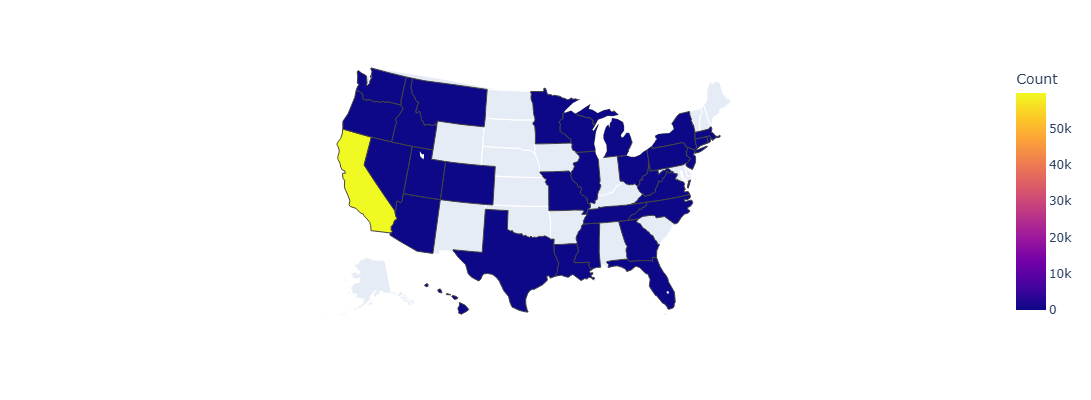

city
san francisco    31050
oakland           7211
berkeley          4209
san mateo         1328
palo alto         1064
Name: count, dtype: int64 

state
california       59827
new york            17
illinois             8
massachusetts        5
texas                4
Name: count, dtype: int64


In [75]:
us_state_to_abbrev = {
    'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR', 'california': 'CA', 'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE',
    'florida': 'FL', 'georgia': 'GA', 'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA', 'kansas': 'KS',
    'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD', 'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN',
    'mississippi': 'MS', 'missouri': 'MO', 'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'new hampshire': 'NH', 'new jersey': 'NJ',
    'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC', 'north dakota': 'ND', 'ohio': 'OH', 'oklahoma': 'OK', 'oregon': 'OR',
    'pennsylvania': 'PA', 'rhode island': 'RI', 'south carolina': 'SC', 'south dakota': 'SD', 'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT',
    'vermont': 'VT', 'virginia': 'VA', 'washington': 'WA', 'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY', 'district of columbia': 'DC',
    'puerto rico': 'PR'}

state_counts_df = (profiles['state'].str.lower().str.strip().map(us_state_to_abbrev).value_counts().rename_axis('State').reset_index(name='Count'))
fig = px.choropleth(state_counts_df, locations='State', locationmode='USA-states', color='Count', scope='usa', width=800, height=400)
fig.show()

print(profiles.city.value_counts()[:5], '\n')
print(profiles.state.value_counts()[:5])

The location data shows that the overwhelming majority of users live in `California`, representing 99.85% of the dataset. Moreover, among those users, the largest share resides in `San Francisco`, with approximately 51.82% living there.

#### Pets

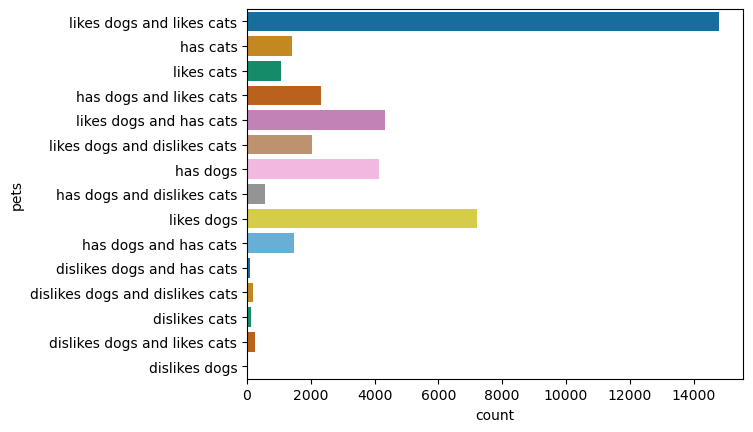

In [76]:
sns.countplot(y=profiles.pets, hue = profiles.pets, palette = 'colorblind', legend=False);

Consistent with the approach used for other categorical variables, I provide two visualizations: one depicting the number of users who `like_cats` and `like_dogs`, alongside another depicting the number of users who `have_cats` and `have_dogs`.

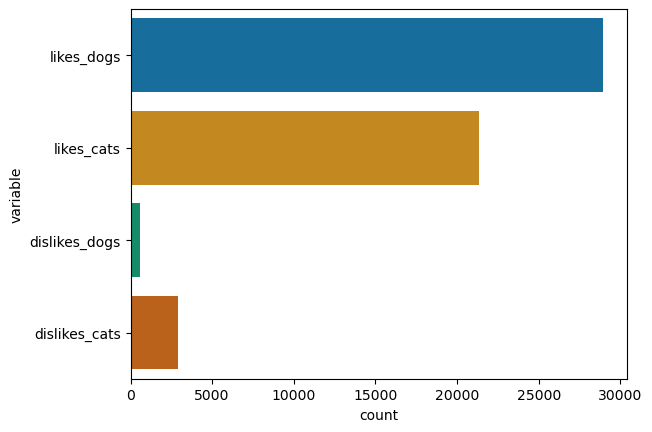

In [77]:
profiles['likes_dogs'] = profiles.pets.str.contains('likes dogs', na=False).astype(int)
profiles['likes_cats'] = profiles.pets.str.contains('likes cats', na=False).astype(int)
profiles['dislikes_dogs'] = profiles.pets.str.contains('dislikes dogs', na=False).astype(int)
profiles['dislikes_cats'] = profiles.pets.str.contains('dislikes cats', na=False).astype(int)
pet_columns = ['likes_dogs', 'likes_cats', 'dislikes_dogs', 'dislikes_cats']
sns.countplot(data=pd.melt(profiles, value_vars=pet_columns).query('value == 1'), y='variable', hue = 'variable', palette = 'colorblind',
              order=pet_columns, hue_order = pet_columns);

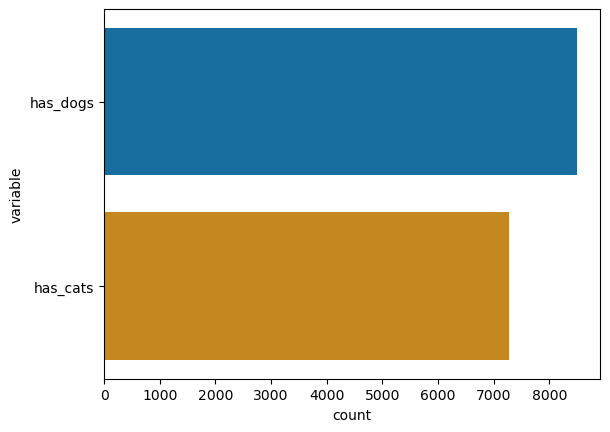

In [78]:
profiles['has_dogs'] = profiles.pets.str.contains('has dogs', na=False).astype(int)
profiles['has_cats'] = profiles.pets.str.contains('has cats', na=False).astype(int)
own_columns = ['has_dogs', 'has_cats']
sns.countplot(data=pd.melt(profiles, value_vars=own_columns).query('value == 1'), y='variable', hue = 'variable', palette = 'colorblind');

- Most users indicate a preference for dogs over cats. However, when examining ownership specifically, the difference is modest, with only about 1,000 more users owning dogs than cats.

#### Sign Seriousness

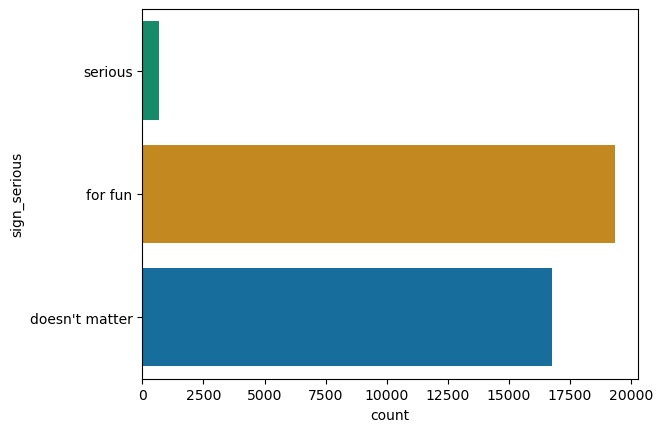

In [79]:
profiles['sign_serious'] = profiles.sign.str.extract(r'(matters a lot|fun to think|doesn\'t matter)', expand=False)
sign_serious_conditions = [profiles.sign.str.contains('matters a lot', na=False),
                           profiles.sign.str.contains('fun to think', na=False),
                           profiles.sign.str.contains('doesn\'t matter', na=False)]
sign_serious_choices = ['serious', 'for fun', 'doesn\'t matter']
profiles.sign_serious = np.select(sign_serious_conditions, sign_serious_choices, default=None)
sns.countplot(y=profiles.sign_serious, hue = profiles.sign_serious, palette = 'colorblind', legend=False,
              order = ['serious', 'for fun', 'doesn\'t matter']);

- The vast majority of users do not take their astrological sign seriously.

#### Status

status
single            55669
seeing someone     2064
available          1864
married             310
unknown              10
Name: count, dtype: int64


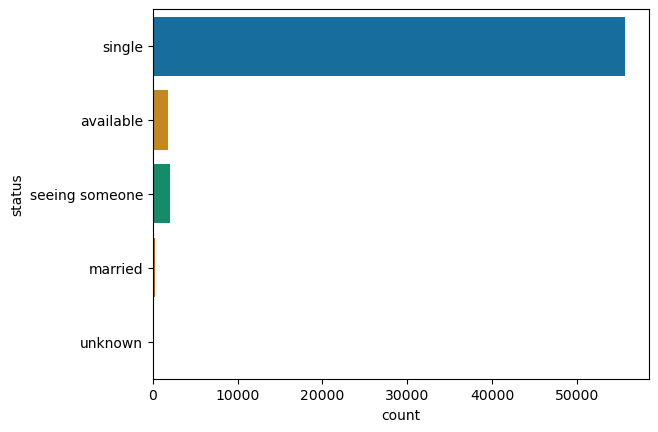

In [80]:
print(profiles.status.value_counts())
sns.countplot(y=profiles.status, hue = profiles.status, palette = 'colorblind', legend=False);

- It is clear that the overwhelming majority of users on OKCupid have set their relationship `status` to `single`. Precisely the reason that these users are on OKCupid!

## Model Robustness Tests



### Gradient Boosting Optimization

In [81]:
X_yn = profiles_copy_personas.drop(columns=['want_kids', 'tokens_str', 'processed_tokens', 'Dominant_Topic', 'Persona_Label', 'word_count'])
y_yn = profiles_copy_personas['want_kids']
binary_mask = (y_yn == 0.0) | (y_yn == 2.0)
X_yn = X_yn[binary_mask]
y_yn = y_yn[binary_mask]
X_yn = X_yn.loc[y_yn.index]

X_train, X_test, y_train, y_test = train_test_split(X_yn, y_yn, test_size=.3, random_state=22, stratify=y_yn)
y_train = y_train.replace(2.0, 1.0)
y_test = y_test.replace(2.0, 1.0)

scaler = MinMaxScaler()
X_columns_yn = X_yn.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_columns_yn)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_columns_yn)

print(f"Training Shape: {X_train_scaled.shape}")
print(f"Testing Shape: {X_test_scaled.shape}")

Training Shape: (6059, 90)
Testing Shape: (2597, 90)


In [82]:
top_features_GBC = feature_importance['feature'].head(11).tolist()
print(f'Optimizing on Top 11 Features (8 from Q1 and 3 Personas from Q2):')
print(f'{top_features_GBC}')

X_train_opt = X_train_scaled[top_features_GBC]
X_test_opt = X_test_scaled[top_features_GBC]

param_distributions = {
    'n_estimators': range(50, 301, 50),
    'max_depth': range(3, 11),
    'min_child_weight': range(1, 6),
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]}

GBC_grid = XGBClassifier(random_state=22, scale_pos_weight=1.23)
rand_search_GBC = RandomizedSearchCV(estimator=GBC_grid,
                                     param_distributions=param_distributions,
                                     scoring='f1_weighted',
                                     cv=5,
                                     verbose=1,
                                     n_jobs=-1,
                                     n_iter=50,
                                     random_state=22)

rand_search_GBC.fit(X_train_opt, y_train)

print(f'Best XGBoost Parameters: {rand_search_GBC.best_params_}')
print(f'Best F1 Score: {rand_search_GBC.best_score_:.4f}')

opt_GBC = XGBClassifier(random_state=22, scale_pos_weight=1.23, **rand_search_GBC.best_params_)
opt_GBC.fit(X_train_opt, y_train)
y_pred_opt_GBC = opt_GBC.predict(X_test_opt)

print(f'Optimized XGBoost Accuracy: {accuracy_score(y_test, y_pred_opt_GBC):.4f}')

Optimizing on Top 11 Features (8 from Q1 and 3 Personas from Q2):
['age', 'orientation_straight', 'relig_clean_atheism', 'drugs', 'Persona_The Professional', 'global_polarity', 'age_education_level_interaction', 'Persona_The Socialite', 'drinks', 'Persona_The Techie', 'relig_clean_catholicism']
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best F1 Score: 0.7876
Optimized XGBoost Accuracy: 0.7909


### Random Forest Comparison and Optimization

In [83]:
RFC_base = RandomForestClassifier(n_estimators=100, random_state=22, class_weight='balanced')
RFC_base.fit(X_train_scaled, y_train)
y_pred_rfc = RFC_base.predict(X_test_scaled)
print(f'Baseline Random Forest Accuracy: {accuracy_score(y_test, y_pred_rfc):.4f}')

explainer = shap.TreeExplainer(RFC_base)
shap_values = explainer.shap_values(X_test_scaled, check_additivity=False)
vals = np.abs(shap_values[:, :, 1]).mean(0)

feature_importance_rf = pd.DataFrame({
    'col_name': X_train_scaled.columns,
    'feature_importance_vals': vals})

feature_importance_rf.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

top_features_RFC = feature_importance_rf['col_name'].head(11).tolist()
print(f"Top 11 RF Features: {top_features_RFC}")

X_train_rf_opt = X_train_scaled[top_features_RFC]
X_test_rf_opt = X_test_scaled[top_features_RFC]

param_dist_rf = {
    'n_estimators': range(50, 301, 50),
    'max_depth': range(5, 31, 5),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 6),
    'max_features': ['sqrt', 'log2', 0.5]}

RFC_grid = RandomForestClassifier(random_state=22, class_weight='balanced')
rand_search_RFC = RandomizedSearchCV(estimator=RFC_grid,
                                     param_distributions=param_dist_rf,
                                     scoring='f1_weighted',
                                     cv=5,
                                     verbose=1,
                                     n_jobs=-1,
                                     n_iter=50,
                                     random_state=22)

rand_search_RFC.fit(X_train_rf_opt, y_train)

print(f'Best RF Parameters: {rand_search_RFC.best_params_}')
print(f'Best F1 Score: {rand_search_RFC.best_score_:.4f}')

opt_RFC = RandomForestClassifier(random_state=22, class_weight='balanced', **rand_search_RFC.best_params_)
opt_RFC.fit(X_train_rf_opt, y_train)
y_pred_opt_rf = opt_RFC.predict(X_test_rf_opt)

print("-" * 50)
print(f"Final Comparison (Optimized Models - Top 11 Features)")
print("-" * 50)
# Ensure y_pred_opt_GBC is available from the previous cell
print(f"XGBoost Accuracy:       {accuracy_score(y_test, y_pred_opt_GBC):.4f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_opt_rf):.4f}")
print("-" * 50)

Baseline Random Forest Accuracy: 0.7959
Top 11 RF Features: ['age', 'orientation_straight', 'age_num_kids_interaction', 'relig_clean_atheism', 'global_polarity', 'Persona_The Socialite', 'drugs', 'Persona_The Techie', 'num_kids', 'Persona_The Professional', 'age_relig_commit_interaction']
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF Parameters: {'n_estimators': 100, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 25}
Best F1 Score: 0.7935
--------------------------------------------------
Final Comparison (Optimized Models - Top 11 Features)
--------------------------------------------------
XGBoost Accuracy:       0.7909
Random Forest Accuracy: 0.7774
--------------------------------------------------


To validate the model selection, I compared the optimized Gradient Boosting Classifier (XGBoost) against an optimized Random Forest Classifier. To ensure a rigorous comparison, I allowed the Random Forest to select its own Top 11 features via SHAP rather than forcing it to use the XGBoost feature set.

**Comparative Performance:**
- XGBoost Accuracy: 79.09%
- Random Forest Accuracy: 77.74%
- Performance Delta: +1.35% in favor of XGBoost.

**Key Observations:**
- Validation of NLP Personas:
  - The most significant finding is not the accuracy difference, but the feature overlap. Both models independently identified The Socialite, The Techie, and The Professional as top-tier predictors.
  - This confirms that the psychographic personas derived in Question 2 are robust, high-signal features that exist independently of the algorithm used. They are not artifacts of a specific model structure.

- Structural Differences:
    - Random Forest prioritized explicit counts like `num_kids` and `age_num_kids_interaction` (likely creating hard splits on parents vs. non-parents).
    - XGBoost prioritized subtle gradients like `global_polarity` and `age_education_level_interaction`.
    - XGBoost's ability to minimize residuals on complex, non-linear interactions allowed it to outperform the bagging approach of Random Forest, justifying its selection as the primary model for this analysis.

## Attrition Analysis

In [84]:
df_check = profiles_copy_personas[profiles_copy_personas['want_kids'].isin([0, 2])].copy()

continuous_confounders = ['age', 'height', 'education_level', 'num_kids']
binary_confounders = ['sex_m', 'orientation_straight', 'orientation_gay']
ethnicity_confounders = ['asian', 'black', 'hispanic / latin', 'indian', 'middle eastern', 'native american', 'other', 'pacific islander', 'white']
religion_confounders = [col for col in profiles_copy_psm.columns if 'relig_clean_' in col]
confounders_check = continuous_confounders + binary_confounders + ethnicity_confounders + religion_confounders

df_check['Status'] = np.where(df_check[confounders_check].isnull().any(axis=1), 'Dropped', 'Retained')
df_check['want_kids_numeric'] = df_check['want_kids'].map({0: 0, 2: 1})

attrition_table = df_check.groupby('Status')[['age', 'sex_m', 'education_level', 'white', 'want_kids_numeric']].mean()
attrition_counts = df_check['Status'].value_counts()

print("Attrition Analysis")
print("-" * 70)
print(f"Total Binary Population: {len(df_check)}")
print(f"Dropped Rows: {attrition_counts['Dropped']} ({attrition_counts['Dropped']/len(df_check):.1%})")
print("-" * 70)
print(attrition_table.round(3))

Attrition Analysis
----------------------------------------------------------------------
Total Binary Population: 8656
Dropped Rows: 1112 (12.8%)
----------------------------------------------------------------------
             age  sex_m  education_level  white  want_kids_numeric
Status                                                            
Dropped   33.767  0.582              NaN  0.627              0.342
Retained  33.889  0.515            2.277  0.683              0.464


- Missingness is driven almost exclusively by the `education_level` variable.
- Age distributions are identical between groups. There is a slight skew where dropped users are more likely to be Male (+6.7%) and non-White (+5.6%).
A notable difference exists in the outcome variable. Retained users are more likely to want children (46%) compared to dropped users (34%).
    - Users with family goals may be more motivated to complete their demographic profile (e.g., filling out education) than users with casual dating intent.
    - Consequently, the causal inference results should be interpreted as applying specifically to completed profile users rather than an incomplete user base.